# Time-Series Forecasting: Prédictions récursives des valeurs du SP500 sur 100 jours

Attention : l'exécution de ce notebook prend plusieurs heures même avec un bon processeur et carte graphique, merci de vous armer de patience si vous souhaitez exécuter ce notebook. L'utilisation de carte graphique récente dédiée (voir spécialisé type Nvidia A100) est fortement recommandé

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, Add, Conv1D, MultiHeadAttention, Dropout, Bidirectional
from tensorflow.keras.models import Model 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from itertools import product
from keras.callbacks import EarlyStopping
import torch
from torch.optim import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import acf, pacf
from math import sqrt
from skopt import gp_minimize
from skopt.space import Integer
import optuna
import plotly
from tensorflow.keras.layers import Attention
from sklearn.model_selection import TimeSeriesSplit
from keras.regularizers import l1, l2, l1_l2
from datetime import datetime, timedelta
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from scipy.ndimage import gaussian_filter1d
from scipy.stats import kurtosis, skew
from keras import backend as K

In [2]:
print(tf.config.experimental.list_physical_devices('GPU'))
print(torch.cuda.is_available())
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Utiliser le premier GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [3]:
# Calculer la date d'hier
yesterday = datetime.now() - timedelta(1)
yesterday_str = yesterday.strftime('%Y-%m-%d')
# import the data
GSPC_data= yf.download('^GSPC',start='2001-06-25',end=yesterday_str)
VIX_data = yf.download('^VIX', start='2001-06-25', end=yesterday_str)
CL_DF_data = yf.download('CL=F', start='2001-06-25', end=yesterday_str)
GC_F_data = yf.download('GC=F', start='2001-06-25', end=yesterday_str)
EURUSD_X_data = yf.download('EURUSD=X', start='2001-06-25', end=yesterday_str)
GBPUSD_X_data = yf.download('GBPUSD=X', start='2001-06-25', end=yesterday_str)
JPY_X_data = yf.download('JPY=X', start='2001-06-25', end=yesterday_str)
RUB_X_data = yf.download('RUB=X', start='2001-06-25', end=yesterday_str)
NG_F_data = yf.download('NG=F', start='2001-06-25', end=yesterday_str)
TNX_data = yf.download('^TNX', start='2001-06-25', end=yesterday_str)
FVX_data = yf.download('^FVX', start='2001-06-25', end=yesterday_str)
FCHI_data = yf.download('^FCHI', start='2001-06-25', end=yesterday_str)
DJI_data = yf.download('^DJI', start='2001-06-25', end=yesterday_str)
JPM_data = yf.download('JPM', start='2001-06-25', end=yesterday_str)
CNY_X_data = yf.download('CNY=X', start='2001-06-25', end=yesterday_str)
SZ_data = yf.download('399001.SZ', start='2001-06-25', end=yesterday_str)
SS_data = yf.download('000001.SS', start='2001-06-25', end=yesterday_str)
MXX_data = yf.download('^MXX', start='2001-06-25', end=yesterday_str)
BVSP_data = yf.download('^BVSP', start='2001-06-25', end=yesterday_str)
N225_data = yf.download('^N225', start='2001-06-25', end=yesterday_str)
HSI_data = yf.download('^HSI', start='2001-06-25', end=yesterday_str)
STI_data = yf.download('^STI', start='2001-06-25', end=yesterday_str)
BSESN_data = yf.download('^BSESN', start='2001-06-25', end=yesterday_str)
TSM_data = yf.download('TSM', start='2001-06-25', end=yesterday_str) 
ORAPA_data = yf.download('ORA.PA', start='2001-06-25', end=yesterday_str)
VZ_data = yf.download('VZ', start='2001-06-25', end=yesterday_str)
VODL_data = yf.download('VOD.L', start='2001-06-25', end=yesterday_str) 
ADBE_data = yf.download('ADBE', start='2001-06-25', end=yesterday_str)
AAPL_data = yf.download('AAPL', start='2001-06-25', end=yesterday_str)
MSFT_data = yf.download('MSFT', start='2001-06-25', end=yesterday_str)
ORCL_data = yf.download('ORCL', start='2001-06-25', end=yesterday_str)
IBM_data = yf.download('IBM', start='2001-06-25', end=yesterday_str)
INTC_data = yf.download('INTC', start='2001-06-25', end=yesterday_str)
QCOM_data = yf.download('QCOM', start='2001-06-25', end=yesterday_str)
NVDA_data = yf.download('NVDA', start='2001-06-25', end=yesterday_str)
AMZN_data = yf.download('AMZN', start='2001-06-25', end=yesterday_str)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [4]:
GSPC_data.shape

(5609, 6)

Text(0.5, 1.0, 'Closing price History')

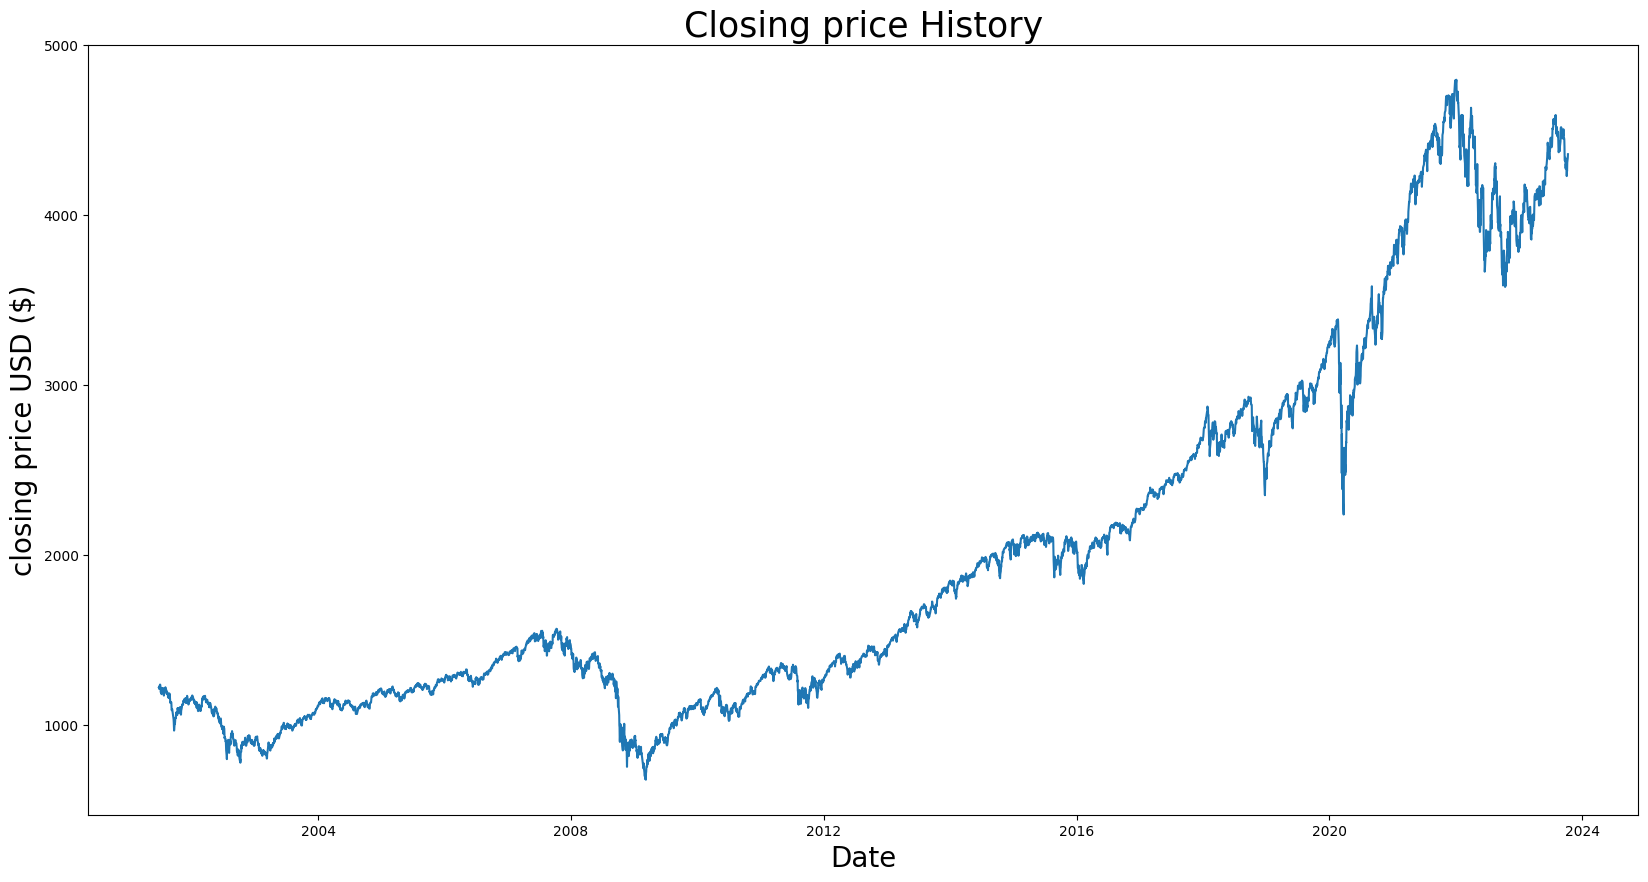

In [5]:
#lets look at the stock closing price of history
plt.figure(figsize=(20,10))
sns.lineplot(x= GSPC_data.index,y=GSPC_data['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('closing price USD ($)',fontsize=20)
plt.title('Closing price History',fontsize=25)

In [6]:
# Liste de vos DataFrames et leurs noms
dataframes = [GSPC_data, VIX_data, CL_DF_data, GC_F_data, EURUSD_X_data, GBPUSD_X_data, JPY_X_data, RUB_X_data, NG_F_data, TNX_data, FVX_data, FCHI_data, DJI_data, CNY_X_data, SZ_data, SS_data, MXX_data, BVSP_data, N225_data, HSI_data, STI_data, BSESN_data, TSM_data, ORAPA_data, VZ_data, VODL_data, ADBE_data, AAPL_data, MSFT_data, ORCL_data, IBM_data, INTC_data, QCOM_data, NVDA_data, AMZN_data]
names = ['GSPC', 'VIX', 'CL_DF', 'GC_F', 'EURUSD_X', 'GBPUSD_X', 'JPY_X', 'RUB_X', 'NG_F', 'TNX', 'FVX', 'FCHI', 'DJI', 'CNY_X', 'SZ', 'SS', 'MXX', 'BVSP', 'N225', 'HSI', 'STI', 'BSESN', 'TSM', 'ORAPA', 'VZ', 'VODL', 'ADBE', 'AAPL', 'MSFT', 'ORCL', 'IBM', 'INTC', 'QCOM', 'NVDA', 'AMZN']

# Initialiser un DataFrame vide
combined_data = pd.DataFrame()

# Parcourir chaque DataFrame et ajouter ses colonnes au DataFrame combiné
for df, name in zip(dataframes, names):
    # Sélectionnez seulement les colonnes qui vous intéressent (Open, Close, Min, Max)
    selected_columns = df[['Open', 'Close', 'Low', 'High']]
    
    # Renommez les colonnes pour inclure le nom de l'indice
    selected_columns.columns = pd.MultiIndex.from_product([[name], ['Open', 'Close', 'Low', 'High']])
    
    # Concaténez les colonnes sélectionnées au DataFrame combiné
    if combined_data.empty:
        combined_data = selected_columns
    else:
        combined_data = pd.concat([combined_data, selected_columns], axis=1)

combined_data.dropna(inplace=True)
# Affichez les premières lignes du DataFrame combiné
print(combined_data.shape)

(3678, 140)


### Carte de chaleur de correlation entre les features du modèle:

In [7]:
# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

### Sélection des features

In [8]:
# Sélectionner les caractéristiques avec une forte corrélation
target = ('GSPC', 'Close')
correlation_threshold = 0.8

# Trouver les caractéristiques fortement corrélées
highly_correlated_features = [idx for idx, corr in correlation_matrix[target].items() if abs(corr) > correlation_threshold]

print(f"Selected indices: {highly_correlated_features}")

Selected indices: [('GSPC', 'Open'), ('GSPC', 'Close'), ('GSPC', 'Low'), ('GSPC', 'High'), ('RUB_X', 'Open'), ('RUB_X', 'Close'), ('RUB_X', 'Low'), ('RUB_X', 'High'), ('FCHI', 'Open'), ('FCHI', 'Close'), ('FCHI', 'Low'), ('FCHI', 'High'), ('DJI', 'Open'), ('DJI', 'Close'), ('DJI', 'Low'), ('DJI', 'High'), ('BVSP', 'Open'), ('BVSP', 'Close'), ('BVSP', 'Low'), ('BVSP', 'High'), ('N225', 'Open'), ('N225', 'Close'), ('N225', 'Low'), ('N225', 'High'), ('BSESN', 'Open'), ('BSESN', 'Close'), ('BSESN', 'Low'), ('BSESN', 'High'), ('TSM', 'Open'), ('TSM', 'Close'), ('TSM', 'Low'), ('TSM', 'High'), ('ADBE', 'Open'), ('ADBE', 'Close'), ('ADBE', 'Low'), ('ADBE', 'High'), ('AAPL', 'Open'), ('AAPL', 'Close'), ('AAPL', 'Low'), ('AAPL', 'High'), ('MSFT', 'Open'), ('MSFT', 'Close'), ('MSFT', 'Low'), ('MSFT', 'High'), ('ORCL', 'Open'), ('ORCL', 'Close'), ('ORCL', 'Low'), ('ORCL', 'High'), ('QCOM', 'Open'), ('QCOM', 'Close'), ('QCOM', 'Low'), ('QCOM', 'High'), ('NVDA', 'Open'), ('NVDA', 'Close'), ('NVDA',

### Gestion de la Multicollinéarité

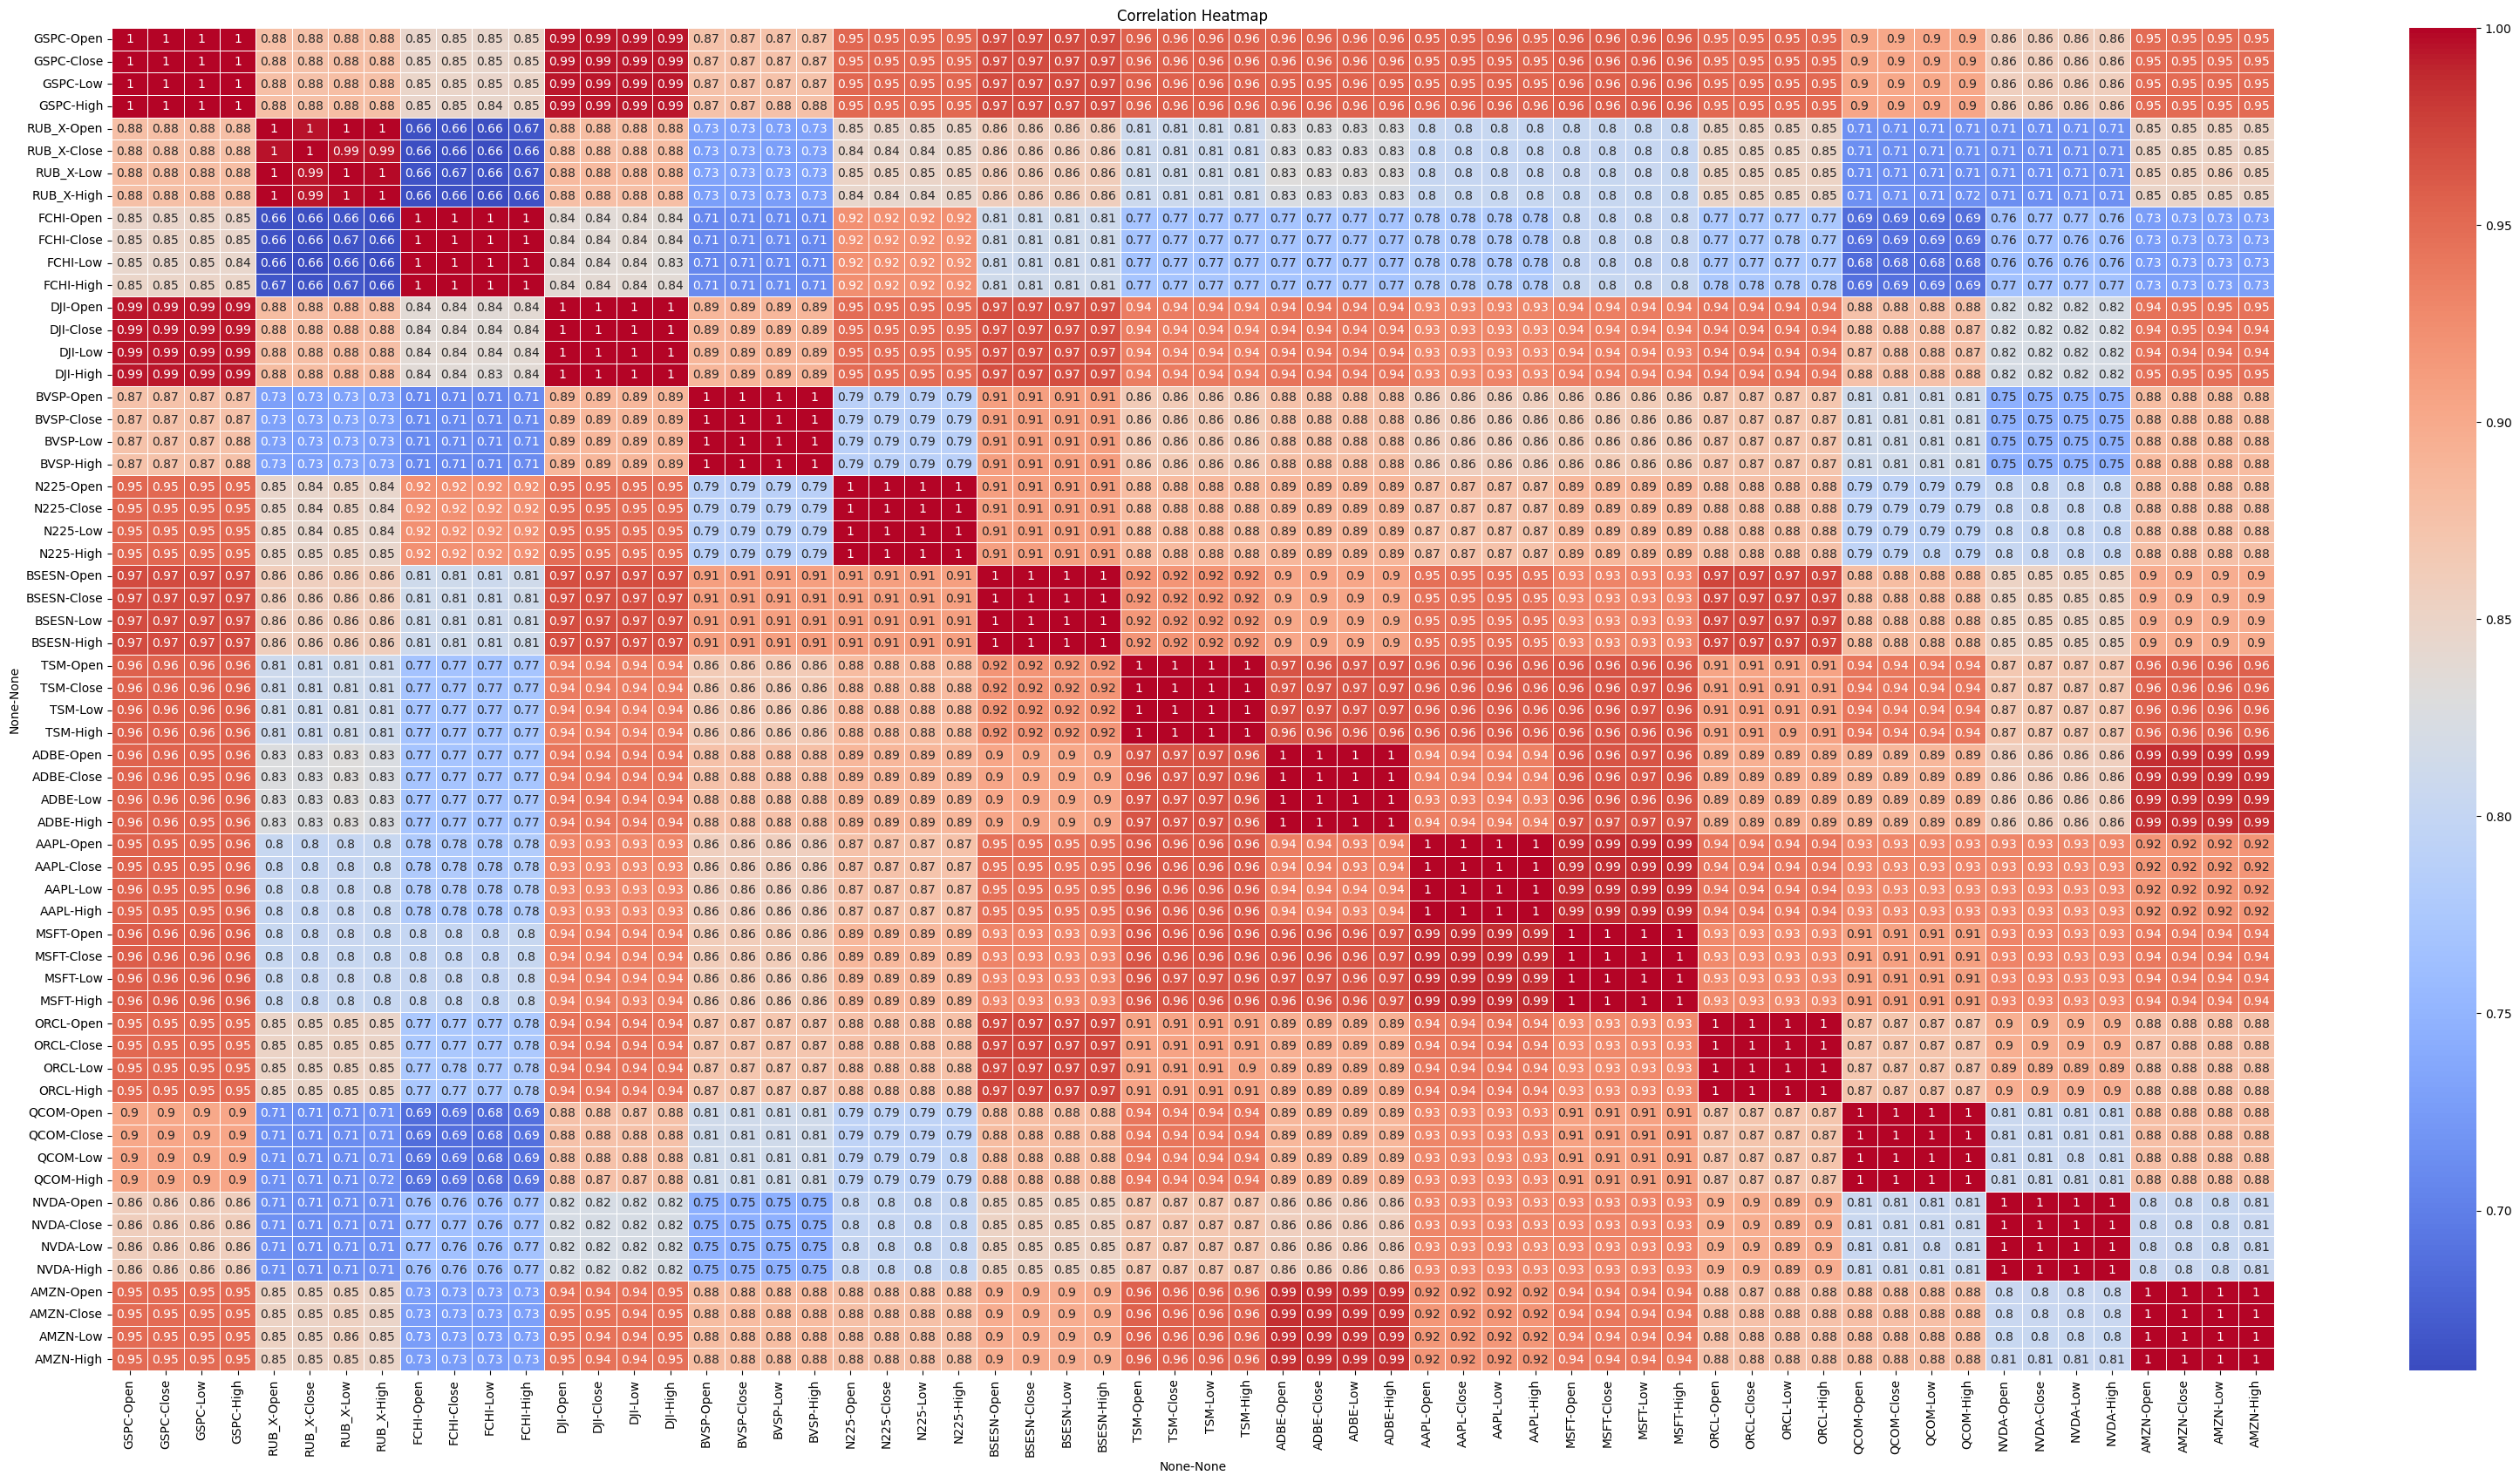

In [9]:
# Afficher la heatmap
selected_correlation_matrix = combined_data[highly_correlated_features].corr()

plt.figure(figsize=(40, 20))
sns.heatmap(selected_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [10]:
# Calculate VIF
def calculate_vif(dataframe, threshold=4.0):
    vif = pd.DataFrame()
    vif["Variable"] = [str(col) for col in dataframe.columns]
    vif["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    
    while vif["VIF"].max() > threshold:
        remove = vif.sort_values("VIF", ascending=False).iloc[0]
        removed_var = dataframe.columns[int(remove.name)]
        dataframe = dataframe.drop(removed_var, axis=1)
        vif = pd.DataFrame()
        vif["Variable"] = [str(col) for col in dataframe.columns]
        vif["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]

    return dataframe

### Sélection des features définitives:

In [11]:
#highly_correlated_features.remove(target)
filtred_df = combined_data[highly_correlated_features].copy()
# Extraire les valeurs de clôture pour chaque indice
close_values_df = combined_data.xs('Close', level=1, axis=1)

# Calculer le VIF sur ces valeurs
reduced_df = calculate_vif(close_values_df)

# Conserver seulement les indices qui ne sont pas colinéaires
valid_indices = reduced_df.columns.tolist()

# Créer un nouveau DataFrame contenant toutes les variables pour ces indices
final_df = combined_data.loc[:, pd.IndexSlice[valid_indices, :]]
print(final_df.shape)

(3678, 12)


### Normalisation des données

In [12]:
# Initialisez un dictionnaire pour stocker les scalers
scalers_dict = {}

# Créez un DataFrame vide pour stocker les données mises à l'échelle
scaled_data_df = pd.DataFrame(index=final_df.index)

# Itérer sur le premier niveau de l'index multi-niveaux (noms des indices)
for first_level in final_df.columns.levels[0]:
    # Itérer sur le second niveau de l'index multi-niveaux (Open, Close, High, Low)
    for second_level in final_df.columns.levels[1]:
        feature = (first_level, second_level)
        
        if feature in final_df.columns:
            feature_scaler = RobustScaler()
            scaled_feature = feature_scaler.fit_transform(final_df[feature].values.reshape(-1, 1))
            scaled_data_df[feature] = scaled_feature.flatten()  # Convertir les données 2D en 1D
            
            # Stocker le scaler pour chaque combinaison d'indice et de mesure
            scalers_dict[feature] = feature_scaler

print(scaled_data_df.head())

            (FVX, Close)  (FVX, High)  (FVX, Low)  (FVX, Open)  (NVDA, Close)  \
Date                                                                            
2003-12-01      0.836000     0.841495    0.835247     0.802225      -0.075429   
2003-12-02      0.820681     0.832322    0.846867     0.823928      -0.075588   
2003-12-03      0.836000     0.815055    0.830267     0.823928      -0.075975   
2003-12-04      0.809192     0.820451    0.834140     0.843462      -0.076169   
2003-12-05      0.705786     0.720086    0.720708     0.713782      -0.077365   

            (NVDA, High)  (NVDA, Low)  (NVDA, Open)  (VIX, Close)  \
Date                                                                
2003-12-01     -0.076722    -0.076811     -0.076744      0.003406   
2003-12-02     -0.076393    -0.076648     -0.076868     -0.053364   
2003-12-03     -0.075839    -0.076902     -0.076691     -0.012489   
2003-12-04     -0.076757    -0.077918     -0.077063     -0.049957   
2003-12-05     -0.

In [13]:
# Split into train and test:
# Définissez la taille de l'ensemble d'entraînement
train_size = int(len(scaled_data_df)) - 200
test_size = 200

# Séparez les données
train_data = scaled_data_df.iloc[:train_size]
test_data = scaled_data_df.iloc[train_size:]
print(train_data.shape)
print(test_data.shape)

(3478, 12)
(200, 12)


In [14]:
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

### Création d'une métrique personalisée pour la prédiction récursive 

In [15]:
def weighted_rmse(y_true, y_pred, total_observations):
    weights = np.arange(total_observations, 0, -1) / total_observations
    weighted_square_errors = weights * ((y_pred - y_true) ** 2)
    weighted_rmse = sqrt(np.mean(weighted_square_errors))
    return weighted_rmse
    
    weighted_square_errors = weights * ((y_pred - y_true) ** 2)
    weighted_rmse = sqrt(np.mean(weighted_square_errors))
    return weighted_rmse

# Recherche de la meilleure architecture pour les modèles neuronaux

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
best_params_per_feature = {}
top_n_trials_per_feature = {}

# Function to create sequences for multi-output prediction

def create_single_output_sequences(data, index_name, look_back=1):
    X, y = [], []
    feature_columns = ['Close']
    for i in range(look_back, len(data)):
        sequence_data = data.loc[data.index[i-look_back:i], [(index_name, col) for col in feature_columns]].values
        X.append(sequence_data)
        y.append(data.loc[data.index[i], [(index_name, 'Close')]].values[0])
    return np.array(X), np.array(y)

def generate_recursive_predictions(model, X_val, n_steps=10):
    # Supposons que X_val soit de forme (nombre_d'exemples, look_back, nombre_de_features)
    recursive_predictions = []
    input_sequence = X_val[0].reshape(1, X_val.shape[1], X_val.shape[2])  # Prendre la première séquence

    for i in range(n_steps):
        # Faire une prédiction à partir de la séquence d'entrée
        prediction = model.predict(input_sequence, verbose=0)
        recursive_predictions.append(prediction[0, 0])

        # Mettre à jour la séquence d'entrée pour inclure la nouvelle prédiction
        new_input_sequence = np.append(input_sequence[0, 1:, :], prediction)
        input_sequence = new_input_sequence.reshape(1, X_val.shape[1], X_val.shape[2])

    return np.array(recursive_predictions)


def create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, input_shape, use_conv1d , conv1d_filters ,conv1d_kernel_size ,use_residual_connection, attention_layer, l1_reg, l2_reg):
    inputs = Input(shape=input_shape)
    x = inputs
    if use_conv1d:
        x = Conv1D(conv1d_filters, kernel_size=conv1d_kernel_size, activation='relu')(x)
    if layer_type[0] == "GRU":
        x = Bidirectional(GRU(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    elif layer_type[0] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    x = Dropout(dropout_per_layer[0])(x)
    for i in range(1, num_layers):
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x_res = x
        if layer_type[i] == "GRU":
            x = Bidirectional(GRU(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        elif layer_type[i] == "LSTM":
            x = Bidirectional(LSTM(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        x = Dropout(dropout_per_layer[i])(x)
        if attention_layer:
            x = Attention(use_scale=True)([x, x])
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x = Add()([x, x_res])
    if layer_type[num_layers-1] == "GRU":
        x = Bidirectional(GRU(units_per_layer[num_layers-1]))(x)
    elif layer_type[num_layers-1] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[num_layers-1]))(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

for index_name in final_df.columns.get_level_values(0).unique():  # Parcourir chaque indice

    # Définition de l'objectif
    def objective(trial):

        # Espace de recherche
        ###############################################################################################
        look_back = trial.suggest_int('look_back', int(test_size/4), int(test_size/2) - 1)
        num_layers = trial.suggest_int('num_layers', 5, 8)
        layer_type = [trial.suggest_categorical(f'layer_type_{i}', ['LSTM', 'GRU']) for i in range(num_layers)]
        units_per_layer = [trial.suggest_int(f'units_power_{i}', 7, 9) for i in range(num_layers)]
        units_per_layer = [2 ** power for power in units_per_layer]
        dropout_per_layer = [trial.suggest_float(f'dropout_{i}', 0.1, 0.3) for i in range(num_layers)]
        use_residual_connection = trial.suggest_categorical('use_residual_connection', [True, False])
        attention_layer = trial.suggest_categorical('use_attention_layer', [True, False])
        use_conv1d = trial.suggest_categorical('use_conv1d', [False, True])
        if use_conv1d:
            conv1d_filters = trial.suggest_int('conv1d_filters', 5, 7)
            conv1d_filters = 2 ** conv1d_filters
            conv1d_kernel_size = trial.suggest_int('conv1d_kernel_size', 3, 7)
        l1_reg = trial.suggest_float('l1_reg', 1e-5, 1e-1, log=True)
        l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-1, log=True)
        ################################################################################################

        # Créez des séquences en utilisant look_back
        X_train, y_train = create_single_output_sequences(train_data, index_name , look_back)
        X_test, y_test = create_single_output_sequences(test_data, index_name ,look_back)

        n_splits = 5  # Nombre de splits
        tscv = TimeSeriesSplit(n_splits=n_splits)

        val_loss_list = []  # Liste pour stocker la val_loss de chaque split
        mda_list = []  # Liste pour stocker MDA de chaque split
        train_loss_list = []  # Liste pour stocker la loss de chaque split

        for train_index, val_index in tscv.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            if use_conv1d:
                model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), 1), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)
            else:
                conv1d_filters = 36
                conv1d_kernel_size = 5
                model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), 1), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)

            history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=10, batch_size=64, verbose=0, callbacks=[early_stopping])

            last_val_loss = history.history['val_loss'][-1]
            last_train_loss = history.history['loss'][-1]
            
            # Calcul de MDA
            y_true_direction = np.sign(np.diff(y_val_fold.reshape(-1)))  # vrai direction
            y_pred_direction = np.sign(np.diff(model.predict(X_val_fold, verbose=0).reshape(-1)))  # prédiction de direction
            mda = np.mean(y_true_direction == y_pred_direction)
            
            val_loss_list.append(last_val_loss)
            train_loss_list.append(last_train_loss)
            mda_list.append(mda)
        
        mean_val_loss = np.mean(val_loss_list)
        mean_train_loss = np.mean(train_loss_list)
        mean_mda = np.mean(mda_list)
        
        
        # Calcul des malus
        loss_difference_malus = abs(mean_val_loss - mean_train_loss) * 1
        recursive_predictions = generate_recursive_predictions(model, X_val_fold, len(X_val_fold))
        std_value = np.std(recursive_predictions)  # Calcul de l'écart-type des prédictions récursives
        if std_value == 0:
            std_malus = 3  # Si l'écart-type est de 0, pénalité maximale
        else:
            std_malus = 1 - std_value

        # Calcul du score final avec les malus
        final_score = (1 - mean_mda) + loss_difference_malus + std_malus

        print("mda: " + str(mean_mda))
        print("loss diff: " + str(loss_difference_malus))
        print("std: " + str(std_malus))

        return final_score

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=35)
    
    best_params_per_feature[index_name] = study.best_params

    top_n_trials = sorted(study.trials, key=lambda trial: trial.value)[:5]

    # Stockez les meilleurs hyperparamètres
    top_n_params = [trial.params for trial in top_n_trials]

    # Stockez ces meilleurs paramètres dans le dictionnaire
    top_n_trials_per_feature[index_name] = top_n_params

    # Affichage des résultats
    print(f'Number of finished trials for {index_name}: ', len(study.trials))
    print('Best 5 trials:')
    for i, trial in enumerate(top_n_trials):
        print(f'Rank {i+1} - Value: {trial.value}, Params: {trial.params}')

[I 2023-10-12 12:23:56,742] A new study created in memory with name: no-name-93e8a93e-8329-403e-bb78-bb356292ed2f
[I 2023-10-12 12:32:25,805] Trial 0 finished with value: 4.183040260766642 and parameters: {'look_back': 71, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 7, 'units_power_7': 9, 'dropout_0': 0.1378328959963894, 'dropout_1': 0.23985545535892375, 'dropout_2': 0.2698862107246056, 'dropout_3': 0.2106947095953513, 'dropout_4': 0.1434952872226617, 'dropout_5': 0.1420624226860537, 'dropout_6': 0.1873782262958305, 'dropout_7': 0.27853852787754185, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.073124826667041, 'l2_reg': 0.008584246433282709}. 

mda: 0.2568904593639576
loss diff: 2.4399307250976534
std: 0.9999999950329461


[I 2023-10-12 12:38:16,227] Trial 1 finished with value: 1.732008353700029 and parameters: {'look_back': 84, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 7, 'dropout_0': 0.2673355815721117, 'dropout_1': 0.21422196655801723, 'dropout_2': 0.13972540292734154, 'dropout_3': 0.18232682206132877, 'dropout_4': 0.1895555950881484, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 2.0963531658883855e-05, 'l2_reg': 0.005603751296545585}. Best is trial 1 with value: 1.732008353700029.


mda: 0.46808510638297884
loss diff: 0.2065074414014817
std: 0.9935860186815262


[I 2023-10-12 12:44:44,901] Trial 2 finished with value: 3.72839743058036 and parameters: {'look_back': 89, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.16451220465384703, 'dropout_1': 0.2401911996718352, 'dropout_2': 0.27609334170432287, 'dropout_3': 0.2662817496060597, 'dropout_4': 0.1770030063997363, 'dropout_5': 0.21424351169971312, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 3, 'l1_reg': 0.0502477409163604, 'l2_reg': 0.0001813057377921292}. Best is trial 1 with value: 1.732008353700029.


mda: 0.4678507992895205
loss diff: 2.1962482452392535
std: 0.9999999846306267


[I 2023-10-12 12:52:03,784] Trial 3 finished with value: 2.1784742160741177 and parameters: {'look_back': 57, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 9, 'units_power_7': 7, 'dropout_0': 0.28470946742767866, 'dropout_1': 0.2788026434522532, 'dropout_2': 0.12028504064819817, 'dropout_3': 0.11547596837176599, 'dropout_4': 0.28635477194756975, 'dropout_5': 0.27886004552699917, 'dropout_6': 0.29219214699048823, 'dropout_7': 0.10922075216176826, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.0001744452864076555, 'l2_reg': 0.004382320575340474}. Best is trial 1 with value: 1.732008353700029.


mda: 0.4492091388400703
loss diff: 0.6648252367973324
std: 0.9628581181168556


[I 2023-10-12 12:59:00,784] Trial 4 finished with value: 1.6415340241038128 and parameters: {'look_back': 96, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 7, 'dropout_0': 0.187527351838508, 'dropout_1': 0.11199323852343888, 'dropout_2': 0.24750969817070081, 'dropout_3': 0.18044466562847433, 'dropout_4': 0.17116909323554147, 'dropout_5': 0.19310170045203412, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.00010058190810328338, 'l2_reg': 0.0005819318440441605}. Best is trial 4 with value: 1.6415340241038128.


mda: 0.4772241992882562
loss diff: 0.12382397651672328
std: 0.9949342468753457


[I 2023-10-12 13:05:39,975] Trial 5 finished with value: 3.20429920591742 and parameters: {'look_back': 61, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.10636299277796085, 'dropout_1': 0.16198528257333994, 'dropout_2': 0.11008837466244777, 'dropout_3': 0.1536084740763711, 'dropout_4': 0.2026817512206856, 'dropout_5': 0.13080593883306926, 'dropout_6': 0.2845106454775681, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.043435336307094737, 'l2_reg': 5.226588709400548e-05}. Best is trial 4 with value: 1.6415340241038128.


mda: 0.4573943661971831
loss diff: 1.6616935729980469
std: 0.999999999116556


[I 2023-10-12 13:12:57,884] Trial 6 finished with value: 2.319312661228345 and parameters: {'look_back': 83, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.14493930747457942, 'dropout_1': 0.23053785407626026, 'dropout_2': 0.24822257785006796, 'dropout_3': 0.19841401024408178, 'dropout_4': 0.23759128699721255, 'dropout_5': 0.15803271496148205, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 7.440801071530032e-05, 'l2_reg': 0.04309260337677817}. Best is trial 4 with value: 1.6415340241038128.


mda: 0.4648936170212766
loss diff: 0.8122903943061828
std: 0.9719158839434385


[I 2023-10-12 13:18:15,578] Trial 7 finished with value: 0.9743309688484312 and parameters: {'look_back': 53, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.2818270335765578, 'dropout_1': 0.153050054742967, 'dropout_2': 0.29609844141794694, 'dropout_3': 0.25505876456094756, 'dropout_4': 0.11277079945021791, 'dropout_5': 0.15187831911836097, 'dropout_6': 0.1133137225067898, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 2.3905721245092817e-05, 'l2_reg': 3.27130125503443e-05}. Best is trial 7 with value: 0.9743309688484312.


mda: 0.4752196836555361
loss diff: 0.18610968589782706
std: 0.26344096660614014


[I 2023-10-12 13:27:10,691] Trial 8 finished with value: 2.346945778217087 and parameters: {'look_back': 85, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 8, 'units_power_7': 9, 'dropout_0': 0.25780498719157846, 'dropout_1': 0.24337652865774959, 'dropout_2': 0.1991819776953931, 'dropout_3': 0.2345661740533818, 'dropout_4': 0.10377971702773625, 'dropout_5': 0.1346425245682773, 'dropout_6': 0.13017163773075457, 'dropout_7': 0.24578075527518511, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0005790092796659717, 'l2_reg': 0.02061901019834302}. Best is trial 7 with value: 0.9743309688484312.


mda: 0.475531914893617
loss diff: 0.8368586063385006
std: 0.9856190867722034


[I 2023-10-12 13:33:02,596] Trial 9 finished with value: 1.4034183470345047 and parameters: {'look_back': 68, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.17852552478898304, 'dropout_1': 0.12857044717059615, 'dropout_2': 0.17618858339891885, 'dropout_3': 0.1185132486978233, 'dropout_4': 0.1206258183275608, 'dropout_5': 0.1588161839099378, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0005694568435625109, 'l2_reg': 0.006617475344638851}. Best is trial 7 with value: 0.9743309688484312.


mda: 0.4867724867724868
loss diff: 0.042411530017852694
std: 0.8477793037891388


[I 2023-10-12 13:38:00,215] Trial 10 finished with value: 1.734439660297674 and parameters: {'look_back': 50, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.22825184244804372, 'dropout_1': 0.1784788535420323, 'dropout_2': 0.29708942144885614, 'dropout_3': 0.29971640080831025, 'dropout_4': 0.14027578443608904, 'dropout_5': 0.10551647943739124, 'dropout_6': 0.1291885146274779, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 1.3599788218430136e-05, 'l2_reg': 1.0720348574621435e-05}. Best is trial 7 with value: 0.9743309688484312.


mda: 0.47824561403508775
loss diff: 0.24530128240585325
std: 0.9673839919269085


[I 2023-10-12 13:42:34,440] Trial 11 finished with value: 1.981518848377035 and parameters: {'look_back': 69, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.22091332929624086, 'dropout_1': 0.1285913574464671, 'dropout_2': 0.19123478002589628, 'dropout_3': 0.1073424877411875, 'dropout_4': 0.10098327472153217, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 0.001953715639216142, 'l2_reg': 0.0013588402216748526}. Best is trial 7 with value: 0.9743309688484312.


mda: 0.47548500881834216
loss diff: 0.5795406579971312
std: 0.877463199198246


[I 2023-10-12 13:48:37,674] Trial 12 finished with value: 1.492022446070759 and parameters: {'look_back': 63, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.20642670150959852, 'dropout_1': 0.14373392230149565, 'dropout_2': 0.1703272615284734, 'dropout_3': 0.1417203132074644, 'dropout_4': 0.12945649595378006, 'dropout_5': 0.1867717140717527, 'dropout_6': 0.10168976096078676, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 5, 'l1_reg': 0.0009214646714643292, 'l2_reg': 0.0010134117079379993}. Best is trial 7 with value: 0.9743309688484312.


mda: 0.47535211267605637
loss diff: 0.060281145572663064
std: 0.9070934131741524


[I 2023-10-12 13:53:09,688] Trial 13 finished with value: 1.796287287180884 and parameters: {'look_back': 50, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.2978709568936051, 'dropout_1': 0.10081191577010382, 'dropout_2': 0.22201938388683806, 'dropout_3': 0.23562539689270776, 'dropout_4': 0.10040462748545313, 'dropout_5': 0.10016284355342436, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.0039846341006819115, 'l2_reg': 0.06162408385991646}. Best is trial 7 with value: 0.9743309688484312.


mda: 0.4007017543859649
loss diff: 0.2413539409637453
std: 0.9556351006031036


[I 2023-10-12 13:59:34,244] Trial 14 finished with value: 0.4143692240698178 and parameters: {'look_back': 76, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.24385520727543092, 'dropout_1': 0.15108674335300754, 'dropout_2': 0.1665530068301897, 'dropout_3': 0.10108232887945692, 'dropout_4': 0.1378137780520396, 'dropout_5': 0.1657553650020842, 'dropout_6': 0.1887029268070303, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.374845938636815e-05, 'l2_reg': 0.0001300623120975782}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.4742049469964664
loss diff: 0.1261959552764893
std: -0.23762178421020508


[I 2023-10-12 14:05:43,034] Trial 15 finished with value: 2.1109848791924257 and parameters: {'look_back': 76, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.245872777931493, 'dropout_1': 0.16767034372338238, 'dropout_2': 0.21698717202160675, 'dropout_3': 0.14448842954962565, 'dropout_4': 0.15417872508713196, 'dropout_5': 0.224989080088703, 'dropout_6': 0.194699117241524, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 1.6866518906863602e-05, 'l2_reg': 5.259521530681005e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.48127208480565364
loss diff: 0.6235654473304749
std: 0.9686915166676044


[I 2023-10-12 14:12:35,469] Trial 16 finished with value: 1.6028493002973563 and parameters: {'look_back': 77, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 8, 'dropout_0': 0.2757418785808598, 'dropout_1': 0.18875885554450963, 'dropout_2': 0.15530094094996894, 'dropout_3': 0.16457688151681388, 'dropout_4': 0.127861066373991, 'dropout_5': 0.17512864636148276, 'dropout_6': 0.1694334320381009, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 1.0536270718103114e-05, 'l2_reg': 1.3569274958560184e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.4753982300884956
loss diff: 0.10385596752166748
std: 0.9743915628641844


[I 2023-10-12 14:20:55,228] Trial 17 finished with value: 1.6626668135890759 and parameters: {'look_back': 98, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 9, 'units_power_7': 7, 'dropout_0': 0.24894505756689111, 'dropout_1': 0.15190829087663216, 'dropout_2': 0.14639601353464105, 'dropout_3': 0.21818384970706323, 'dropout_4': 0.1551387788875146, 'dropout_5': 0.17038082762513415, 'dropout_6': 0.23464582819630636, 'dropout_7': 0.1804687250420881, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 5.428680614939565e-05, 'l2_reg': 0.00016685321370620574}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.47686832740213525
loss diff: 0.2815809369087221
std: 0.857954204082489


[I 2023-10-12 14:26:13,270] Trial 18 finished with value: 0.5125471246158719 and parameters: {'look_back': 56, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.29236505876164465, 'dropout_1': 0.19341797124062288, 'dropout_2': 0.2202816003317714, 'dropout_3': 0.12925738345480065, 'dropout_4': 0.12345637902347728, 'dropout_5': 0.2086269924353631, 'dropout_6': 0.1587945868876942, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 3.694985043659035e-05, 'l2_reg': 2.9239189983149407e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.4752196836555361
loss diff: 0.46253234744071947
std: -0.4747655391693115


[I 2023-10-12 14:33:07,092] Trial 19 finished with value: 1.4715385369012057 and parameters: {'look_back': 62, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 7, 'units_power_7': 8, 'dropout_0': 0.2975052752140402, 'dropout_1': 0.20159654259048135, 'dropout_2': 0.21680460442606742, 'dropout_3': 0.10161490545191612, 'dropout_4': 0.16002795718275442, 'dropout_5': 0.22345811108539654, 'dropout_6': 0.15511541032617723, 'dropout_7': 0.1807921679117926, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 3.636118103809006e-05, 'l2_reg': 0.00013140100220067466}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.4700704225352113
loss diff: 0.25631239414215123
std: 0.6852965652942657


[I 2023-10-12 14:39:26,563] Trial 20 finished with value: 1.7131293004740675 and parameters: {'look_back': 74, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.23956941402987877, 'dropout_1': 0.18048503971815122, 'dropout_2': 0.1784258170912471, 'dropout_3': 0.12654561561950858, 'dropout_4': 0.13133923411446702, 'dropout_5': 0.2462760151023981, 'dropout_6': 0.21783232828399443, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.00017363996529784205, 'l2_reg': 0.00033837371476212004}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.4713780918727915
loss diff: 0.2638106048107147
std: 0.9206967875361443


[I 2023-10-12 14:44:49,696] Trial 21 finished with value: 1.8077782755812568 and parameters: {'look_back': 55, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.2650729427697398, 'dropout_1': 0.1512534516169233, 'dropout_2': 0.29909249133961796, 'dropout_3': 0.12939425850576278, 'dropout_4': 0.11840398273460498, 'dropout_5': 0.19830866149930934, 'dropout_6': 0.1547514301611807, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 3.14490896950823e-05, 'l2_reg': 3.4970588524599746e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.47416520210896307
loss diff: 0.2989100217819214
std: 0.9830334559082985


[I 2023-10-12 14:50:13,643] Trial 22 finished with value: 0.7315113328462746 and parameters: {'look_back': 56, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.2837118044401605, 'dropout_1': 0.1719546651952065, 'dropout_2': 0.23484977419875597, 'dropout_3': 0.12863844851167394, 'dropout_4': 0.1197466763451492, 'dropout_5': 0.177612761465618, 'dropout_6': 0.11114599125313845, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 1.0285277131863574e-05, 'l2_reg': 2.644771812060254e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.47873462214411244
loss diff: 0.6456968665122986
std: -0.4354509115219116


[I 2023-10-12 14:55:57,619] Trial 23 finished with value: 1.8596025918316377 and parameters: {'look_back': 65, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.26182536636425885, 'dropout_1': 0.19533085640190376, 'dropout_2': 0.23170367144030887, 'dropout_3': 0.1002291637377807, 'dropout_4': 0.1374410748255935, 'dropout_5': 0.1786174232873571, 'dropout_6': 0.13994828240461965, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 1.0589932640361597e-05, 'l2_reg': 7.136832391260301e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.4871252204585538
loss diff: 0.5174985170364379
std: 0.8292292952537537


[I 2023-10-12 15:01:02,282] Trial 24 finished with value: 2.146337370853871 and parameters: {'look_back': 59, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.29978916282132884, 'dropout_1': 0.17411750488079067, 'dropout_2': 0.19833953079172612, 'dropout_3': 0.1306960587902081, 'dropout_4': 0.11769818717628384, 'dropout_5': 0.20845846736381787, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 4, 'l1_reg': 4.2853504543220427e-05, 'l2_reg': 2.1309948780982143e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.475
loss diff: 0.627779757976532
std: 0.9935576128773391


[I 2023-10-12 15:07:22,805] Trial 25 finished with value: 1.754695454163691 and parameters: {'look_back': 80, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.27695806554960634, 'dropout_1': 0.20279788158752468, 'dropout_2': 0.20787605814297175, 'dropout_3': 0.11917465773095712, 'dropout_4': 0.14974822297733426, 'dropout_5': 0.19100180119434718, 'dropout_6': 0.17570403001340867, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 5, 'l1_reg': 1.0145665047232915e-05, 'l2_reg': 2.0644303843002703e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.4704424778761062
loss diff: 0.23788095712661744
std: 0.9872569749131799


[I 2023-10-12 15:14:07,635] Trial 26 finished with value: 1.8370169951007218 and parameters: {'look_back': 66, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 7, 'units_power_7': 8, 'dropout_0': 0.23705425778582856, 'dropout_1': 0.1705812112522304, 'dropout_2': 0.24068749167421452, 'dropout_3': 0.15531849407378415, 'dropout_4': 0.13516965549657634, 'dropout_5': 0.17111131677050473, 'dropout_6': 0.10399309886382935, 'dropout_7': 0.29265751255562944, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 2.784667380454778e-05, 'l2_reg': 8.478105384205431e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.4726631393298059
loss diff: 0.3162081003189088
std: 0.993472034111619


[I 2023-10-12 15:20:53,767] Trial 27 finished with value: 1.6520253018123945 and parameters: {'look_back': 73, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.2555147527198399, 'dropout_1': 0.18603837677709745, 'dropout_2': 0.22609096998137798, 'dropout_3': 0.1330938232531077, 'dropout_4': 0.11517403482988262, 'dropout_5': 0.2396964930326946, 'dropout_6': 0.15556776645156256, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 8.34771010942654e-05, 'l2_reg': 2.509405309759071e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.4742049469964664
loss diff: 0.1533492445945741
std: 0.9728810042142868


[I 2023-10-12 15:26:19,878] Trial 28 finished with value: 1.6876774324199122 and parameters: {'look_back': 55, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.28393882665013054, 'dropout_1': 0.14155037570466902, 'dropout_2': 0.19174574046403536, 'dropout_3': 0.11220330242278641, 'dropout_4': 0.1449003386522254, 'dropout_5': 0.20481448400478708, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.786293419007998e-05, 'l2_reg': 1.0319340883022766e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.47416520210896307
loss diff: 0.19594576358795168
std: 0.9658968709409237


[I 2023-10-12 15:33:29,864] Trial 29 finished with value: 1.6342754153896768 and parameters: {'look_back': 71, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 7, 'units_power_7': 7, 'dropout_0': 0.21267953015415955, 'dropout_1': 0.15844655340449285, 'dropout_2': 0.2636235066565137, 'dropout_3': 0.1411240446325724, 'dropout_4': 0.1612760506951425, 'dropout_5': 0.18604714339990944, 'dropout_6': 0.12274734595174128, 'dropout_7': 0.12083602485448186, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 4.789910271993116e-05, 'l2_reg': 0.000104298557970148}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.4713780918727915
loss diff: 0.16632946729660025
std: 0.939324039965868


[I 2023-10-12 15:42:23,460] Trial 30 finished with value: 1.3420706675488827 and parameters: {'look_back': 93, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 8, 'units_power_7': 9, 'dropout_0': 0.23483413889522775, 'dropout_1': 0.1700324331181918, 'dropout_2': 0.20831389338198286, 'dropout_3': 0.10193741251374404, 'dropout_4': 0.14252318905428382, 'dropout_5': 0.19995690450494352, 'dropout_6': 0.1400524252987259, 'dropout_7': 0.2259591022854853, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 2.2458721647420834e-05, 'l2_reg': 3.9806547455035885e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.46998223801065714
loss diff: 0.21802330017089844
std: 0.5940296053886414


[I 2023-10-12 15:47:42,505] Trial 31 finished with value: 1.9128057538127439 and parameters: {'look_back': 53, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.2801666121631234, 'dropout_1': 0.13529305885663834, 'dropout_2': 0.2609096893152715, 'dropout_3': 0.12095160322522376, 'dropout_4': 0.11307813610885172, 'dropout_5': 0.1511430693069495, 'dropout_6': 0.1161601731987659, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 1.9394324788960294e-05, 'l2_reg': 3.1083068833025685e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.4738137082601055
loss diff: 0.5021464586257935
std: 0.8844730034470558


[I 2023-10-12 15:53:23,533] Trial 32 finished with value: 1.744217347679004 and parameters: {'look_back': 59, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.2694246010252143, 'dropout_1': 0.15840940073436102, 'dropout_2': 0.2756757616175058, 'dropout_3': 0.16058668193849304, 'dropout_4': 0.11081525468478383, 'dropout_5': 0.14367615185712054, 'dropout_6': 0.11190229448139923, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 2.580599350249614e-05, 'l2_reg': 5.5249088631080827e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.4725352112676056
loss diff: 0.40698176622390747
std: 0.809770792722702


[I 2023-10-12 15:59:17,245] Trial 33 finished with value: 0.9882743742218754 and parameters: {'look_back': 53, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.2886851251730529, 'dropout_1': 0.1874282661227658, 'dropout_2': 0.23693452591625172, 'dropout_3': 0.1751518776325603, 'dropout_4': 0.1267281472737665, 'dropout_5': 0.16008095473258746, 'dropout_6': 0.10305031658267819, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 1.777851708919788e-05, 'l2_reg': 1.7832141201523975e-05}. Best is trial 14 with value: 0.4143692240698178.


mda: 0.48189806678383135
loss diff: 0.384550905227661
std: 0.08562153577804565


[I 2023-10-12 16:03:33,946] Trial 34 finished with value: 0.9988903760910034 and parameters: {'look_back': 59, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'dropout_0': 0.2695156396570957, 'dropout_1': 0.20961823445875916, 'dropout_2': 0.2810378294647149, 'dropout_3': 0.19560820623938682, 'dropout_4': 0.10871136756641389, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 3.621076108551929e-05, 'l2_reg': 0.000244725827649121}. Best is trial 14 with value: 0.4143692240698178.
[I 2023-10-12 16:03:33,963] A new study created in memory with name: no-name-a6080e99-dd76-447b-9b27-693e871b18f9


mda: 0.475
loss diff: 0.21087641716003414
std: 0.26301395893096924
Number of finished trials for VIX:  35
Best 5 trials:
Rank 1 - Value: 0.4143692240698178, Params: {'look_back': 76, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.24385520727543092, 'dropout_1': 0.15108674335300754, 'dropout_2': 0.1665530068301897, 'dropout_3': 0.10108232887945692, 'dropout_4': 0.1378137780520396, 'dropout_5': 0.1657553650020842, 'dropout_6': 0.1887029268070303, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.374845938636815e-05, 'l2_reg': 0.0001300623120975782}
Rank 2 - Value: 0.5125471246158719, Params: {'look_back': 56, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_ty

[I 2023-10-12 16:10:21,635] Trial 0 finished with value: 3.147432797474191 and parameters: {'look_back': 81, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.23344553551126493, 'dropout_1': 0.2034050204815438, 'dropout_2': 0.20553930001720955, 'dropout_3': 0.14230363166644594, 'dropout_4': 0.20173359216562614, 'dropout_5': 0.28548565732240716, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 0.03737614368231599, 'l2_reg': 0.05967582759053384}. Best is trial 0 with value: 3.147432797474191.


mda: 0.42690265486725665
loss diff: 1.5743354797363267
std: 0.9999999726051207


[I 2023-10-12 16:17:33,931] Trial 1 finished with value: 1.618110194634088 and parameters: {'look_back': 65, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 7, 'units_power_7': 8, 'dropout_0': 0.2487774570339365, 'dropout_1': 0.27358910013131266, 'dropout_2': 0.15295595643887622, 'dropout_3': 0.25866821532905165, 'dropout_4': 0.10824947845026044, 'dropout_5': 0.14155207001883996, 'dropout_6': 0.2610533761464646, 'dropout_7': 0.2713288600291396, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 1.173751502574753e-05, 'l2_reg': 0.0002285507944738573}. Best is trial 1 with value: 1.618110194634088.


mda: 0.491710758377425
loss diff: 0.20160672664642343
std: 0.9082142263650894


[I 2023-10-12 16:26:15,054] Trial 2 finished with value: 4.742380733134268 and parameters: {'look_back': 93, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.15665742895650014, 'dropout_1': 0.1530569505021123, 'dropout_2': 0.2705329798526507, 'dropout_3': 0.1563297514218164, 'dropout_4': 0.2819718065694723, 'dropout_5': 0.2049129150007174, 'dropout_6': 0.14694312892869182, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.003143002404408139, 'l2_reg': 0.0004481461388203385}. Best is trial 1 with value: 1.618110194634088.


mda: 0.4234458259325044
loss diff: 1.1658265590667725
std: 3


[I 2023-10-12 16:33:08,204] Trial 3 finished with value: 1.469380045497902 and parameters: {'look_back': 75, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.19788415303587856, 'dropout_1': 0.20629800288970218, 'dropout_2': 0.22844783090694723, 'dropout_3': 0.15345761371629305, 'dropout_4': 0.16191858059887115, 'dropout_5': 0.22961365057508756, 'dropout_6': 0.2905594824349138, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 2.789887311579156e-05, 'l2_reg': 7.491258333977273e-05}. Best is trial 3 with value: 1.469380045497902.


mda: 0.49116607773851595
loss diff: 0.010225391387939542
std: 0.9503207318484783


[I 2023-10-12 16:39:54,248] Trial 4 finished with value: 1.9422562837706017 and parameters: {'look_back': 71, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.15087227347454527, 'dropout_1': 0.2498753303386132, 'dropout_2': 0.20869316065102433, 'dropout_3': 0.16734803150517352, 'dropout_4': 0.22556938294257378, 'dropout_5': 0.23281302028536877, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 3.280132156659864e-05, 'l2_reg': 0.015731911706305484}. Best is trial 3 with value: 1.469380045497902.


mda: 0.4862190812720848
loss diff: 0.5074895918369293
std: 0.9209857732057571


[I 2023-10-12 16:47:44,859] Trial 5 finished with value: 1.5810246581453202 and parameters: {'look_back': 89, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 9, 'units_power_7': 7, 'dropout_0': 0.20680986401816892, 'dropout_1': 0.18856112462265961, 'dropout_2': 0.12006568839220642, 'dropout_3': 0.24632491173666035, 'dropout_4': 0.16385216345862158, 'dropout_5': 0.11231431628812659, 'dropout_6': 0.2925486402358697, 'dropout_7': 0.2502545396777257, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.0001091641900052851, 'l2_reg': 0.0008294036489244361}. Best is trial 3 with value: 1.469380045497902.


mda: 0.488809946714032
loss diff: 0.1422274112701416
std: 0.9276071935892105


[I 2023-10-12 16:53:43,267] Trial 6 finished with value: 1.1141874504220068 and parameters: {'look_back': 50, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'units_power_7': 7, 'dropout_0': 0.18410342261942952, 'dropout_1': 0.22613179230544936, 'dropout_2': 0.1575223523941751, 'dropout_3': 0.26187450605992624, 'dropout_4': 0.25236201792958357, 'dropout_5': 0.2803088198301801, 'dropout_6': 0.1484226774069381, 'dropout_7': 0.16083265346184544, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.1853913328114345e-05, 'l2_reg': 0.00555804492773121}. Best is trial 6 with value: 1.1141874504220068.


mda: 0.4817543859649123
loss diff: 0.1174700804054738
std: 0.4784717559814453


[I 2023-10-12 16:59:43,464] Trial 7 finished with value: 1.8928078586136916 and parameters: {'look_back': 71, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.1021574004694532, 'dropout_1': 0.1919897255263071, 'dropout_2': 0.19335534049672698, 'dropout_3': 0.2995493619838239, 'dropout_4': 0.2505900525786525, 'dropout_5': 0.11163848971648478, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 0.00023847168111934967, 'l2_reg': 0.05583901157790047}. Best is trial 6 with value: 1.1141874504220068.


mda: 0.14416961130742048
loss diff: 0.036977484822273254
std: 0.9999999850988388


[I 2023-10-12 17:05:39,686] Trial 8 finished with value: 1.4945301299057316 and parameters: {'look_back': 68, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.15927698924381448, 'dropout_1': 0.24706651433426027, 'dropout_2': 0.19816766027541471, 'dropout_3': 0.2931646722425766, 'dropout_4': 0.2847291821580081, 'dropout_5': 0.16418312595603762, 'dropout_6': 0.21674203913388734, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 0.0012974987134715887, 'l2_reg': 0.00029702918661788535}. Best is trial 6 with value: 1.1141874504220068.


mda: 0.4920634920634921
loss diff: 0.34162275791168284
std: 0.6449708640575409


[I 2023-10-12 17:12:01,144] Trial 9 finished with value: 1.6036243547433244 and parameters: {'look_back': 79, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.22534421696418797, 'dropout_1': 0.2621087338894295, 'dropout_2': 0.15847625989451583, 'dropout_3': 0.14131386008674945, 'dropout_4': 0.281019920534055, 'dropout_5': 0.10536611504246332, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.00016755864696254424, 'l2_reg': 2.0235390815251585e-05}. Best is trial 6 with value: 1.1141874504220068.


mda: 0.48176991150442483
loss diff: 0.14398931264877302
std: 0.9414049535989761


[I 2023-10-12 17:16:59,359] Trial 10 finished with value: 1.5314548124503669 and parameters: {'look_back': 51, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.2884103436686832, 'dropout_1': 0.10149467232049807, 'dropout_2': 0.10133305207217366, 'dropout_3': 0.20944022621585964, 'dropout_4': 0.243292816911264, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.2456995672550695e-05, 'l2_reg': 0.0029209151618861473}. Best is trial 6 with value: 1.1141874504220068.


mda: 0.4817543859649123
loss diff: 0.11128951311111424
std: 0.9019196853041649


[I 2023-10-12 17:23:56,400] Trial 11 finished with value: 1.0748615504777703 and parameters: {'look_back': 55, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 8, 'units_power_7': 7, 'dropout_0': 0.18648434204471143, 'dropout_1': 0.2972347083695932, 'dropout_2': 0.24428900424596928, 'dropout_3': 0.10199294182300092, 'dropout_4': 0.16277223702716967, 'dropout_5': 0.27857940583618207, 'dropout_6': 0.12323985728031352, 'dropout_7': 0.12441844126760829, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 3, 'l1_reg': 3.8260525888263935e-05, 'l2_reg': 3.457438162893309e-05}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.4836555360281195
loss diff: 0.06353377103805524
std: 0.4949833154678345


[I 2023-10-12 17:30:42,640] Trial 12 finished with value: 1.4811327907521474 and parameters: {'look_back': 50, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 8, 'units_power_7': 7, 'dropout_0': 0.18005337001320906, 'dropout_1': 0.2700539692584515, 'dropout_2': 0.29608990348148845, 'dropout_3': 0.10360800380958052, 'dropout_4': 0.1869557037042662, 'dropout_5': 0.288396969985814, 'dropout_6': 0.10221638426441067, 'dropout_7': 0.1224923947546693, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 3, 'l1_reg': 6.522367877769691e-05, 'l2_reg': 1.0226131835504143e-05}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.4810526315789474
loss diff: 0.008735334873199552
std: 0.9534500874578953


[I 2023-10-12 17:37:19,004] Trial 13 finished with value: 1.5653732882838853 and parameters: {'look_back': 59, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'units_power_7': 7, 'dropout_0': 0.18416407935885698, 'dropout_1': 0.29708976014446015, 'dropout_2': 0.24613003314107415, 'dropout_3': 0.20215764046984308, 'dropout_4': 0.13195710689078932, 'dropout_5': 0.298409644620855, 'dropout_6': 0.14816754917422356, 'dropout_7': 0.1372926086693922, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 3, 'l1_reg': 1.0990502992483352e-05, 'l2_reg': 0.0032739848372240112}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.48485915492957743
loss diff: 0.11561478972435002
std: 0.9346176534891129


[I 2023-10-12 17:44:16,177] Trial 14 finished with value: 2.067033967111253 and parameters: {'look_back': 58, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 8, 'units_power_7': 8, 'dropout_0': 0.12174184706346242, 'dropout_1': 0.29709487545766294, 'dropout_2': 0.24647115957617996, 'dropout_3': 0.10507644948611998, 'dropout_4': 0.2119101261474507, 'dropout_5': 0.26542861229679904, 'dropout_6': 0.14230260179618645, 'dropout_7': 0.15890823489279776, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 0.00037566622058522904, 'l2_reg': 0.00010404181748736974}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.49912126537785595
loss diff: 0.6555214524269104
std: 0.9106337800621986


[I 2023-10-12 17:50:15,151] Trial 15 finished with value: 1.0893972216046337 and parameters: {'look_back': 58, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.20893984049023925, 'dropout_1': 0.2287648237956996, 'dropout_2': 0.1722495958363271, 'dropout_3': 0.23065703574464042, 'dropout_4': 0.17748230201264187, 'dropout_5': 0.2545004003771555, 'dropout_6': 0.10289924734322142, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 5.2250528682163826e-05, 'l2_reg': 0.002283489257435322}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.4864674868189807
loss diff: 0.12050745487213121
std: 0.45535725355148315


[I 2023-10-12 17:56:53,800] Trial 16 finished with value: 1.3201113318053772 and parameters: {'look_back': 61, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.25645336292657483, 'dropout_1': 0.23083974054971737, 'dropout_2': 0.1806086563038367, 'dropout_3': 0.22594852602071572, 'dropout_4': 0.1787622824870294, 'dropout_5': 0.2531405822019005, 'dropout_6': 0.10066068444937118, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 5.648154744278123e-05, 'l2_reg': 0.0011957910211862534}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.4852112676056338
loss diff: 0.14661414623260516
std: 0.6587084531784058


[I 2023-10-12 18:03:09,024] Trial 17 finished with value: 2.026674463032126 and parameters: {'look_back': 56, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 9, 'dropout_0': 0.21843462026197147, 'dropout_1': 0.28295341076662633, 'dropout_2': 0.227102498737861, 'dropout_3': 0.18396864016315467, 'dropout_4': 0.13640059369020222, 'dropout_5': 0.25371900642636763, 'dropout_6': 0.19103252297809234, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.000417921280037169, 'l2_reg': 3.5935859571631816e-05}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.4917398945518453
loss diff: 0.5236457347869887
std: 0.9947686227969825


[I 2023-10-12 18:08:36,051] Trial 18 finished with value: 1.4365399071448286 and parameters: {'look_back': 63, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.20619831213046866, 'dropout_1': 0.2826171702362906, 'dropout_2': 0.17585403788022397, 'dropout_3': 0.18178039881947755, 'dropout_4': 0.18174081250277324, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 9.470542945815584e-05, 'l2_reg': 7.375471286457558e-05}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.4876760563380282
loss diff: 0.11507805287837991
std: 0.8091379106044769


[I 2023-10-12 18:14:57,541] Trial 19 finished with value: 1.5281236264429112 and parameters: {'look_back': 56, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.23998683193437742, 'dropout_1': 0.2540640486860046, 'dropout_2': 0.2696456092664976, 'dropout_3': 0.12381139072418912, 'dropout_4': 0.15335486247377986, 'dropout_5': 0.2287119437230612, 'dropout_6': 0.11476031310845136, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 4.4734574358980226e-05, 'l2_reg': 0.0010647884145908026}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.4882249560632689
loss diff: 0.15318084955215472
std: 0.8631677329540253


[I 2023-10-12 18:25:04,173] Trial 20 finished with value: 3.2067928863775483 and parameters: {'look_back': 99, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'layer_type_7': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 8, 'units_power_7': 9, 'dropout_0': 0.2678408885018233, 'dropout_1': 0.2272758497529526, 'dropout_2': 0.13510685205083756, 'dropout_3': 0.2203630841713719, 'dropout_4': 0.19976287149208774, 'dropout_5': 0.2675186498907464, 'dropout_6': 0.12304821884797938, 'dropout_7': 0.1025254556177792, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0008365205811368304, 'l2_reg': 0.00017962207889056736}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.496085409252669
loss diff: 1.7275038242340095
std: 0.9753744713962078


[I 2023-10-12 18:31:09,460] Trial 21 finished with value: 1.5522998231968896 and parameters: {'look_back': 53, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'units_power_7': 7, 'dropout_0': 0.18330518836629398, 'dropout_1': 0.22700277110915162, 'dropout_2': 0.16534236548132383, 'dropout_3': 0.24886717765256783, 'dropout_4': 0.22140076795125196, 'dropout_5': 0.28396817242201455, 'dropout_6': 0.1329229657772629, 'dropout_7': 0.17989161818416777, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 2.2845025015862034e-05, 'l2_reg': 0.005939244238546089}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.48822495606326893
loss diff: 0.11666194200515756
std: 0.9238628372550011


[I 2023-10-12 18:37:38,058] Trial 22 finished with value: 1.6392219913026782 and parameters: {'look_back': 54, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'units_power_7': 8, 'dropout_0': 0.21896118136367637, 'dropout_1': 0.24082649961016428, 'dropout_2': 0.14247536176876083, 'dropout_3': 0.26615554782940576, 'dropout_4': 0.1932483120456807, 'dropout_5': 0.2973381980927808, 'dropout_6': 0.1664735231919417, 'dropout_7': 0.2029216015317084, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 2.6524989642296645e-05, 'l2_reg': 0.009664147128016755}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.48119507908611603
loss diff: 0.19527640640735644
std: 0.9251406639814377


[I 2023-10-12 18:43:33,712] Trial 23 finished with value: 1.551751098697874 and parameters: {'look_back': 60, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.1948882661063946, 'dropout_1': 0.26352835072068226, 'dropout_2': 0.17899782261455596, 'dropout_3': 0.21890354430152256, 'dropout_4': 0.16757082817518787, 'dropout_5': 0.2702051925905742, 'dropout_6': 0.1229247325581623, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 6.617724298358577e-05, 'l2_reg': 0.001741537780882442}. Best is trial 11 with value: 1.0748615504777703.


mda: 0.4845070422535211
loss diff: 0.09488317221403131
std: 0.9413749687373638


[I 2023-10-12 18:49:46,724] Trial 24 finished with value: 0.8425627631471868 and parameters: {'look_back': 50, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 7, 'units_power_7': 7, 'dropout_0': 0.1710288929663094, 'dropout_1': 0.2203177168301096, 'dropout_2': 0.16639557706742245, 'dropout_3': 0.23542350262207493, 'dropout_4': 0.29930068551628575, 'dropout_5': 0.25335393045825144, 'dropout_6': 0.16174619551294137, 'dropout_7': 0.15343688038481204, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.9814366788485733e-05, 'l2_reg': 0.0006391255475652646}. Best is trial 24 with value: 0.8425627631471868.


mda: 0.4870175438596491
loss diff: 0.059827446937561035
std: 0.2697528600692749


[I 2023-10-12 18:56:04,061] Trial 25 finished with value: 1.4384310834004848 and parameters: {'look_back': 64, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.1678997623014205, 'dropout_1': 0.28483228755010925, 'dropout_2': 0.1897156683732804, 'dropout_3': 0.1835577582223332, 'dropout_4': 0.29384306474533056, 'dropout_5': 0.24777807345744104, 'dropout_6': 0.1719128110011961, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.00013018850173663826, 'l2_reg': 0.0005297853520632487}. Best is trial 24 with value: 0.8425627631471868.


mda: 0.4855633802816901
loss diff: 0.14568902254104632
std: 0.7783054411411285


[I 2023-10-12 19:02:51,232] Trial 26 finished with value: 1.477478778692247 and parameters: {'look_back': 55, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 7, 'units_power_7': 9, 'dropout_0': 0.21269423466377796, 'dropout_1': 0.29905684514178105, 'dropout_2': 0.17165566228237356, 'dropout_3': 0.22951057344170467, 'dropout_4': 0.26533275842905785, 'dropout_5': 0.20996651830776825, 'dropout_6': 0.11701344905909193, 'dropout_7': 0.10013033108381467, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 3, 'l1_reg': 2.4002729796919773e-05, 'l2_reg': 0.0005473170351284402}. Best is trial 24 with value: 0.8425627631471868.


mda: 0.48822495606326893
loss diff: 0.06737401485443106
std: 0.8983297199010849


[I 2023-10-12 19:10:05,247] Trial 27 finished with value: 1.4726479517719728 and parameters: {'look_back': 67, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 9, 'units_power_7': 7, 'dropout_0': 0.16829684743509143, 'dropout_1': 0.21161418317974706, 'dropout_2': 0.2142581774093093, 'dropout_3': 0.19969287410117542, 'dropout_4': 0.2358284223163149, 'dropout_5': 0.24298991200870212, 'dropout_6': 0.10460116790133385, 'dropout_7': 0.1429981799836774, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 5.303168965906432e-05, 'l2_reg': 0.00012378227634909643}. Best is trial 24 with value: 0.8425627631471868.


mda: 0.4878306878306879
loss diff: 0.03994155526161158
std: 0.9205370843410492


[I 2023-10-12 19:16:14,061] Trial 28 finished with value: 1.7340208029678914 and parameters: {'look_back': 53, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.14505282456067004, 'dropout_1': 0.2580250399074952, 'dropout_2': 0.18531001984101753, 'dropout_3': 0.23580974227375498, 'dropout_4': 0.21135648635065885, 'dropout_5': 0.26817792378086175, 'dropout_6': 0.128430180446127, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 0.00016444694553337905, 'l2_reg': 0.0002857945394965746}. Best is trial 24 with value: 0.8425627631471868.


mda: 0.486115992970123
loss diff: 0.31573684215545583
std: 0.9043999537825584


[I 2023-10-12 19:22:06,187] Trial 29 finished with value: 1.2525128262262817 and parameters: {'look_back': 86, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'dropout_0': 0.23309249003363203, 'dropout_1': 0.23916967412913903, 'dropout_2': 0.1981461337816057, 'dropout_3': 0.19638688634156032, 'dropout_4': 0.20258258331926937, 'dropout_5': 0.21881714351379916, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 0.009915740037768338, 'l2_reg': 4.3574444186163016e-05}. Best is trial 24 with value: 0.8425627631471868.


mda: 0.502482269503546
loss diff: 0.3689072608947752
std: 0.3860878348350525


[I 2023-10-12 19:27:35,087] Trial 30 finished with value: 0.9283247576632969 and parameters: {'look_back': 61, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.194704726743842, 'dropout_1': 0.21554481824689786, 'dropout_2': 0.14374020662178977, 'dropout_3': 0.12204061659224139, 'dropout_4': 0.18030362348878015, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 8.917812431105604e-05, 'l2_reg': 0.0017703877203791116}. Best is trial 24 with value: 0.8425627631471868.


mda: 0.477112676056338
loss diff: 0.20335485935211173
std: 0.2020825743675232


[I 2023-10-12 19:32:52,007] Trial 31 finished with value: 1.3716133939570412 and parameters: {'look_back': 57, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.20085293201971463, 'dropout_1': 0.2161872310174644, 'dropout_2': 0.13825606164139836, 'dropout_3': 0.11098322477365175, 'dropout_4': 0.18034045287296915, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 8.604773563743855e-05, 'l2_reg': 0.0017691725503546092}. Best is trial 24 with value: 0.8425627631471868.


mda: 0.48295254833040424
loss diff: 0.2079236745834354
std: 0.64664226770401


[I 2023-10-12 19:38:21,817] Trial 32 finished with value: 1.5127343076635418 and parameters: {'look_back': 62, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.1954941090507073, 'dropout_1': 0.21396256910213118, 'dropout_2': 0.16788355032089522, 'dropout_3': 0.12453292362844545, 'dropout_4': 0.1470884335149656, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.817906965949026e-05, 'l2_reg': 0.0006699800324986242}. Best is trial 24 with value: 0.8425627631471868.


mda: 0.4830985915492957
loss diff: 0.07690652608871495
std: 0.9189263731241226


[I 2023-10-12 19:45:53,735] Trial 33 finished with value: 1.594074890257978 and parameters: {'look_back': 66, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 7, 'dropout_0': 0.22691183448697194, 'dropout_1': 0.1894515042005782, 'dropout_2': 0.14763945984310656, 'dropout_3': 0.100381911790376, 'dropout_4': 0.17443876173027237, 'dropout_5': 0.24402391872328008, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 4.491073230927665e-05, 'l2_reg': 0.00034852950994073995}. Best is trial 24 with value: 0.8425627631471868.


mda: 0.4751322751322751
loss diff: 0.10236257314682007
std: 0.966844592243433


[I 2023-10-12 19:52:50,996] Trial 34 finished with value: 1.4846837776857362 and parameters: {'look_back': 59, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 7, 'dropout_0': 0.17173534028362378, 'dropout_1': 0.20183784973846403, 'dropout_2': 0.15194029392916034, 'dropout_3': 0.11891497554628398, 'dropout_4': 0.19438057123428865, 'dropout_5': 0.2592347814163938, 'dropout_6': 0.15794876874317149, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.833456789442144e-05, 'l2_reg': 0.00022650575164698963}. Best is trial 24 with value: 0.8425627631471868.
[I 2023-10-12 19:52:51,011] A new study created in memory with name: no-name-74b2da80-d31a-4847-87ae-7262fff8ef79


mda: 0.47922535211267603
loss diff: 0.06052540540695173
std: 0.9033837243914604
Number of finished trials for FVX:  35
Best 5 trials:
Rank 1 - Value: 0.8425627631471868, Params: {'look_back': 50, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 7, 'units_power_7': 7, 'dropout_0': 0.1710288929663094, 'dropout_1': 0.2203177168301096, 'dropout_2': 0.16639557706742245, 'dropout_3': 0.23542350262207493, 'dropout_4': 0.29930068551628575, 'dropout_5': 0.25335393045825144, 'dropout_6': 0.16174619551294137, 'dropout_7': 0.15343688038481204, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.9814366788485733e-05, 'l2_reg': 0.0006391255475652646}
Rank 2 - Value: 

[I 2023-10-12 20:00:14,458] Trial 0 finished with value: 3.878406854436272 and parameters: {'look_back': 69, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 8, 'units_power_7': 9, 'dropout_0': 0.2868746606617407, 'dropout_1': 0.1926072145787172, 'dropout_2': 0.21201205856520855, 'dropout_3': 0.14234103126992909, 'dropout_4': 0.10621180642336173, 'dropout_5': 0.28615979874990216, 'dropout_6': 0.2440286937095827, 'dropout_7': 0.13528348020466102, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.0038649435460148375, 'l2_reg': 0.000570311219062707}. Best is trial 0 with value: 3.878406854436272.


mda: 0.25467372134038796
loss diff: 2.1330805778503423
std: 0.9999999979263174


[I 2023-10-12 20:06:20,401] Trial 1 finished with value: 2.9231002333899525 and parameters: {'look_back': 94, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.25611944151484967, 'dropout_1': 0.17808694404878594, 'dropout_2': 0.21490857618505388, 'dropout_3': 0.15900242010506577, 'dropout_4': 0.18213851737121492, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 4, 'l1_reg': 0.00276607903850188, 'l2_reg': 0.00015921720252905675}. Best is trial 1 with value: 2.9231002333899525.


mda: 0.4809946714031971
loss diff: 1.4040950775146488
std: 0.9999998272785007


[I 2023-10-12 20:12:17,766] Trial 2 finished with value: 1.6792695458497544 and parameters: {'look_back': 90, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'dropout_0': 0.17381616231218128, 'dropout_1': 0.12140830318555051, 'dropout_2': 0.17778429932637535, 'dropout_3': 0.22571776242923633, 'dropout_4': 0.2941978052615014, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 0.0765301819852269, 'l2_reg': 0.00549014320101778}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.4674955595026643
loss diff: 0.14676513671874858
std: 0.99999996863367


[I 2023-10-12 20:18:31,553] Trial 3 finished with value: 3.684953782595988 and parameters: {'look_back': 99, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.22315106776927437, 'dropout_1': 0.148092775052373, 'dropout_2': 0.12110244830002381, 'dropout_3': 0.20396851591776216, 'dropout_4': 0.2116942613702336, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.00855984393863343, 'l2_reg': 0.0002703251655006815}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.47010676156583625
loss diff: 2.1554305076599123
std: 0.9996300365019124


[I 2023-10-12 20:26:06,907] Trial 4 finished with value: 3.907984063434844 and parameters: {'look_back': 86, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 7, 'dropout_0': 0.20462545413370214, 'dropout_1': 0.2259837543166057, 'dropout_2': 0.1554365081369567, 'dropout_3': 0.23606954135879912, 'dropout_4': 0.19936957383296333, 'dropout_5': 0.15941713303604377, 'dropout_6': 0.13454985011084897, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 2.4778623546323166e-05, 'l2_reg': 0.07332530279577273}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.37836879432624115
loss diff: 2.2863528726622464
std: 0.9999999850988388


[I 2023-10-12 20:30:16,132] Trial 5 finished with value: 3.772453094022958 and parameters: {'look_back': 51, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'dropout_0': 0.28552778562846926, 'dropout_1': 0.26516355248947143, 'dropout_2': 0.28564414026214385, 'dropout_3': 0.17451291562191315, 'dropout_4': 0.272649213846448, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 0.0014415227597306575, 'l2_reg': 0.0005023349539400603}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.45157894736842097
loss diff: 2.2240320563316343
std: 0.9999999850597447


[I 2023-10-12 20:36:26,186] Trial 6 finished with value: 3.9592347730237054 and parameters: {'look_back': 89, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.23068349265597757, 'dropout_1': 0.17539067643319356, 'dropout_2': 0.21285763911566163, 'dropout_3': 0.2606758414150401, 'dropout_4': 0.2609771925628279, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.002680201894416378, 'l2_reg': 0.015704552682591938}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.26323268206039074
loss diff: 2.2224674701690676
std: 0.9999999849150285


[I 2023-10-12 20:41:59,683] Trial 7 finished with value: 5.718537241952461 and parameters: {'look_back': 52, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.16369536036045781, 'dropout_1': 0.2581918281427904, 'dropout_2': 0.14453053891878223, 'dropout_3': 0.16729853377003165, 'dropout_4': 0.19317247395324383, 'dropout_5': 0.19166327435811648, 'dropout_6': 0.18415772632674338, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0035465709400568307, 'l2_reg': 2.9249232482272007e-05}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.39824561403508774
loss diff: 2.1167828559875486
std: 3


[I 2023-10-12 20:46:44,827] Trial 8 finished with value: 4.075521365140957 and parameters: {'look_back': 53, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.12203962891652452, 'dropout_1': 0.28259960761564684, 'dropout_2': 0.20840187687245013, 'dropout_3': 0.2340694780510743, 'dropout_4': 0.2174197596220004, 'dropout_5': 0.22709862165936603, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.001238698730132338, 'l2_reg': 5.7956009119482254e-05}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.22214411247803162
loss diff: 2.2976665914058683
std: 0.9999988862131204


[I 2023-10-12 20:51:59,278] Trial 9 finished with value: 2.857804267539997 and parameters: {'look_back': 62, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.22935117575047417, 'dropout_1': 0.1324264076094695, 'dropout_2': 0.1472710370815988, 'dropout_3': 0.1607571400395709, 'dropout_4': 0.15626452316336162, 'dropout_5': 0.18484062616774027, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 2.2593102885302026e-05, 'l2_reg': 0.011240500961427561}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.29683098591549295
loss diff: 1.1650338648818432
std: 0.9896013885736465


[I 2023-10-12 20:58:16,764] Trial 10 finished with value: 1.9395203539035217 and parameters: {'look_back': 79, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'dropout_0': 0.1690380410886978, 'dropout_1': 0.10110036884106259, 'dropout_2': 0.10061167888151591, 'dropout_3': 0.2950694748547972, 'dropout_4': 0.29692353622229545, 'dropout_5': 0.10463029984982448, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.03824503994461133, 'l2_reg': 0.002712678050329722}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.48495575221238935
loss diff: 0.4244762420654311
std: 0.9999998640504799


[I 2023-10-12 21:04:53,054] Trial 11 finished with value: 3.0717140805738943 and parameters: {'look_back': 80, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'dropout_0': 0.1715582862646987, 'dropout_1': 0.10088516840523287, 'dropout_2': 0.10626551037351999, 'dropout_3': 0.29560031081250604, 'dropout_4': 0.2977532243022052, 'dropout_5': 0.10484611740561564, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.08383105277906168, 'l2_reg': 0.002043895877655937}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.4715044247787611
loss diff: 1.5432189941406307
std: 0.9999995112120246


[I 2023-10-12 21:11:31,362] Trial 12 finished with value: 2.279042410271274 and parameters: {'look_back': 78, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'dropout_0': 0.16125922465166123, 'dropout_1': 0.10139395871496919, 'dropout_2': 0.10154304097542599, 'dropout_3': 0.10323438920712281, 'dropout_4': 0.29514743691959267, 'dropout_5': 0.10048417810395249, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.0671905307528142, 'l2_reg': 0.0027506257840054786}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.4892035398230089
loss diff: 0.7682464599609347
std: 0.999999490133348


[I 2023-10-12 21:19:07,777] Trial 13 finished with value: 2.9956369756493904 and parameters: {'look_back': 72, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 9, 'dropout_0': 0.12195327263833457, 'dropout_1': 0.1346279831799135, 'dropout_2': 0.1751586109921906, 'dropout_3': 0.29158592028994484, 'dropout_4': 0.253601264285288, 'dropout_5': 0.1397688414559625, 'dropout_6': 0.2994576473105563, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 0.023382079942238943, 'l2_reg': 0.0034348485907054385}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.45159010600706717
loss diff: 1.4472270965576186
std: 0.9999999850988388


[I 2023-10-12 21:24:42,576] Trial 14 finished with value: 2.8506398309916827 and parameters: {'look_back': 84, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'dropout_0': 0.18424499900018906, 'dropout_1': 0.12127150862408914, 'dropout_2': 0.17724519844127484, 'dropout_3': 0.26804779872846135, 'dropout_4': 0.2561303716496507, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 0.021846476774874713, 'l2_reg': 0.0011502076637928986}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.40460992907801413
loss diff: 1.2552497863769538
std: 0.9999999736927432


[I 2023-10-12 21:32:06,633] Trial 15 finished with value: 4.939286568406214 and parameters: {'look_back': 92, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.15029479368381016, 'dropout_1': 0.14680269372451993, 'dropout_2': 0.1223002943266608, 'dropout_3': 0.21404795943279867, 'dropout_4': 0.28307284740211625, 'dropout_5': 0.13781839097961576, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 0.09209866474195183, 'l2_reg': 1.1104740240264758e-05}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.16980461811722916
loss diff: 1.1090911865234432
std: 3


[I 2023-10-12 21:39:08,121] Trial 16 finished with value: 5.083719672619455 and parameters: {'look_back': 64, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 9, 'units_power_7': 7, 'dropout_0': 0.10285383809166515, 'dropout_1': 0.16132474358236787, 'dropout_2': 0.25010859623126014, 'dropout_3': 0.256300355509317, 'dropout_4': 0.2413445906473105, 'dropout_5': 0.24341444093880765, 'dropout_6': 0.10971465268688138, 'dropout_7': 0.29325804855142207, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.019632048437997585, 'l2_reg': 0.00641740515548724}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.1658450704225352
loss diff: 1.24956474304199
std: 3


[I 2023-10-12 21:44:20,575] Trial 17 finished with value: 2.1086426910520655 and parameters: {'look_back': 78, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.19236383800699836, 'dropout_1': 0.1120828663444967, 'dropout_2': 0.18858679666054462, 'dropout_3': 0.2769351469025721, 'dropout_4': 0.2807433037726287, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 5, 'l1_reg': 0.0003009094019804341, 'l2_reg': 0.01848128925832556}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.48637168141592924
loss diff: 1.0547714322805404
std: 0.5402429401874542


[I 2023-10-12 21:51:05,407] Trial 18 finished with value: 1.9247611436638783 and parameters: {'look_back': 98, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.1458095668051488, 'dropout_1': 0.12295043313021155, 'dropout_2': 0.13247350959944848, 'dropout_3': 0.2971165243873241, 'dropout_4': 0.23618666525534934, 'dropout_5': 0.15676845833683717, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 0.033267728115390804, 'l2_reg': 0.0012292774972986525}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.4615658362989324
loss diff: 0.3863269805908196
std: 0.9999999993719909


[I 2023-10-12 21:58:39,043] Trial 19 finished with value: 3.3131094316504295 and parameters: {'look_back': 95, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 8, 'dropout_0': 0.13326728907659977, 'dropout_1': 0.1289137324931508, 'dropout_2': 0.16029029965015895, 'dropout_3': 0.23937009276265117, 'dropout_4': 0.23179600659430533, 'dropout_5': 0.2116211506011121, 'dropout_6': 0.1905083843990151, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 0.010284519375654555, 'l2_reg': 0.0012454187379758194}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.4918149466192171
loss diff: 1.8049243927001957
std: 0.9999999855694508


[I 2023-10-12 22:05:01,742] Trial 20 finished with value: 2.1744738592236574 and parameters: {'look_back': 99, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 9, 'dropout_0': 0.14530375674090615, 'dropout_1': 0.1545021371384751, 'dropout_2': 0.12543344756825867, 'dropout_3': 0.22019344118827122, 'dropout_4': 0.23639938651031797, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.03487662406444047, 'l2_reg': 0.006562965332068114}. Best is trial 2 with value: 1.6792695458497544.


mda: 0.47686832740213525
loss diff: 0.6513422012329109
std: 0.9999999853928818


[I 2023-10-12 22:11:21,176] Trial 21 finished with value: 1.5663354508783247 and parameters: {'look_back': 84, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.1763647314802845, 'dropout_1': 0.11431943601349163, 'dropout_2': 0.13550560041633572, 'dropout_3': 0.2950368595891361, 'dropout_4': 0.29790404882222893, 'dropout_5': 0.13065103255601795, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.042625431595841444, 'l2_reg': 0.0014587569081484476}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.48226950354609927
loss diff: 0.04860496520996094
std: 0.9999999892144631


[I 2023-10-12 22:17:40,024] Trial 22 finished with value: 1.9187025020109112 and parameters: {'look_back': 85, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.18134085522824625, 'dropout_1': 0.12085616772881091, 'dropout_2': 0.13732103225880557, 'dropout_3': 0.2789451937324596, 'dropout_4': 0.2689165458170367, 'dropout_5': 0.16321316897755878, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 0.04715239158064199, 'l2_reg': 0.0007940149823593377}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.47801418439716314
loss diff: 0.396716690063478
std: 0.9999999963445962


[I 2023-10-12 22:24:05,543] Trial 23 finished with value: 3.5502967551388807 and parameters: {'look_back': 84, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.18364036463698505, 'dropout_1': 0.13861172992243612, 'dropout_2': 0.16139703429534394, 'dropout_3': 0.2768373932860731, 'dropout_4': 0.27261213096665543, 'dropout_5': 0.17140869697453187, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 0.07899385879234276, 'l2_reg': 0.00048782261377490965}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.46028368794326247
loss diff: 2.010580444335936
std: 0.9999999987462069


[I 2023-10-12 22:31:14,241] Trial 24 finished with value: 3.2112441485050485 and parameters: {'look_back': 89, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.2091575844697665, 'dropout_1': 0.1165595859286419, 'dropout_2': 0.14328668713946424, 'dropout_3': 0.25819908151518955, 'dropout_4': 0.28145079996672095, 'dropout_5': 0.14271408722329937, 'dropout_6': 0.2961194994987514, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 7, 'l1_reg': 0.011790325464278058, 'l2_reg': 0.00013050966518232668}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.308348134991119
loss diff: 1.51959228515625
std: 0.9999999983399178


[I 2023-10-12 22:38:45,322] Trial 25 finished with value: 1.8109547091900908 and parameters: {'look_back': 88, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.19357232832997864, 'dropout_1': 0.1626428770639045, 'dropout_2': 0.1682784677997676, 'dropout_3': 0.2731437582543546, 'dropout_4': 0.26332368931809885, 'dropout_5': 0.1341979601627581, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.05474137511340007, 'l2_reg': 0.0007449340063015063}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.4975177304964539
loss diff: 0.3084724426269503
std: 0.9999999970595945


[I 2023-10-12 22:44:57,284] Trial 26 finished with value: 2.32845181621113 and parameters: {'look_back': 89, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.2001958692772385, 'dropout_1': 0.154909057799294, 'dropout_2': 0.1932612345636865, 'dropout_3': 0.24625068451975024, 'dropout_4': 0.29855263788040864, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.04982161638556005, 'l2_reg': 0.0003070458577357217}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.5040852575488455
loss diff: 0.8325370788574205
std: 0.9999999949025553


[I 2023-10-12 22:52:05,196] Trial 27 finished with value: 3.0698018982561956 and parameters: {'look_back': 82, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.17691392118570629, 'dropout_1': 0.1685330488291426, 'dropout_2': 0.1721611662845682, 'dropout_3': 0.2502164460356648, 'dropout_4': 0.25468936916990104, 'dropout_5': 0.12589054289211113, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 0.09785091198260813, 'l2_reg': 0.0015035226167285636}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.48601769911504417
loss diff: 1.5558197021484403
std: 0.9999998952227998


[I 2023-10-12 23:01:19,946] Trial 28 finished with value: 3.140576154826496 and parameters: {'look_back': 74, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 9, 'dropout_0': 0.1884038627303278, 'dropout_1': 0.18640770785768607, 'dropout_2': 0.162986749385633, 'dropout_3': 0.2721097063415089, 'dropout_4': 0.28049044347350643, 'dropout_5': 0.11891042314082774, 'dropout_6': 0.14923184265396983, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.01422715451094555, 'l2_reg': 0.0008273098557920885}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.48021201413427567
loss diff: 1.6207881927490213
std: 0.9999999762117504


[I 2023-10-12 23:12:51,072] Trial 29 finished with value: 4.877223440004282 and parameters: {'look_back': 91, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 8, 'units_power_7': 9, 'dropout_0': 0.15616267026058278, 'dropout_1': 0.19282094273421005, 'dropout_2': 0.1891548822791023, 'dropout_3': 0.22664145830969717, 'dropout_4': 0.26672379691147885, 'dropout_5': 0.12712105243265703, 'dropout_6': 0.23438939561260658, 'dropout_7': 0.10046746540826239, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.021427882066060732, 'l2_reg': 0.003460269217141186}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.4909413854351688
loss diff: 1.3681648254394503
std: 3


[I 2023-10-12 23:19:33,983] Trial 30 finished with value: 3.6035722247802804 and parameters: {'look_back': 68, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.17096669797703318, 'dropout_1': 0.14091396967526343, 'dropout_2': 0.17981954549752235, 'dropout_3': 0.1881990517901821, 'dropout_4': 0.2871336439344951, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.006971178256405297, 'l2_reg': 0.0005618034993700459}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.4931216931216931
loss diff: 2.096693992614746
std: 0.9999999252872271


[I 2023-10-12 23:26:27,011] Trial 31 finished with value: 1.8191347229920205 and parameters: {'look_back': 83, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.19210538927770865, 'dropout_1': 0.11283206139983287, 'dropout_2': 0.13365148409260308, 'dropout_3': 0.27777357981722417, 'dropout_4': 0.2678193366315147, 'dropout_5': 0.15917433243977705, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 0.045613849969424795, 'l2_reg': 0.0007957333164928718}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.49787234042553197
loss diff: 0.31700706481933594
std: 0.9999999985982166


[I 2023-10-12 23:33:57,186] Trial 32 finished with value: 1.745291483082282 and parameters: {'look_back': 95, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.19353795883486014, 'dropout_1': 0.11338093646054126, 'dropout_2': 0.1521781643863332, 'dropout_3': 0.28459163422808315, 'dropout_4': 0.28739203688584664, 'dropout_5': 0.14819758235899946, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.046202280412834223, 'l2_reg': 0.0017870786143652686}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.4825622775800712
loss diff: 0.22785377502441406
std: 0.9999999856379391


[I 2023-10-12 23:40:48,665] Trial 33 finished with value: 2.335572106721068 and parameters: {'look_back': 94, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.21037233058534804, 'dropout_1': 0.14524322575198223, 'dropout_2': 0.15213376655919664, 'dropout_3': 0.28543700973493685, 'dropout_4': 0.2999852917521585, 'dropout_5': 0.14265775725575994, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.031021052952127256, 'l2_reg': 0.0018224373304893784}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.4923623445825932
loss diff: 0.8279344558715813
std: 0.9999999954320797


[I 2023-10-12 23:46:42,480] Trial 34 finished with value: 2.1572331913225846 and parameters: {'look_back': 87, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.21824082462386582, 'dropout_1': 0.16530999316832776, 'dropout_2': 0.165303658771098, 'dropout_3': 0.2658028319739692, 'dropout_4': 0.28823841088527064, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.05099705085051762, 'l2_reg': 0.00030365330212937114}. Best is trial 21 with value: 1.5663354508783247.


mda: 0.4943262411347519
loss diff: 0.6515594482421889
std: 0.9999999842151475
Number of finished trials for NVDA:  35
Best 5 trials:
Rank 1 - Value: 1.5663354508783247, Params: {'look_back': 84, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.1763647314802845, 'dropout_1': 0.11431943601349163, 'dropout_2': 0.13550560041633572, 'dropout_3': 0.2950368595891361, 'dropout_4': 0.29790404882222893, 'dropout_5': 0.13065103255601795, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.042625431595841444, 'l2_reg': 0.0014587569081484476}
Rank 2 - Value: 1.6792695458497544, Params: {'look_back': 90, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'lay

# Prédiction de l'ensemble des features

Ici, nous allons mettre en concurrence 3 types de modèle de prédiction (CNN : GRU/LSTM), XGBoost, SARIMA)  et choisir le meilleur pour chacune des caractéristiques, on peut donc se retrouver avec un système hybride en amont pour les features d'entrée du modèle final.

### Création des modèles pour chaque features:

#### Modèle de réseaux de neurones:

Training for VIX with configuration rank 1
Epoch 1/1000
54/54 [==============================] - 24s 204ms/step - loss: 3.3011 - val_loss: 2.3650
Epoch 2/1000
54/54 [==============================] - 8s 154ms/step - loss: 2.1212 - val_loss: 1.7651
Epoch 3/1000
54/54 [==============================] - 8s 145ms/step - loss: 1.6376 - val_loss: 1.4044
Epoch 4/1000
54/54 [==============================] - 8s 145ms/step - loss: 1.3492 - val_loss: 1.1783
Epoch 5/1000
54/54 [==============================] - 8s 145ms/step - loss: 1.1415 - val_loss: 1.0127
Epoch 6/1000
54/54 [==============================] - 8s 144ms/step - loss: 1.0143 - val_loss: 0.9095
Epoch 7/1000
54/54 [==============================] - 8s 145ms/step - loss: 0.9085 - val_loss: 0.8176
Epoch 8/1000
54/54 [==============================] - 8s 145ms/step - loss: 0.8265 - val_loss: 0.7415
Epoch 9/1000
54/54 [==============================] - 8s 145ms/step - loss: 0.7616 - val_loss: 0.6824
Epoch 10/1000
54/54 [=================

54/54 [==============================] - 8s 148ms/step - loss: 1.4466 - val_loss: 1.3061
Epoch 81/1000
54/54 [==============================] - 8s 148ms/step - loss: 1.3038 - val_loss: 1.1683
Epoch 82/1000
54/54 [==============================] - 8s 146ms/step - loss: 1.2020 - val_loss: 1.1406
Epoch 83/1000
54/54 [==============================] - 8s 147ms/step - loss: 1.0820 - val_loss: 0.9604
Epoch 84/1000
54/54 [==============================] - 8s 149ms/step - loss: 0.9843 - val_loss: 0.8886
Epoch 85/1000
54/54 [==============================] - 8s 148ms/step - loss: 0.9063 - val_loss: 0.8090
Epoch 86/1000
54/54 [==============================] - 8s 150ms/step - loss: 0.8451 - val_loss: 0.7473
Epoch 87/1000
54/54 [==============================] - 9s 176ms/step - loss: 0.7762 - val_loss: 0.7255
Epoch 88/1000
54/54 [==============================] - 9s 172ms/step - loss: 0.7415 - val_loss: 0.6744
Epoch 89/1000
54/54 [==============================] - 9s 172ms/step - loss: 0.6795 - v

1/1 [==============================] - 0s 85ms/step


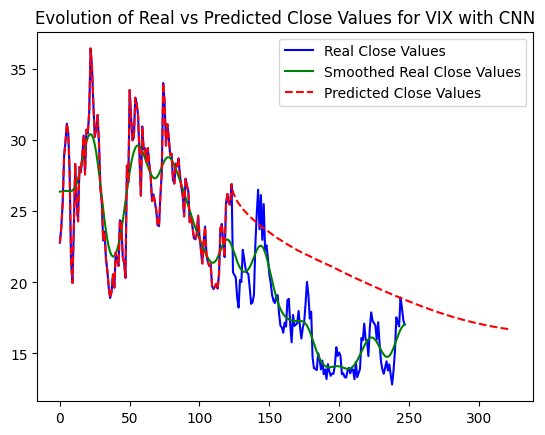

Feature: VIX - RMSE: 0.3460247829390149
Training for VIX with configuration rank 2
Epoch 1/1000
54/54 [==============================] - 25s 187ms/step - loss: 4.5253 - val_loss: 2.8185
Epoch 2/1000
54/54 [==============================] - 7s 120ms/step - loss: 2.2254 - val_loss: 1.6789
Epoch 3/1000
54/54 [==============================] - 6s 117ms/step - loss: 1.5484 - val_loss: 1.3038
Epoch 4/1000
54/54 [==============================] - 7s 121ms/step - loss: 1.2724 - val_loss: 1.0861
Epoch 5/1000
54/54 [==============================] - 6s 117ms/step - loss: 1.0502 - val_loss: 0.9106
Epoch 6/1000
54/54 [==============================] - 6s 119ms/step - loss: 0.8893 - val_loss: 0.7751
Epoch 7/1000
54/54 [==============================] - 6s 115ms/step - loss: 0.7748 - val_loss: 0.6511
Epoch 8/1000
54/54 [==============================] - 6s 116ms/step - loss: 0.6716 - val_loss: 0.5508
Epoch 9/1000
54/54 [==============================] - 6s 118ms/step - loss: 0.5618 - val_loss: 0.460

Epoch 80/1000
54/54 [==============================] - 6s 119ms/step - loss: 0.0984 - val_loss: 0.0534
Epoch 81/1000
54/54 [==============================] - 6s 119ms/step - loss: 0.0938 - val_loss: 0.0518
Epoch 82/1000
54/54 [==============================] - 6s 117ms/step - loss: 0.0949 - val_loss: 0.0573
Epoch 83/1000
54/54 [==============================] - 6s 119ms/step - loss: 0.0984 - val_loss: 0.0557
Epoch 84/1000
54/54 [==============================] - 6s 120ms/step - loss: 0.0942 - val_loss: 0.0550
Epoch 85/1000
54/54 [==============================] - 6s 119ms/step - loss: 0.0977 - val_loss: 0.0504
Epoch 86/1000
54/54 [==============================] - 6s 119ms/step - loss: 0.0936 - val_loss: 0.0561
Epoch 87/1000
54/54 [==============================] - 6s 117ms/step - loss: 0.0951 - val_loss: 0.0640
Epoch 88/1000
54/54 [==============================] - 6s 119ms/step - loss: 0.0939 - val_loss: 0.0525
Epoch 89/1000
54/54 [==============================] - 6s 118ms/step - lo

Epoch 159/1000
54/54 [==============================] - 6s 119ms/step - loss: 0.0901 - val_loss: 0.0754
Epoch 160/1000
54/54 [==============================] - 7s 125ms/step - loss: 2.4943 - val_loss: 1.9122
Epoch 161/1000
54/54 [==============================] - 7s 125ms/step - loss: 2.3799 - val_loss: 1.1548
Epoch 162/1000
54/54 [==============================] - 7s 121ms/step - loss: 1.8971 - val_loss: 0.8663
Epoch 163/1000
54/54 [==============================] - 7s 123ms/step - loss: 1.6592 - val_loss: 0.6947
Epoch 164/1000
54/54 [==============================] - 7s 124ms/step - loss: 1.5227 - val_loss: 0.5526
Epoch 165/1000
54/54 [==============================] - 7s 125ms/step - loss: 1.4333 - val_loss: 0.5134
Epoch 166/1000
54/54 [==============================] - 7s 127ms/step - loss: 1.3662 - val_loss: 0.4166
Epoch 167/1000
54/54 [==============================] - 7s 124ms/step - loss: 1.3040 - val_loss: 0.4101
Epoch 168/1000
54/54 [==============================] - 6s 119ms

1/1 [==============================] - 0s 85ms/step


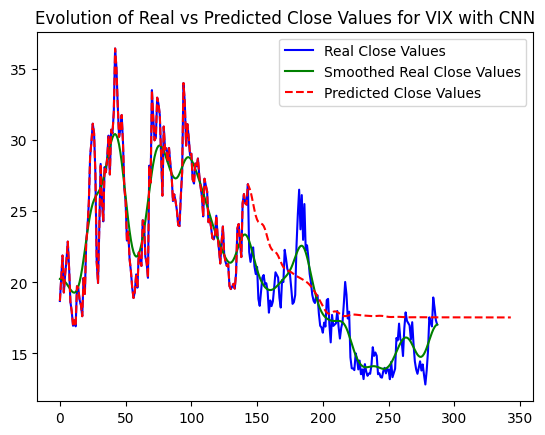

Feature: VIX - RMSE: 0.27013065685913423
Training for VIX with configuration rank 3
Epoch 1/1000
54/54 [==============================] - 22s 167ms/step - loss: 1.7122 - val_loss: 1.1672
Epoch 2/1000
54/54 [==============================] - 6s 111ms/step - loss: 1.1163 - val_loss: 0.8754
Epoch 3/1000
54/54 [==============================] - 6s 107ms/step - loss: 0.8673 - val_loss: 0.7192
Epoch 4/1000
54/54 [==============================] - 6s 107ms/step - loss: 0.7215 - val_loss: 0.5965
Epoch 5/1000
54/54 [==============================] - 6s 107ms/step - loss: 0.6376 - val_loss: 0.5177
Epoch 6/1000
54/54 [==============================] - 6s 108ms/step - loss: 0.5429 - val_loss: 0.4602
Epoch 7/1000
54/54 [==============================] - 6s 107ms/step - loss: 0.4939 - val_loss: 0.4151
Epoch 8/1000
54/54 [==============================] - 6s 108ms/step - loss: 0.4570 - val_loss: 0.3809
Epoch 9/1000
54/54 [==============================] - 6s 106ms/step - loss: 0.4213 - val_loss: 0.37

Epoch 80/1000
54/54 [==============================] - 6s 107ms/step - loss: 0.0765 - val_loss: 0.0478
Epoch 81/1000
54/54 [==============================] - 6s 108ms/step - loss: 0.0875 - val_loss: 0.0519
Epoch 82/1000
54/54 [==============================] - 6s 109ms/step - loss: 0.0823 - val_loss: 0.0396
Epoch 83/1000
54/54 [==============================] - 6s 108ms/step - loss: 0.0811 - val_loss: 0.0447
Epoch 84/1000
54/54 [==============================] - 6s 109ms/step - loss: 0.0791 - val_loss: 0.0409
Epoch 85/1000
54/54 [==============================] - 6s 108ms/step - loss: 0.0809 - val_loss: 0.0380
Epoch 86/1000
54/54 [==============================] - 6s 108ms/step - loss: 0.0746 - val_loss: 0.0372
Epoch 87/1000
54/54 [==============================] - 6s 106ms/step - loss: 0.0725 - val_loss: 0.0378
Epoch 88/1000
54/54 [==============================] - 6s 108ms/step - loss: 0.0726 - val_loss: 0.0360
Epoch 89/1000
54/54 [==============================] - 6s 106ms/step - lo

Epoch 159/1000
54/54 [==============================] - 6s 112ms/step - loss: 0.0641 - val_loss: 0.0356
Epoch 160/1000
54/54 [==============================] - 6s 106ms/step - loss: 0.0895 - val_loss: 0.0590
Epoch 161/1000
54/54 [==============================] - 6s 105ms/step - loss: 0.0926 - val_loss: 0.0463
Epoch 162/1000
54/54 [==============================] - 6s 105ms/step - loss: 0.0846 - val_loss: 0.0418
Epoch 163/1000
54/54 [==============================] - 6s 106ms/step - loss: 0.0723 - val_loss: 0.0431
Epoch 164/1000
54/54 [==============================] - 6s 105ms/step - loss: 0.0654 - val_loss: 0.0340
Epoch 165/1000
54/54 [==============================] - 6s 106ms/step - loss: 0.0667 - val_loss: 0.0356
Epoch 166/1000
54/54 [==============================] - 6s 104ms/step - loss: 0.0654 - val_loss: 0.0334
Epoch 167/1000
54/54 [==============================] - 6s 105ms/step - loss: 0.0657 - val_loss: 0.0350
Epoch 168/1000
54/54 [==============================] - 6s 105ms

Epoch 238/1000
54/54 [==============================] - 6s 114ms/step - loss: 0.1026 - val_loss: 0.0707
Epoch 239/1000
1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 86ms/step


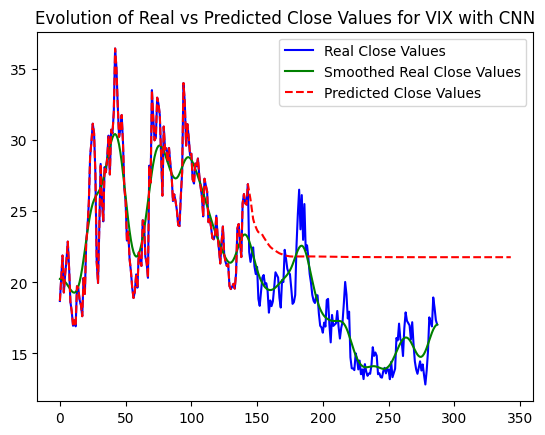

Feature: VIX - RMSE: 0.34049432130544804
Training for VIX with configuration rank 4
Epoch 1/1000
54/54 [==============================] - 21s 169ms/step - loss: 3.1924 - val_loss: 2.4456
Epoch 2/1000
54/54 [==============================] - 6s 113ms/step - loss: 2.2224 - val_loss: 1.8181
Epoch 3/1000
54/54 [==============================] - 6s 109ms/step - loss: 1.7449 - val_loss: 1.4554
Epoch 4/1000
54/54 [==============================] - 6s 108ms/step - loss: 1.4367 - val_loss: 1.2073
Epoch 5/1000
54/54 [==============================] - 6s 107ms/step - loss: 1.2852 - val_loss: 1.0993
Epoch 6/1000
54/54 [==============================] - 6s 107ms/step - loss: 1.1431 - val_loss: 0.9632
Epoch 7/1000
54/54 [==============================] - 6s 109ms/step - loss: 0.9812 - val_loss: 0.8407
Epoch 8/1000
54/54 [==============================] - 6s 107ms/step - loss: 0.8885 - val_loss: 0.8148
Epoch 9/1000
54/54 [==============================] - 6s 109ms/step - loss: 0.8163 - val_loss: 0.71

Epoch 80/1000
54/54 [==============================] - 6s 105ms/step - loss: 0.0905 - val_loss: 0.0434
Epoch 81/1000
54/54 [==============================] - 6s 105ms/step - loss: 0.0871 - val_loss: 0.0485
Epoch 82/1000
54/54 [==============================] - 5s 101ms/step - loss: 0.0822 - val_loss: 0.0420
Epoch 83/1000
54/54 [==============================] - 6s 106ms/step - loss: 0.0850 - val_loss: 0.0413
Epoch 84/1000
54/54 [==============================] - 6s 106ms/step - loss: 0.0844 - val_loss: 0.0452
Epoch 85/1000
54/54 [==============================] - 6s 109ms/step - loss: 0.0779 - val_loss: 0.0403
Epoch 86/1000
54/54 [==============================] - 6s 111ms/step - loss: 0.0818 - val_loss: 0.0382
Epoch 87/1000
54/54 [==============================] - 6s 107ms/step - loss: 0.0786 - val_loss: 0.0443
Epoch 88/1000
54/54 [==============================] - 6s 109ms/step - loss: 0.0898 - val_loss: 0.0629
Epoch 89/1000
54/54 [==============================] - 6s 107ms/step - lo

Epoch 159/1000
54/54 [==============================] - 6s 108ms/step - loss: 0.0664 - val_loss: 0.0339
Epoch 160/1000
54/54 [==============================] - 6s 113ms/step - loss: 0.0732 - val_loss: 0.0376
Epoch 161/1000
54/54 [==============================] - 6s 109ms/step - loss: 0.0699 - val_loss: 0.0365
Epoch 162/1000
54/54 [==============================] - 6s 103ms/step - loss: 0.0847 - val_loss: 0.0415
Epoch 163/1000
54/54 [==============================] - 6s 107ms/step - loss: 0.0806 - val_loss: 0.0392
Epoch 164/1000
54/54 [==============================] - 6s 105ms/step - loss: 0.0805 - val_loss: 0.0419
Epoch 165/1000
54/54 [==============================] - 6s 108ms/step - loss: 0.0714 - val_loss: 0.0387
Epoch 166/1000
54/54 [==============================] - 6s 107ms/step - loss: 0.0737 - val_loss: 0.0362
Epoch 167/1000
54/54 [==============================] - 6s 107ms/step - loss: 0.0724 - val_loss: 0.0441
Epoch 168/1000
54/54 [==============================] - 6s 106ms

Epoch 238/1000
54/54 [==============================] - 7s 130ms/step - loss: 0.0615 - val_loss: 0.0362
Epoch 239/1000
54/54 [==============================] - 7s 126ms/step - loss: 0.0635 - val_loss: 0.0340
Epoch 240/1000
54/54 [==============================] - 7s 127ms/step - loss: 0.0621 - val_loss: 0.0374
Epoch 241/1000
54/54 [==============================] - 7s 126ms/step - loss: 0.0641 - val_loss: 0.0362
Epoch 242/1000
54/54 [==============================] - 6s 116ms/step - loss: 0.0632 - val_loss: 0.0430
Epoch 243/1000
54/54 [==============================] - 7s 130ms/step - loss: 0.0644 - val_loss: 0.0379
Epoch 244/1000
54/54 [==============================] - 7s 127ms/step - loss: 0.0617 - val_loss: 0.0343
Epoch 245/1000
54/54 [==============================] - 7s 127ms/step - loss: 0.0614 - val_loss: 0.0355
Epoch 246/1000
54/54 [==============================] - 6s 113ms/step - loss: 0.0738 - val_loss: 0.0417
Epoch 247/1000
54/54 [==============================] - 6s 107ms

1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


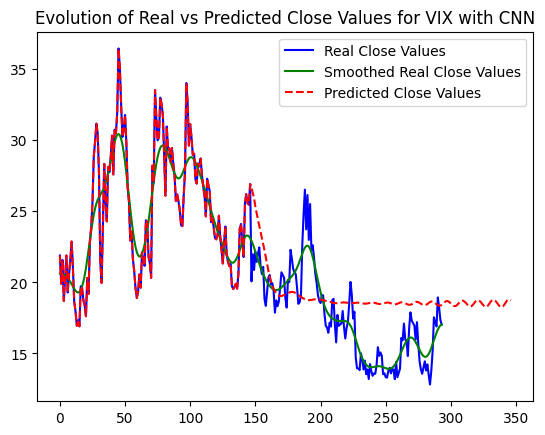

Feature: VIX - RMSE: 0.23742537472915692
Training for VIX with configuration rank 5
Epoch 1/1000
54/54 [==============================] - 22s 203ms/step - loss: 3.0440 - val_loss: 2.0051
Epoch 2/1000
54/54 [==============================] - 7s 127ms/step - loss: 1.6854 - val_loss: 1.3022
Epoch 3/1000
54/54 [==============================] - 7s 125ms/step - loss: 1.2129 - val_loss: 1.0135
Epoch 4/1000
54/54 [==============================] - 7s 125ms/step - loss: 0.9992 - val_loss: 0.8676
Epoch 5/1000
54/54 [==============================] - 7s 127ms/step - loss: 0.9046 - val_loss: 0.7786
Epoch 6/1000
54/54 [==============================] - 7s 126ms/step - loss: 0.8173 - val_loss: 0.7187
Epoch 7/1000
54/54 [==============================] - 7s 126ms/step - loss: 0.7414 - val_loss: 0.6318
Epoch 8/1000
54/54 [==============================] - 7s 123ms/step - loss: 0.6701 - val_loss: 0.5661
Epoch 9/1000
54/54 [==============================] - 7s 123ms/step - loss: 0.5900 - val_loss: 0.51

Epoch 80/1000
54/54 [==============================] - 8s 145ms/step - loss: 0.0905 - val_loss: 0.0439
Epoch 81/1000
54/54 [==============================] - 7s 139ms/step - loss: 8.0122 - val_loss: 3.2503
Epoch 82/1000
54/54 [==============================] - 7s 134ms/step - loss: 5.4613 - val_loss: 4.0364
Epoch 83/1000
54/54 [==============================] - 7s 137ms/step - loss: 5.0188 - val_loss: 4.0897
Epoch 84/1000
54/54 [==============================] - 7s 137ms/step - loss: 4.9256 - val_loss: 3.9941
Epoch 85/1000
54/54 [==============================] - 8s 146ms/step - loss: 4.6384 - val_loss: 4.0988
Epoch 86/1000
54/54 [==============================] - 7s 132ms/step - loss: 4.4993 - val_loss: 3.9549
Epoch 87/1000
54/54 [==============================] - 7s 122ms/step - loss: 4.4129 - val_loss: 3.9067
Epoch 88/1000
54/54 [==============================] - 7s 122ms/step - loss: 4.3807 - val_loss: 3.8495
Epoch 89/1000
54/54 [==============================] - 7s 124ms/step - lo

1/1 [==============================] - 0s 88ms/step


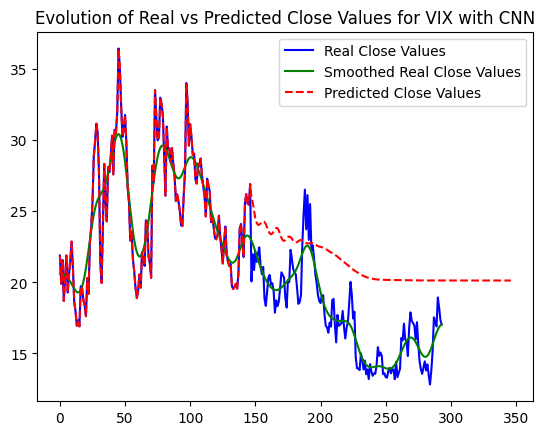

Feature: VIX - RMSE: 0.3101180987592314
Le meilleur modèle unique est meilleur pour l'indice VIX. RMSE: 0.23742537472915692
5/5 [==============================] - 0s 55ms/step
Training for FVX with configuration rank 1
Epoch 1/1000
54/54 [==============================] - 23s 186ms/step - loss: 5.3230 - val_loss: 3.2153
Epoch 2/1000
54/54 [==============================] - 7s 126ms/step - loss: 2.4820 - val_loss: 1.9949
Epoch 3/1000
54/54 [==============================] - 7s 124ms/step - loss: 1.7469 - val_loss: 1.5380
Epoch 4/1000
54/54 [==============================] - 6s 120ms/step - loss: 1.3826 - val_loss: 1.2483
Epoch 5/1000
54/54 [==============================] - 6s 119ms/step - loss: 1.1238 - val_loss: 1.0153
Epoch 6/1000
54/54 [==============================] - 7s 124ms/step - loss: 0.9208 - val_loss: 0.8351
Epoch 7/1000
54/54 [==============================] - 7s 122ms/step - loss: 0.7558 - val_loss: 0.6869
Epoch 8/1000
54/54 [==============================] - 7s 122ms/ste

54/54 [==============================] - 7s 124ms/step - loss: 0.0141 - val_loss: 0.0151
Epoch 79/1000
54/54 [==============================] - 7s 122ms/step - loss: 0.0140 - val_loss: 0.0154
Epoch 80/1000
54/54 [==============================] - 6s 119ms/step - loss: 0.0142 - val_loss: 0.0189
Epoch 81/1000
54/54 [==============================] - 6s 120ms/step - loss: 0.0139 - val_loss: 0.0150
Epoch 82/1000
54/54 [==============================] - 6s 118ms/step - loss: 0.0145 - val_loss: 0.0152
Epoch 83/1000
54/54 [==============================] - 6s 120ms/step - loss: 0.0137 - val_loss: 0.0156
Epoch 84/1000
54/54 [==============================] - 7s 122ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 85/1000
54/54 [==============================] - 7s 123ms/step - loss: 0.0141 - val_loss: 0.0150
Epoch 86/1000
54/54 [==============================] - 7s 122ms/step - loss: 0.0146 - val_loss: 0.0151
Epoch 87/1000
54/54 [==============================] - 7s 122ms/step - loss: 0.0143 - v

1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 88ms/step


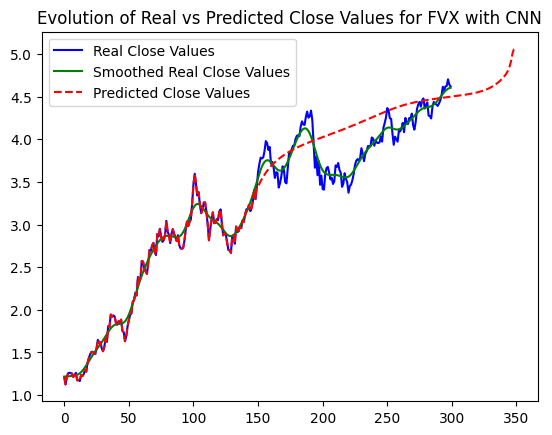

Feature: FVX - RMSE: 0.2255065016441617
Training for FVX with configuration rank 2
Epoch 1/1000
54/54 [==============================] - 19s 171ms/step - loss: 16.9367 - val_loss: 8.2704
Epoch 2/1000
54/54 [==============================] - 7s 129ms/step - loss: 6.3383 - val_loss: 5.0360
Epoch 3/1000
54/54 [==============================] - 7s 127ms/step - loss: 4.2858 - val_loss: 3.6158
Epoch 4/1000
54/54 [==============================] - 7s 125ms/step - loss: 3.1268 - val_loss: 2.6859
Epoch 5/1000
54/54 [==============================] - 7s 127ms/step - loss: 2.3313 - val_loss: 2.0111
Epoch 6/1000
54/54 [==============================] - 7s 128ms/step - loss: 1.7607 - val_loss: 1.5353
Epoch 7/1000
54/54 [==============================] - 7s 128ms/step - loss: 1.3452 - val_loss: 1.1749
Epoch 8/1000
54/54 [==============================] - 7s 130ms/step - loss: 1.0383 - val_loss: 0.9198
Epoch 9/1000
54/54 [==============================] - 7s 130ms/step - loss: 0.8077 - val_loss: 0.72

1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 71ms/step


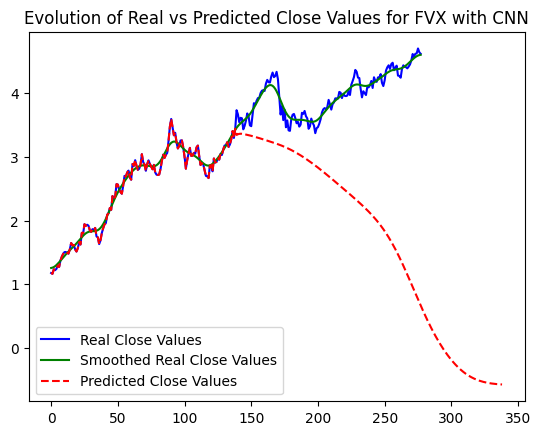

Feature: FVX - RMSE: 1.0082839692394852
Training for FVX with configuration rank 3
Epoch 1/1000
54/54 [==============================] - 26s 214ms/step - loss: 7.6814 - val_loss: 4.7850
Epoch 2/1000
54/54 [==============================] - 8s 152ms/step - loss: 3.8172 - val_loss: 3.3405
Epoch 3/1000
54/54 [==============================] - 8s 150ms/step - loss: 2.8059 - val_loss: 2.4763
Epoch 4/1000
54/54 [==============================] - 8s 147ms/step - loss: 2.2439 - val_loss: 2.0262
Epoch 5/1000
54/54 [==============================] - 8s 147ms/step - loss: 1.8319 - val_loss: 1.6506
Epoch 6/1000
54/54 [==============================] - 8s 149ms/step - loss: 1.5008 - val_loss: 1.3877
Epoch 7/1000
54/54 [==============================] - 8s 148ms/step - loss: 1.2392 - val_loss: 1.1288
Epoch 8/1000
54/54 [==============================] - 9s 163ms/step - loss: 1.0326 - val_loss: 0.9405
Epoch 9/1000
54/54 [==============================] - 9s 172ms/step - loss: 0.8781 - val_loss: 0.816

Epoch 80/1000
54/54 [==============================] - 8s 149ms/step - loss: 0.0495 - val_loss: 0.0554
Epoch 81/1000
54/54 [==============================] - 8s 151ms/step - loss: 0.0485 - val_loss: 0.0487
Epoch 82/1000
54/54 [==============================] - 8s 150ms/step - loss: 0.0488 - val_loss: 0.0580
Epoch 83/1000
54/54 [==============================] - 8s 151ms/step - loss: 0.0492 - val_loss: 0.0649
Epoch 84/1000
54/54 [==============================] - 8s 152ms/step - loss: 0.0494 - val_loss: 0.0493
Epoch 85/1000
54/54 [==============================] - 8s 149ms/step - loss: 0.0498 - val_loss: 0.0534
Epoch 86/1000
54/54 [==============================] - 8s 150ms/step - loss: 0.0493 - val_loss: 0.0698
Epoch 87/1000
54/54 [==============================] - 8s 149ms/step - loss: 0.0494 - val_loss: 0.0512
Epoch 88/1000
54/54 [==============================] - 8s 151ms/step - loss: 0.0484 - val_loss: 0.0498
Epoch 89/1000
54/54 [==============================] - 8s 148ms/step - lo

1/1 [==============================] - 0s 92ms/step


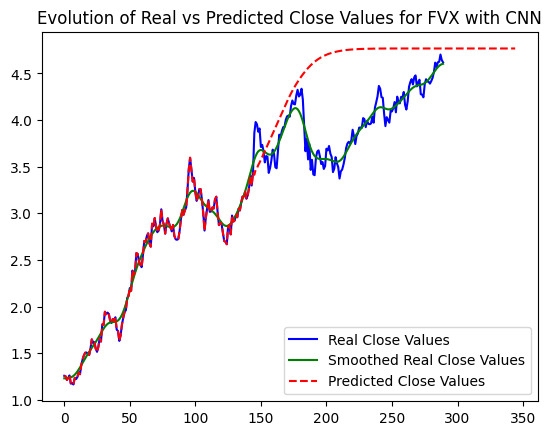

Feature: FVX - RMSE: 0.3340272235977967
Training for FVX with configuration rank 4
Epoch 1/1000
54/54 [==============================] - 23s 185ms/step - loss: 12.6067 - val_loss: 4.8643
Epoch 2/1000
54/54 [==============================] - 7s 133ms/step - loss: 3.0334 - val_loss: 1.8134
Epoch 3/1000
54/54 [==============================] - 7s 129ms/step - loss: 1.2541 - val_loss: 0.8198
Epoch 4/1000
54/54 [==============================] - 7s 130ms/step - loss: 0.6594 - val_loss: 0.5223
Epoch 5/1000
54/54 [==============================] - 7s 131ms/step - loss: 0.3657 - val_loss: 0.2584
Epoch 6/1000
54/54 [==============================] - 7s 132ms/step - loss: 0.1961 - val_loss: 0.1597
Epoch 7/1000
54/54 [==============================] - 8s 145ms/step - loss: 0.1286 - val_loss: 0.1078
Epoch 8/1000
54/54 [==============================] - 8s 146ms/step - loss: 0.1002 - val_loss: 0.0954
Epoch 9/1000
54/54 [==============================] - 7s 136ms/step - loss: 0.0763 - val_loss: 0.12

1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 95ms/step


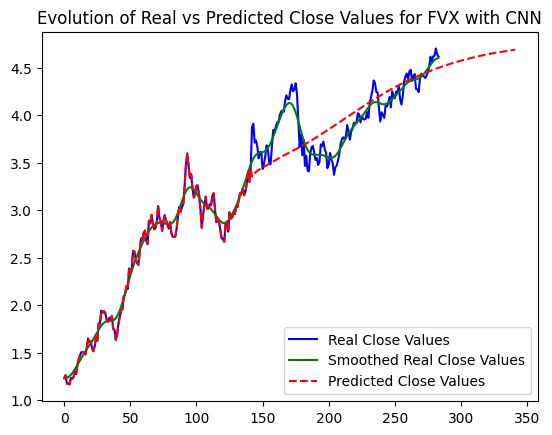

Feature: FVX - RMSE: 0.2202526655667772
Training for FVX with configuration rank 5
Epoch 1/1000
54/54 [==============================] - 26s 250ms/step - loss: 19.5738 - val_loss: 5.0144
Epoch 2/1000
54/54 [==============================] - 7s 118ms/step - loss: 2.2596 - val_loss: 0.8381
Epoch 3/1000
54/54 [==============================] - 6s 118ms/step - loss: 0.4849 - val_loss: 0.2578
Epoch 4/1000
54/54 [==============================] - 6s 118ms/step - loss: 0.1638 - val_loss: 0.1345
Epoch 5/1000
54/54 [==============================] - 7s 127ms/step - loss: 0.0821 - val_loss: 0.0905
Epoch 6/1000
54/54 [==============================] - 6s 117ms/step - loss: 0.0562 - val_loss: 0.0822
Epoch 7/1000
54/54 [==============================] - 6s 120ms/step - loss: 0.0506 - val_loss: 0.0357
Epoch 8/1000
54/54 [==============================] - 6s 117ms/step - loss: 0.0372 - val_loss: 0.0348
Epoch 9/1000
54/54 [==============================] - 7s 121ms/step - loss: 0.0330 - val_loss: 0.02

Epoch 80/1000
54/54 [==============================] - 6s 119ms/step - loss: 1.1708 - val_loss: 1.4845
Epoch 81/1000
54/54 [==============================] - 7s 126ms/step - loss: 0.9866 - val_loss: 1.3889
Epoch 82/1000
54/54 [==============================] - 7s 122ms/step - loss: 2.0198 - val_loss: 3.8343
Epoch 83/1000
54/54 [==============================] - 7s 121ms/step - loss: 2.5874 - val_loss: 2.4955
Epoch 84/1000
54/54 [==============================] - 6s 120ms/step - loss: 1.7905 - val_loss: 1.9658
Epoch 85/1000
54/54 [==============================] - 6s 120ms/step - loss: 1.4218 - val_loss: 1.7146
Epoch 86/1000
54/54 [==============================] - 6s 119ms/step - loss: 1.1968 - val_loss: 1.6189
Epoch 87/1000
54/54 [==============================] - 6s 119ms/step - loss: 1.0481 - val_loss: 1.7779
Epoch 88/1000
54/54 [==============================] - 6s 119ms/step - loss: 0.9316 - val_loss: 1.7369
Epoch 89/1000
54/54 [==============================] - 6s 120ms/step - lo

1/1 [==============================] - 0s 103ms/step


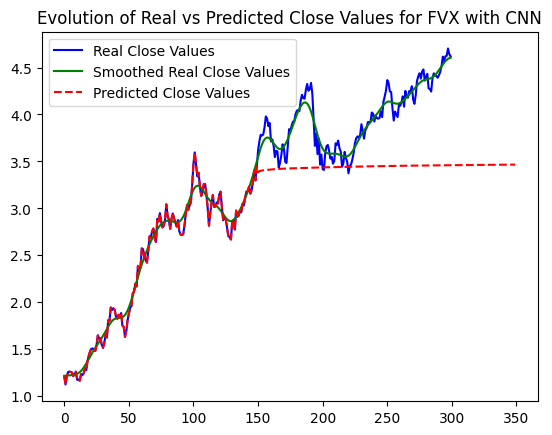

Feature: FVX - RMSE: 0.17364358245194123
Le meilleur modèle unique est meilleur pour l'indice FVX. RMSE: 0.17364358245194123
5/5 [==============================] - 1s 102ms/step
Training for NVDA with configuration rank 1
Epoch 1/1000
54/54 [==============================] - 21s 205ms/step - loss: 2669.6409 - val_loss: 396.2058
Epoch 2/1000
54/54 [==============================] - 8s 154ms/step - loss: 117.6900 - val_loss: 55.8086
Epoch 3/1000
54/54 [==============================] - 7s 138ms/step - loss: 31.2787 - val_loss: 81.7011
Epoch 4/1000
54/54 [==============================] - 8s 153ms/step - loss: 27.7393 - val_loss: 80.4464
Epoch 5/1000
54/54 [==============================] - 8s 140ms/step - loss: 27.1635 - val_loss: 79.0207
Epoch 6/1000
54/54 [==============================] - 8s 139ms/step - loss: 26.9748 - val_loss: 78.1861
Epoch 7/1000
54/54 [==============================] - 7s 137ms/step - loss: 26.9532 - val_loss: 78.9009
Epoch 8/1000
54/54 [=========================

1/1 [==============================] - 0s 96ms/step


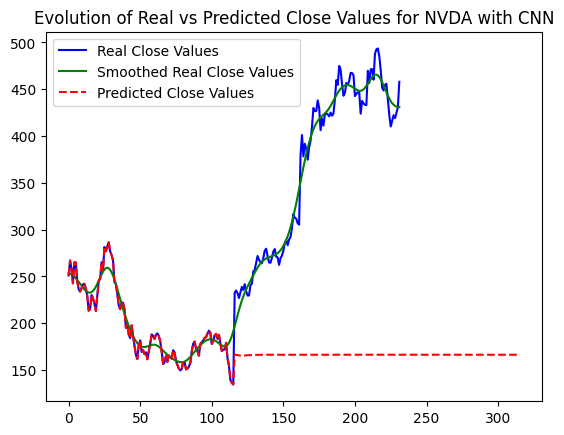

Feature: NVDA - RMSE: 2.6657900238082535
Training for NVDA with configuration rank 2
Epoch 1/1000
53/53 [==============================] - 18s 178ms/step - loss: 4403.2949 - val_loss: 629.2303
Epoch 2/1000
53/53 [==============================] - 7s 139ms/step - loss: 186.7875 - val_loss: 113.1737
Epoch 3/1000
53/53 [==============================] - 7s 138ms/step - loss: 53.0370 - val_loss: 102.5654
Epoch 4/1000
53/53 [==============================] - 7s 138ms/step - loss: 51.2764 - val_loss: 103.5783
Epoch 5/1000
53/53 [==============================] - 7s 140ms/step - loss: 51.3048 - val_loss: 103.6673
Epoch 6/1000
53/53 [==============================] - 8s 155ms/step - loss: 51.2292 - val_loss: 106.4421
Epoch 7/1000
53/53 [==============================] - 8s 155ms/step - loss: 51.2301 - val_loss: 105.6232
Epoch 8/1000
53/53 [==============================] - 8s 153ms/step - loss: 51.2103 - val_loss: 107.1608
Epoch 9/1000
53/53 [==============================] - 8s 153ms/step - l

1/1 [==============================] - 0s 90ms/step
Les prédictions sont constantes.


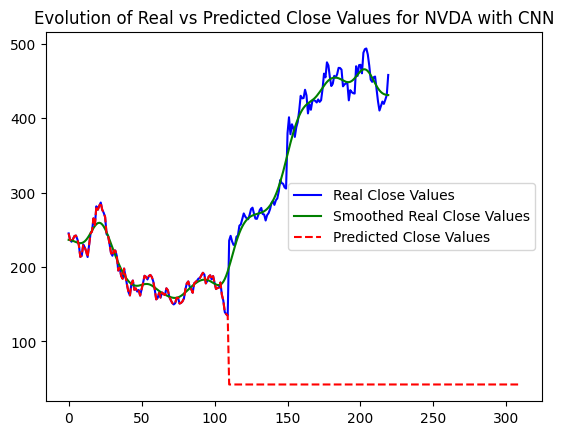

Feature: NVDA - RMSE: 4.547551703009416
Training for NVDA with configuration rank 3
Epoch 1/1000
53/53 [==============================] - 22s 228ms/step - loss: 2903.2466 - val_loss: 458.9385
Epoch 2/1000
53/53 [==============================] - 9s 162ms/step - loss: 134.1653 - val_loss: 91.7939
Epoch 3/1000
53/53 [==============================] - 8s 157ms/step - loss: 31.2109 - val_loss: 84.3579
Epoch 4/1000
53/53 [==============================] - 8s 156ms/step - loss: 29.7312 - val_loss: 84.0808
Epoch 5/1000
53/53 [==============================] - 8s 157ms/step - loss: 29.7240 - val_loss: 84.3250
Epoch 6/1000
53/53 [==============================] - 8s 157ms/step - loss: 29.7089 - val_loss: 84.6191
Epoch 7/1000
53/53 [==============================] - 8s 156ms/step - loss: 29.6976 - val_loss: 86.2912
Epoch 8/1000
53/53 [==============================] - 8s 158ms/step - loss: 29.7147 - val_loss: 86.6191
Epoch 9/1000
53/53 [==============================] - 8s 158ms/step - loss: 29.

53/53 [==============================] - 9s 171ms/step - loss: 29.3207 - val_loss: 84.6155
Epoch 79/1000
53/53 [==============================] - 9s 172ms/step - loss: 29.3073 - val_loss: 84.3509
Epoch 80/1000
53/53 [==============================] - 9s 161ms/step - loss: 29.3078 - val_loss: 84.0387
Epoch 81/1000
53/53 [==============================] - 8s 160ms/step - loss: 29.3053 - val_loss: 84.3889
Epoch 82/1000
53/53 [==============================] - 9s 172ms/step - loss: 29.2985 - val_loss: 84.6329
Epoch 83/1000
53/53 [==============================] - 9s 165ms/step - loss: 29.2926 - val_loss: 84.2846
Epoch 84/1000
53/53 [==============================] - 9s 169ms/step - loss: 29.2840 - val_loss: 84.9584
Epoch 85/1000
53/53 [==============================] - 9s 161ms/step - loss: 29.2908 - val_loss: 85.0340
Epoch 86/1000
53/53 [==============================] - 8s 160ms/step - loss: 29.2826 - val_loss: 85.8829
Epoch 87/1000
53/53 [==============================] - 8s 159ms/step 

1/1 [==============================] - 0s 105ms/step
Les prédictions sont constantes.


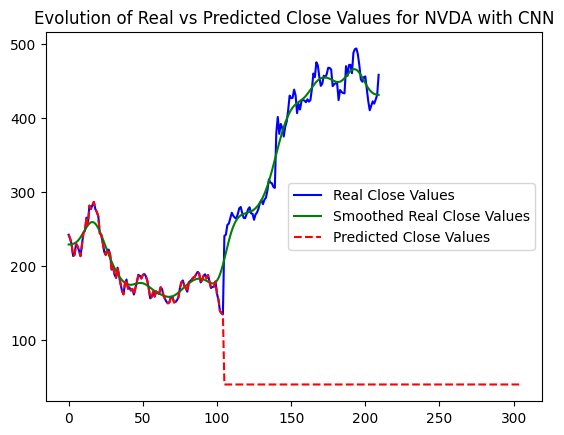

Feature: NVDA - RMSE: 4.70709692124669
Training for NVDA with configuration rank 4
Epoch 1/1000
53/53 [==============================] - 24s 235ms/step - loss: 4497.2393 - val_loss: 534.1014
Epoch 2/1000
53/53 [==============================] - 10s 184ms/step - loss: 155.1136 - val_loss: 111.1101
Epoch 3/1000
53/53 [==============================] - 10s 184ms/step - loss: 54.3062 - val_loss: 106.5907
Epoch 4/1000
53/53 [==============================] - 10s 184ms/step - loss: 52.9726 - val_loss: 105.7771
Epoch 5/1000
53/53 [==============================] - 10s 197ms/step - loss: 52.9726 - val_loss: 107.3223
Epoch 6/1000
53/53 [==============================] - 11s 201ms/step - loss: 52.9166 - val_loss: 106.8689
Epoch 7/1000
53/53 [==============================] - 11s 201ms/step - loss: 52.8947 - val_loss: 106.2351
Epoch 8/1000
53/53 [==============================] - 11s 204ms/step - loss: 52.8723 - val_loss: 105.4213
Epoch 9/1000
53/53 [==============================] - 11s 207ms/st

1/1 [==============================] - 0s 118ms/step
Les prédictions sont constantes.


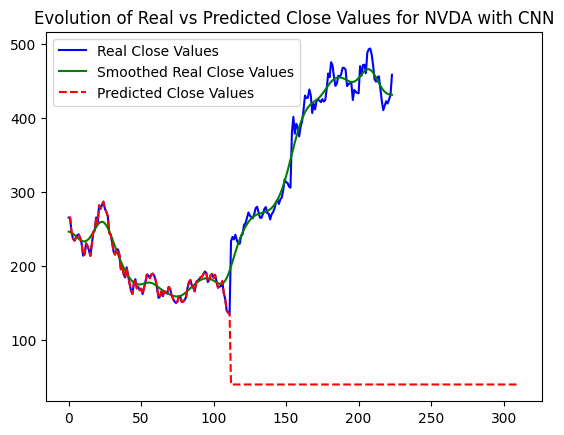

Feature: NVDA - RMSE: 4.5375700018167535
Training for NVDA with configuration rank 5
Epoch 1/1000
54/54 [==============================] - 21s 202ms/step - loss: 2859.7249 - val_loss: 411.2866
Epoch 2/1000
54/54 [==============================] - 8s 150ms/step - loss: 124.9935 - val_loss: 86.0125
Epoch 3/1000
54/54 [==============================] - 8s 154ms/step - loss: 30.4500 - val_loss: 80.3065
Epoch 4/1000
54/54 [==============================] - 8s 142ms/step - loss: 29.0611 - val_loss: 78.7788
Epoch 5/1000
54/54 [==============================] - 7s 139ms/step - loss: 29.0527 - val_loss: 82.0089
Epoch 6/1000
54/54 [==============================] - 7s 137ms/step - loss: 29.0503 - val_loss: 79.7854
Epoch 7/1000
54/54 [==============================] - 8s 139ms/step - loss: 29.0554 - val_loss: 81.2674
Epoch 8/1000
54/54 [==============================] - 8s 140ms/step - loss: 29.0311 - val_loss: 79.6969
Epoch 9/1000
54/54 [==============================] - 7s 137ms/step - loss: 29

1/1 [==============================] - 0s 83ms/step
Les prédictions sont constantes.


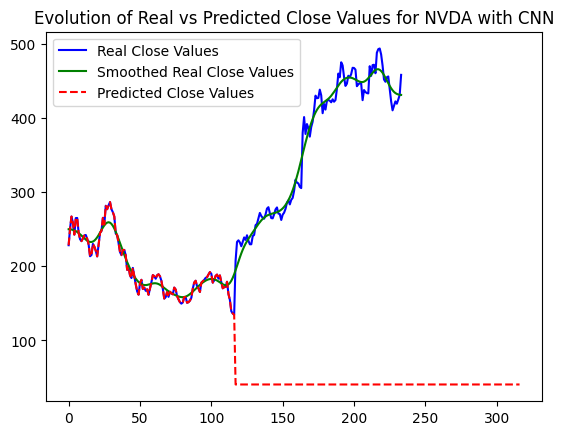

Feature: NVDA - RMSE: 4.401062792791957
Le meilleur modèle unique est meilleur pour l'indice NVDA. RMSE: 2.6657900238082535
4/4 [==============================] - 3s 147ms/step
Entraînement des modèles de réseau neuronal terminé.


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

def create_single_output_sequences(data, index_name, look_back=1):
    X, y = [], []
    feature_columns = ['Close']
    for i in range(look_back, len(data)):
        sequence_data = data.loc[data.index[i-look_back:i], [(index_name, col) for col in feature_columns]].values
        X.append(sequence_data)
        y.append(data.loc[data.index[i], [(index_name, 'Close')]].values[0])
    return np.array(X), np.array(y)

def recursive_prediction_multi_output(model, initial_input, steps):
    recursive_predictions = []  # Une liste pour stocker les prédictions à chaque étape
    current_input = initial_input.copy()  # Copie de l'entrée initiale pour éviter les modifications indésirables

    for i in range(steps):
        # Faire une prédiction pour le jour suivant en utilisant l'entrée actuelle
        predicted_values = model.predict(current_input.to_numpy().reshape(1, current_input.shape[0], current_input.shape[1]))
        
        # Ajouter ces prédictions à notre liste
        recursive_predictions.append(predicted_values[0])
        
        # Préparer l'entrée pour la prochaine prédiction
        # Supprimer la première valeur (jour le plus ancien)
        current_input = current_input.shift(-1)
        # Ajouter la nouvelle valeur prédite à la fin de l'entrée
        current_input.iloc[-1:] = pd.DataFrame(predicted_values)

    return np.array(recursive_predictions)

# Dictionnaires pour stocker les modèles et leurs performances
gru_models = {}
mse_gru = {}
recursive_preds_gru = {}
all_preds_gru = {}

for index_name in final_df.columns.get_level_values(0).unique():  # Parcourir chaque indice
    # Sélectionner hyperparamètre optimaux
    top_n_params = top_n_trials_per_feature[index_name]
    best_rmse = float('inf') 
    best_model = None
    all_predictions_for_index = []
    
    for rank, best_params in enumerate(top_n_params, 1):
        print(f"Training for {index_name} with configuration rank {rank}")
        look_back=best_params['look_back']

        # Créer des séquences pour l'entraînement et les tests
        X_train, y_train = create_single_output_sequences(train_data, index_name , look_back)
        X_test, y_test = create_single_output_sequences(test_data, index_name ,look_back)

        # Create the neural network model
        model = create_model(
            num_layers=best_params['num_layers'],
            units_per_layer=[2 ** (best_params[f'units_power_{i}']) for i in range(best_params['num_layers'])],
            layer_type=[best_params[f'layer_type_{i}'] for i in range(best_params['num_layers'])],
            dropout_per_layer=[best_params[f'dropout_{i}'] for i in range(best_params['num_layers'])],
            input_shape=(X_train.shape[1], 1),
            use_conv1d=best_params['use_conv1d'],
            conv1d_filters=2 ** best_params['conv1d_filters'] if best_params['use_conv1d'] else None,
            conv1d_kernel_size=best_params.get('conv1d_kernel_size', None),
            use_residual_connection=best_params['use_residual_connection'],
            attention_layer=best_params['use_attention_layer'],
            l1_reg=best_params['l1_reg'],
            l2_reg=best_params['l2_reg']
        )

        # Entraîner le modèle
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=64, callbacks=[early_stopping])

        # Évaluer le modèle

        # Initial input: X dernières observations du jeu de données d'entraînement
        initial_input = train_data[[(index_name, 'Close')]][-look_back:]

        # Prédictions récursives
        predictions = recursive_prediction_multi_output(model, initial_input, len(test_data))
        
        all_predictions_for_index.append(predictions)

        # Initialisation
        inverse_predictions = np.zeros_like(predictions)
        inverse_real_values = np.zeros_like(y_test)

        # Parcourir chaque caractéristique et chaque indice
        for idx, feature_name in enumerate(['Close']):
            scaler_key = (index_name, feature_name)  # Créer la clé pour accéder au bon scaler dans le dictionnaire
            feature_scaler = scalers_dict[scaler_key]  # Récupérer le scaler correspondant

            # Inverser la mise à l'échelle pour les prédictions et les valeurs réelles
            inverse_predictions = feature_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
            inverse_real_values_test = feature_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

            # Utilisez le scaler pour inverser la mise à l'échelle des dernières valeurs réelles de l'ensemble d'entraînement
            last_real_values_train_scaled = train_data[(index_name, 'Close')].iloc[-len(y_test):].values
            last_real_values_train = feature_scaler.inverse_transform(last_real_values_train_scaled.reshape(-1, 1)).flatten()

            # Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les vraies valeurs de l'ensemble de test
            real_values = np.concatenate([last_real_values_train, inverse_real_values_test])

            # Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les valeurs prédites
            predicted_values = np.concatenate([last_real_values_train, inverse_predictions])
            
            # Appliquer le filtre gaussien
            sigma = 5
            smoothed_values_test = gaussian_filter1d(y_test, sigma)
            smoothed_values = gaussian_filter1d(real_values, sigma)

            rmse = weighted_rmse(smoothed_values_test, np.array(predictions), len(smoothed_values_test))
            if np.std(predictions) > 1e-3:
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    
                    # Stockez les prédictions pour cette caractéristique
                    recursive_preds_gru[scaler_key] = inverse_predictions
            else:
                print("Les prédictions sont constantes.")
            
            plt.plot(real_values, label='Real Close Values', color='blue')
            plt.plot(smoothed_values, label='Smoothed Real Close Values', color='green')
            plt.plot(predicted_values, label='Predicted Close Values', color='red', linestyle='--')
            plt.title(f"Evolution of Real vs Predicted Close Values for {index_name} with CNN")
            plt.legend()
            plt.show()

            # Stocker le modèle et sa performance
            gru_models[scaler_key] = best_model
            mse_gru[scaler_key] = best_rmse
        print(f"Feature: {index_name} - RMSE: {rmse}")
    
    # Calculer la médiane des prédictions pour l'indice
    median_predictions = np.median(all_predictions_for_index, axis=0)
    # Évaluer la RMSE de la médiane des prédiction
    rmse_median = weighted_rmse(smoothed_values_test, np.array(median_predictions), len(smoothed_values_test))
    
        # Comparer la RMSE de la médiane avec la meilleure RMSE individuelle
    if rmse_median < best_rmse:
        print(f"La médiane des prédictions est meilleure pour l'indice {index_name}. RMSE: {rmse_median}")
        recursive_preds_gru[scaler_key] = feature_scaler.inverse_transform(median_predictions.reshape(-1, 1)).flatten()
        mse_gru[scaler_key] = rmse_median
        all_preds_gru[index_name] = median_predictions  # Stocker la médiane des prédictions
    else:
        print(f"Le meilleur modèle unique est meilleur pour l'indice {index_name}. RMSE: {best_rmse}")
        all_preds_gru[index_name] = feature_scaler.inverse_transform(np.array(best_model.predict(X_test)).reshape(-1, 1)).flatten()

print("Entraînement des modèles de réseau neuronal terminé.")

#### Modèle XGBoost:

In [18]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # Si les données sont une liste ou un tableau 1D, les convertir en DataFrame
    if type(data) is list or len(data.shape) == 1:
        df = pd.DataFrame(data)
        n_vars = 1
    else:
        df = pd.DataFrame(data)
        n_vars = data.shape[1]
    cols, names = list(), list()
    # Séquence d'entrée (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Séquence de prévision (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Concaténer le tout
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Supprimer les lignes avec des valeurs NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def recursive_prediction_xgb(model, initial_input, steps):
    current_input = np.array(initial_input)
    predictions = []
    for _ in range(steps):
        predicted_values = model.predict(current_input.reshape(1, -1))
        predictions.append(predicted_values)
        current_input = np.roll(current_input, -1)
        current_input[-1:] = predicted_values
    return np.array(predictions)

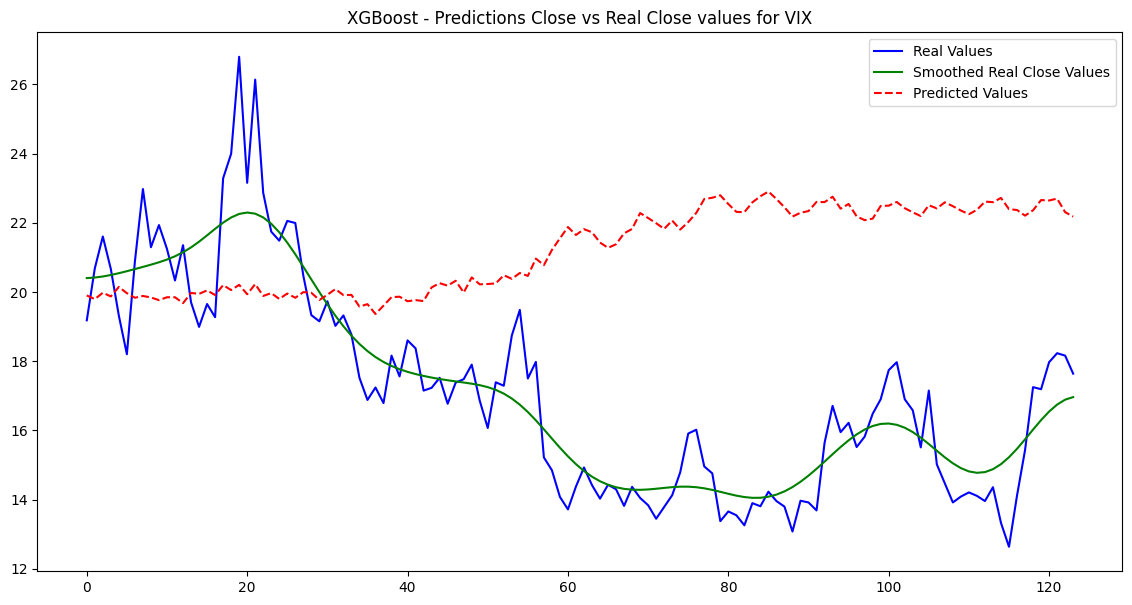

Feature: VIX - RMSE: 0.33508725473948536


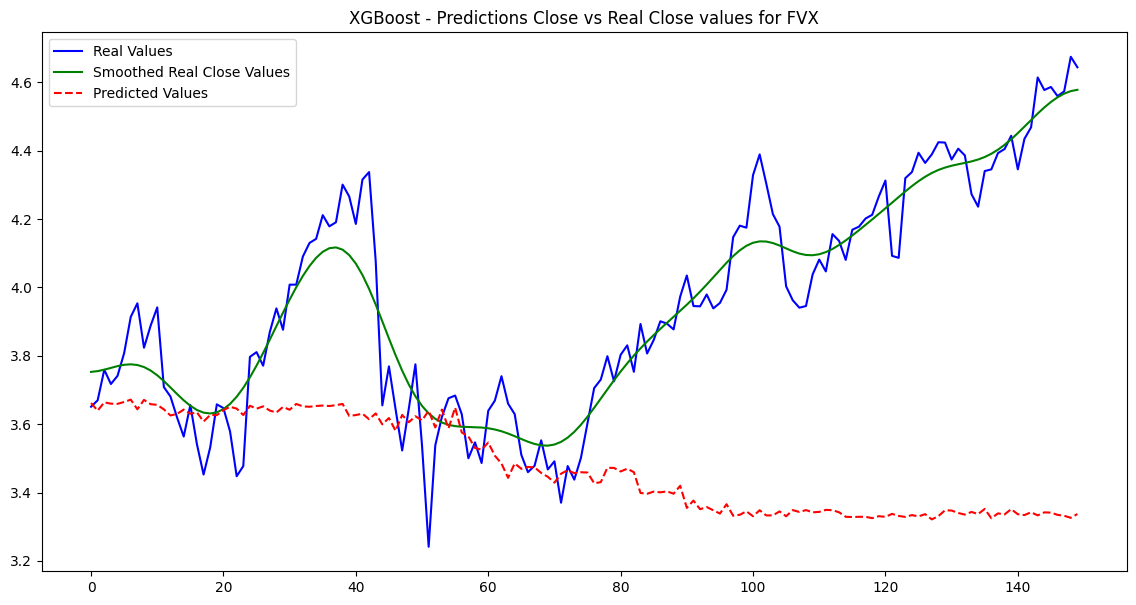

Feature: FVX - RMSE: 0.16641407278122136


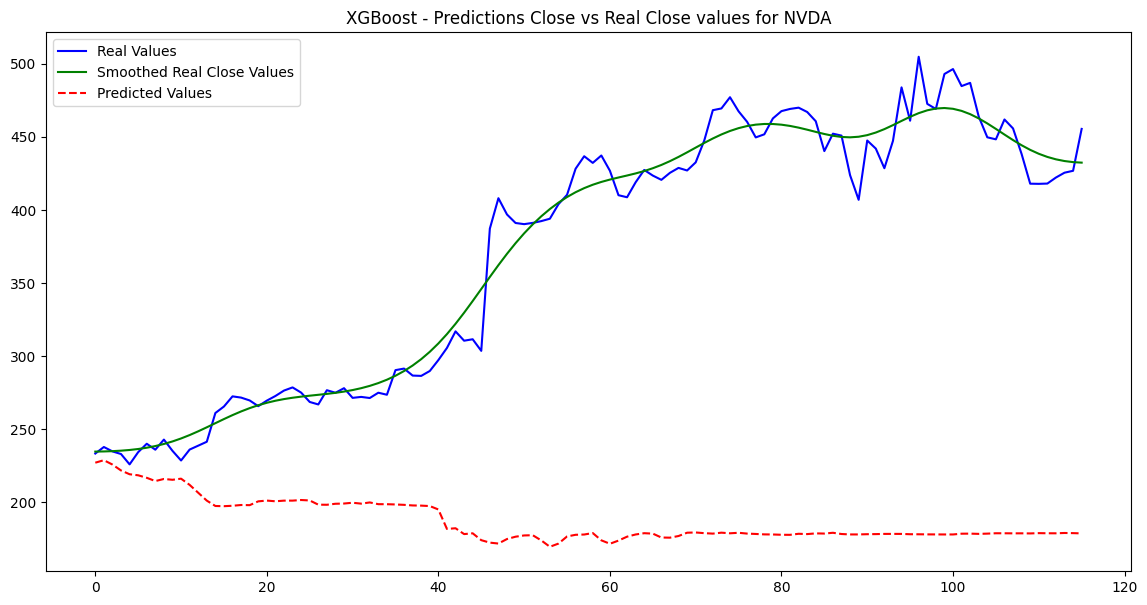

Feature: NVDA - RMSE: 2.4236344989175533
Entraînement des modèles XGBoost terminé.


In [19]:
# Dictionnaires pour stocker les modèles XGBoost et leurs performances
xgb_models = {}
mse_xgb = {}
recursive_preds_xgb = {}

for index_name in final_df.columns.get_level_values(0).unique():
    
    # Sélectionner look_back optimal
    best_params = best_params_per_feature[index_name]
    look_back = best_params['look_back']
    
    # Préparer les données pour XGBoost
    # Créer un indexeur
    idx = pd.IndexSlice

    # Utiliser cet indexeur pour récupérer les données
    values = scaled_data_df.filter(like=index_name, axis=1).values
    data = series_to_supervised(values, look_back, 1)
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    # Diviser en entrées et sorties
    
    X_train, y_train = train.iloc[:, :-1].values, train.iloc[:, -1].values
    X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1].values
    
    # Modèle XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200)
    model.fit(X_train, y_train)
    
    # Prédictions
    initial_input = X_test[0]
    predictions = recursive_prediction_xgb(model, initial_input, len(y_test))
    
    for idx, feature_name in enumerate(['Close']):
        scaler_key = (index_name, feature_name)  # Créer la clé pour accéder au bon scaler dans le dictionnaire
        feature_scaler = scalers_dict[scaler_key]  # Récupérer le scaler correspondant
    
        # Inversez la mise à l'échelle

        inverse_predictions = feature_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        inverse_real_values = feature_scaler.inverse_transform(y_test.reshape(-1, 1))
        
        # Appliquer le filtre gaussien
        sigma = 5
        smoothed_values_test = gaussian_filter1d(y_test, sigma)
        smoothed_values = gaussian_filter1d(y_test, sigma)
        smoothed_values_test = feature_scaler.inverse_transform(smoothed_values_test.reshape(-1, 1))
        # Afficher les graphiques
        plt.figure(figsize=(14,7))

        # Tracez les valeurs réelles
        plt.plot(inverse_real_values, label='Real Values', color='blue')
        
        plt.plot(smoothed_values_test, label='Smoothed Real Close Values', color='green')

        # Tracez les prédictions
        plt.plot(inverse_predictions, label='Predicted Values', color='red', linestyle='--')

        plt.title(f"XGBoost - Predictions Close vs Real Close values for {index_name}")
        plt.legend()
        plt.show()

        # Évaluer le modèle
        rmse = weighted_rmse(smoothed_values, np.array(predictions), len(smoothed_values))

        # Stocker le modèle et sa performance
        xgb_models[scaler_key] = model
        mse_xgb[scaler_key] = rmse
        recursive_preds_xgb[scaler_key] = inverse_predictions
        print(f"Feature: {index_name} - RMSE: {rmse}")

print("Entraînement des modèles XGBoost terminé.")

#### Modèle SARIMA:

In [20]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", "Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", "Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.")
"""# Dictionnaires pour stocker les modèles SARIMA et leurs performances
sarima_models = {}
mse_sarima = {}
recursive_preds_sarima = {}

for index_name in final_df.columns.get_level_values(0).unique():
    def objective_sarima(trial):
        # Paramètres à optimiser
        p = trial.suggest_int('p', 0, 5)
        d = trial.suggest_int('d', 0, 1)
        q = trial.suggest_int('q', 0, 4)
        P = trial.suggest_int('P', 0, 5)
        D = trial.suggest_int('D', 0, 1)
        Q = trial.suggest_int('Q', 0, 4)
        s = trial.suggest_int('s', 2, 12)  # saisonnalité

        # Validation des hyperparamètres
        if p == P:
            return float('inf')  # retourne une valeur infinie pour indiquer un mauvais essai

        try:
            # Création du modèle SARIMA
            sarima = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
            sarima_fit = sarima.fit(disp=False, maxiter=300, method='bfgs')

            # Prédictions
            predictions = sarima_fit.forecast(steps=len(y_test))
            
            if not np.std(predictions) > 1e-3:
                return float('inf')  # Rejeter le modèle si les prédictions sont constantes
            
            smoothed_values_test = gaussian_filter1d(y_test, sigma)

            # Calcul de la RMSE
            rmse = weighted_rmse(smoothed_values_test, predictions, len(smoothed_values_test))

            return rmse

        except Exception as e:  # Attrape toutes les exceptions, y compris les problèmes de convergence ou les erreurs de spécification du modèle
            return float('inf')  # retourne une valeur infinie pour indiquer un mauvais essai

    # Sélectionner look_back optimal
    best_params = best_params_per_feature[index_name]
    look_back = best_params['look_back']
    
    # Préparer les données pour XGBoost
    # Créer un indexeur
    idx = pd.IndexSlice

    # Utiliser cet indexeur pour récupérer les données
    values = scaled_data_df.filter(like=index_name, axis=1).values
    data = series_to_supervised(values, look_back, 1)
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    # Diviser en entrées et sorties
    
    X_train, y_train = train.iloc[:, :-1].values, train.iloc[:, -1].values
    X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1].values
    
    
    # Création d'une étude Optuna
    study_sarima = optuna.create_study(direction='minimize')
    study_sarima.optimize(objective_sarima, n_trials=50)
    
    best_params = study_sarima.best_params
    best_rmse = study_sarima.best_value

    # Modèle SARIMA avec les meilleurs hyperparamètres
    best_model = SARIMAX(y_train, 
                          order=(best_params['p'], best_params['d'], best_params['q']), 
                          seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['s']))
    best_model_fit = best_model.fit(disp=False, maxiter=200, method='bfgs')
    
    # Meilleures prédictions
    best_predictions = best_model_fit.forecast(steps=len(y_test))
    
    for idx, feature_name in enumerate(['Close']):
        scaler_key = (index_name, feature_name)  # Créer la clé pour accéder au bon scaler dans le dictionnaire
        feature_scaler = scalers_dict[scaler_key]  # Récupérer le scaler correspondant
        
        smoothed_values_test = feature_scaler.inverse_transform(smoothed_values_test.reshape(-1, 1))
    
        # Inversez la mise à l'échelle

        inverse_predictions = feature_scaler.inverse_transform(np.array(best_predictions).reshape(-1, 1))
        inverse_real_values = feature_scaler.inverse_transform(y_test.reshape(-1, 1))
        
        
        # Appliquer le filtre gaussien
        sigma = 5
        smoothed_values_test = gaussian_filter1d(y_test, sigma)
        smoothed_values = gaussian_filter1d(y_test, sigma)
        smoothed_values_test = feature_scaler.inverse_transform(smoothed_values_test.reshape(-1, 1))
        
        # Affichage des graphiques
        plt.figure(figsize=(14,7))
        plt.plot(inverse_real_values, label='Real Values', color='blue')
        plt.plot(smoothed_values_test, label='Smoothed Real Close Values', color='green')
        plt.plot(inverse_predictions, label='Predicted Values', color='red', linestyle='--')
        plt.title(f"SARIMA - Best Predictions vs Real values for {index_name}")
        plt.legend()
        plt.show()

        # Stocker le modèle et sa performance
        sarima_models[scaler_key] = best_model
        mse_sarima[scaler_key] = best_rmse
        recursive_preds_sarima[scaler_key] = inverse_predictions

        print(f"Feature: {index_name} - Best RMSE: {best_rmse}")
        
print("Entraînement des modèles SARIMA terminé.")
"""

'# Dictionnaires pour stocker les modèles SARIMA et leurs performances\nsarima_models = {}\nmse_sarima = {}\nrecursive_preds_sarima = {}\n\nfor index_name in final_df.columns.get_level_values(0).unique():\n    def objective_sarima(trial):\n        # Paramètres à optimiser\n        p = trial.suggest_int(\'p\', 0, 5)\n        d = trial.suggest_int(\'d\', 0, 1)\n        q = trial.suggest_int(\'q\', 0, 4)\n        P = trial.suggest_int(\'P\', 0, 5)\n        D = trial.suggest_int(\'D\', 0, 1)\n        Q = trial.suggest_int(\'Q\', 0, 4)\n        s = trial.suggest_int(\'s\', 2, 12)  # saisonnalité\n\n        # Validation des hyperparamètres\n        if p == P:\n            return float(\'inf\')  # retourne une valeur infinie pour indiquer un mauvais essai\n\n        try:\n            # Création du modèle SARIMA\n            sarima = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))\n            sarima_fit = sarima.fit(disp=False, maxiter=300, method=\'bfgs\')\n\n            # Pré

### Choix du modèle par features

In [21]:
features_choice_df = pd.DataFrame({"GRU": mse_gru, "XGBoost": mse_xgb})

best_model_per_feature = features_choice_df.idxmin(axis=1).to_frame(name='Best Model')
best_model_per_feature['MSE'] = features_choice_df.min(axis=1)


print(best_model_per_feature)

           Best Model       MSE
VIX  Close        GRU  0.237425
FVX  Close    XGBoost  0.166414
NVDA Close    XGBoost  2.423634


### Filtrage : comparaison avec un modèle naif

Ce n'est parce que un modèle est meilleurs que les autres qu'il est réellement pertinant, la comparaison avec un modèle naif/simpliste indiquera si le modèle est réelement performant (et pas seulement par rapport aux autres)

In [26]:
# Créer un dictionnaire avec les données de test pour chaque feature
test_data_dict = {}
for feature in scaled_data_df.columns:
    test_data_dict[feature] = test_data[feature]
    
# Dictionnaire pour regrouper toutes les prédictions récursives
all_recursive_preds = {
    'GRU': recursive_preds_gru,
    'XGBoost': recursive_preds_xgb,
}

def naive_recursive_forecast(series, steps):
    """Génère des prédictions récursives en utilisant la dernière valeur connue pour `steps` prédictions."""
    predictions = [series[-1]]  # on commence avec la dernière observation
    for _ in range(steps-1):
        predictions.append(predictions[-1])
    return np.array(predictions)

mse_naive_recursive_dict = {}

for index_name in final_df.columns.get_level_values(0).unique():
    
    # Récupérer les valeurs réelles de l'indice spécifique
    actual_values = test_data_dict[(index_name, 'Close')].values[1:]
    
    # Générer des prédictions naïves pour l'indice spécifique
    naive_predictions = naive_recursive_forecast(test_data_dict[(index_name, 'Close')].values[:-1], len(actual_values))
    
    # Calculer le MSE pour ces prédictions naïves
    mse_naive_recursive = mean_squared_error(actual_values, naive_predictions)
    
    # Stocker ce MSE dans le dictionnaire
    mse_naive_recursive_dict[index_name] = mse_naive_recursive
    
    # Récupérer les valeurs réelles, les prédictions du modèle et les prédictions naïves
    best_model_name = best_model_per_feature.loc[(index_name, 'Close'), 'Best Model']
    best_model_predictions = all_recursive_preds[best_model_name][(index_name, 'Close')]
    
    actual_values = data.values
    naive_predictions = naive_recursive_forecast(data.values[:-1], len(actual_values))

# Comparer les MSE des modèles et des prévisions naïves récursives
comparison_recursive_dict = {}
for feature, row in best_model_per_feature.iterrows():
    comparison_recursive_dict[feature] = {
        'Model MSE': row['MSE'],
        'Naive Recursive MSE': mse_naive_recursive_dict[feature[0]],
        'Model is Better': row['MSE'] < mse_naive_recursive_dict[feature[0]]
    }

comparison_recursive_dict

{('VIX', 'Close'): {'Model MSE': 0.23742537472915692,
  'Naive Recursive MSE': 0.3764809798073168,
  'Model is Better': True},
 ('FVX', 'Close'): {'Model MSE': 0.16641407278122136,
  'Naive Recursive MSE': 0.16752596192038507,
  'Model is Better': True},
 ('NVDA', 'Close'): {'Model MSE': 2.4236344989175533,
  'Naive Recursive MSE': 16.770856359106048,
  'Model is Better': True}}

### Conclusion sur les features finales

In [27]:
# Vérifier pour quelles features le modèle naïf est meilleur
naive_better_features = [feature for feature, values in comparison_recursive_dict.items() if not values['Model is Better']]

# Afficher un message d'avertissement pour ces features
if naive_better_features:
    print("Avertissement : Pour les features suivantes, le modèle naïf a performé mieux que le modèle choisi :")
    for feature in naive_better_features:
        print(f"- {feature}")

# Modèle final : basé sur les précédentes features

#### Préparation des données

In [28]:
final_features  = []
for model_type in all_recursive_preds:
    for feature in comparison_recursive_dict:
        print("for : " + str(feature) + "/" + str(model_type) + ":" + str(all_recursive_preds[model_type][feature][0]))
        
for feature in comparison_recursive_dict:
    final_features.append(feature)

# Initialiser le dictionnaire pour stocker les scalers pour chaque feature
final_scalers = {}
print(final_features)
# Mettre à l'échelle les données pour chaque feature
final_features_with_sp500 = final_features + [('GSPC', 'Open')] + [('GSPC', 'Close')]
final_combined_data = combined_data[final_features_with_sp500].copy()

print("Combined data shape:", combined_data.shape)

for feature in final_features:
    scaler = MinMaxScaler()
    final_combined_data[feature] = scaler.fit_transform(final_combined_data[feature].values.reshape(-1, 1))
    final_scalers[feature] = scaler

# Mettre à l'échelle le SP500
sp500_scaler = RobustScaler()
final_combined_data[('GSPC', 'Open')] = sp500_scaler.fit_transform(final_combined_data[('GSPC', 'Open')].values.reshape(-1, 1))
final_combined_data[('GSPC', 'Close')] = sp500_scaler.fit_transform(final_combined_data[('GSPC', 'Close')].values.reshape(-1, 1))

final_combined_data.tail()

for : ('VIX', 'Close')/GRU:26.6499
for : ('FVX', 'Close')/GRU:3.3845677
for : ('NVDA', 'Close')/GRU:166.62581
for : ('VIX', 'Close')/XGBoost:[19.90031]
for : ('FVX', 'Close')/XGBoost:[3.6618598]
for : ('NVDA', 'Close')/XGBoost:[227.17265]
[('VIX', 'Close'), ('FVX', 'Close'), ('NVDA', 'Close')]
Combined data shape: (3678, 140)


VIX       FVX      NVDA      GSPC          
               Close     Close     Close      Open     Close
Date                                                        
2023-09-25  0.108413  0.879372  0.855245  1.629932  1.645864
2023-09-26  0.137211  0.880366  0.848934  1.631417  1.603890
2023-09-27  0.127047  0.895866  0.860237  1.611541  1.604534
2023-09-28  0.114625  0.883943  0.872840  1.603013  1.621078
2023-10-10  0.110248  0.879173  0.927815  1.649072  1.659525

# Etudes des paramètres optimaux du modèle final

In [29]:
early_stopping = EarlyStopping(monitor='val_mean_directional_accuracy', mode='max', patience=10, restore_best_weights=True)

def mean_directional_accuracy(y_true, y_pred):
    # Obtenir la forme du tenseur y_true (ou y_pred, de même forme)
    y_shape = K.shape(y_true)

    # Calculer le nombre d'échantillons dans ce lot
    batch_size = y_shape[0]

    # Calculer le nombre de blocs de 10 que nous pouvons avoir
    num_blocks = batch_size // 10

    # Calculer le nombre d'échantillons à garder pour avoir un multiple de 10
    keep_samples = num_blocks * 10

    # Tronquer les tenseurs pour avoir un multiple de 10
    y_true = y_true[:keep_samples]
    y_pred = y_pred[:keep_samples]

    # Si keep_samples est 0, retourner 0 comme métrique
    if keep_samples == 0:
        return K.constant(0, dtype='float32')

    # Réorganiser en blocs de 10
    y_true_reshaped = K.reshape(y_true, (-1, 10))
    y_pred_reshaped = K.reshape(y_pred, (-1, 10))

    # Calculer la différence entre le premier et le dernier élément de chaque bloc
    true_diff = y_true_reshaped[:, -1] - y_true_reshaped[:, 0]
    pred_diff = y_pred_reshaped[:, -1] - y_pred_reshaped[:, 0]

    # Comparer les signes
    matches = K.equal(K.sign(true_diff), K.sign(pred_diff))

    # Calculer la précision directionnelle moyenne
    accuracy = K.mean(K.cast(matches, dtype='float32'))

    return accuracy

def create_sequences(data, look_back=100):
    X, y = [], []
    total_data_points = len(data) // 2 * 2  # Pour s'assurer que nous avons un nombre pair de jours à considérer
    
    for i in range(look_back, total_data_points - 1, 1):  # On avance de un en un pour prendre en compte chaque jour
        sequence_data_open = []
        sequence_data_close = []

        # Ajouter les valeurs d'ouverture et de clôture, alternées
        for j in range(i - look_back, i):
            sequence_data_open.append([data[j, -2]])  # Valeur d'ouverture
            sequence_data_close.append([data[j, -1]])  # Valeur de clôture

        # Séquence pour les autres features
        other_features_seq = data[i - look_back:i, :-2]

        # Double chaque valeur de clôture prédite pour les autres features
        other_features_seq_doubled_open = np.repeat(other_features_seq, 1, axis=0)
        other_features_seq_doubled_close = np.repeat(other_features_seq, 1, axis=0)

        # Combinez les séquences
        combined_seq_open = np.hstack([other_features_seq_doubled_open, sequence_data_open])
        combined_seq_close = np.hstack([other_features_seq_doubled_close, sequence_data_close])

        X.append(combined_seq_open)  # Remodeler pour avoir look_back x (nombre de features - 1)
        y.append(data[i, -1])  # Clôture du jour i

        X.append(combined_seq_close)  # Remodeler pour avoir look_back x (nombre de features - 1)
        y.append(data[i + 1, -2])  # Ouverture du jour i+1

    return np.array(X), np.array(y)

def create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, input_shape, use_conv1d , conv1d_filters ,conv1d_kernel_size ,use_residual_connection, attention_layer, l1_reg, l2_reg):
    inputs = Input(shape=input_shape)
    x = inputs
    if use_conv1d:
        x = Conv1D(conv1d_filters, kernel_size=conv1d_kernel_size, activation='relu')(x)
    if layer_type[0] == "GRU":
        x = Bidirectional(GRU(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    elif layer_type[0] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    x = Dropout(dropout_per_layer[0])(x)
    for i in range(1, num_layers):
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x_res = x
        if layer_type[i] == "GRU":
            x = Bidirectional(GRU(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        elif layer_type[i] == "LSTM":
            x = Bidirectional(LSTM(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        x = Dropout(dropout_per_layer[i])(x)
        if attention_layer:
            x = Attention(use_scale=True)([x, x])
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x = Add()([x, x_res])
    if layer_type[num_layers-1] == "GRU":
        x = Bidirectional(GRU(units_per_layer[num_layers-1]))(x)
    elif layer_type[num_layers-1] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[num_layers-1]))(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[mean_directional_accuracy])
    return model

# Fonction pour réaliser une prédiction récursive avec le modèle final
def recursive_prediction_final_model(model, initial_input, steps, best_model_per_feature, final_scalers, look_back):
    recursive_predictions = []
    current_input = initial_input.copy()

    for step in range(steps):
        # Utilisez les X derniers jours (qu'ils soient réels ou prédits) pour faire la prédiction
        input_for_prediction = current_input[-look_back:]
        
        # Prédire la prochaine valeur du SP500 en utilisant le modèle final
        predicted_sp500_values = model.predict(input_for_prediction.reshape(1, look_back, input_for_prediction.shape[1]), verbose=0)
        recursive_predictions.append(predicted_sp500_values)

        # Mettez à jour l'entrée pour la prochaine prédiction en utilisant les meilleurs modèles pour chaque caractéristique
        new_input_row = []
        for feature in final_features:
            model_type = best_model_per_feature['Best Model'][feature]
            predicted_feature_value = all_recursive_preds[model_type][feature][step//2]

            # Mettez à l'échelle la caractéristique prédite
            scaled_feature_prediction = final_scalers[feature].transform(np.array(predicted_feature_value).reshape(-1, 1))
            new_input_row.append(scaled_feature_prediction[0][0])

        # Utilisez deux fois la valeur de clôture prédite pour les autres indices comme entrée
        #new_input_row = [item for item in new_input_row for _ in range(2)]

        # Ajouter les valeurs prédites ajustées pour le S&P 500
        new_input_row.append(predicted_sp500_values[0, 0])

        # Mettez à jour l'entrée pour la prochaine prédiction
        current_input = np.vstack([current_input[1:], np.array(new_input_row)])

    return np.array(recursive_predictions)

def objective(trial):

    # Espace de recherche
    ###############################################################################################
    look_back = trial.suggest_int('look_back', int(test_size/3), int(test_size/2) - 1)
    num_layers = trial.suggest_int('num_layers', 3, 9)
    layer_type = [trial.suggest_categorical(f'layer_type_{i}', ['LSTM', 'GRU']) for i in range(num_layers)]
    units_per_layer = [trial.suggest_int(f'units_power_{i}', 7, 9) for i in range(num_layers)]
    units_per_layer = [2 ** power for power in units_per_layer]
    dropout_per_layer = [trial.suggest_float(f'dropout_{i}', 0.1, 0.3) for i in range(num_layers)]
    use_residual_connection = trial.suggest_categorical('use_residual_connection', [True, False])
    attention_layer = trial.suggest_categorical('use_attention_layer', [True, False])
    use_conv1d = trial.suggest_categorical('use_conv1d', [False, True])
    if use_conv1d:
        conv1d_filters = trial.suggest_int('conv1d_filters', 5, 7)
        conv1d_filters = 2 ** conv1d_filters
        conv1d_kernel_size = trial.suggest_int('conv1d_kernel_size', 3, 7)
    l1_reg = trial.suggest_float('l1_reg', 1e-5, 1e-1, log=True)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-1, log=True)
    ################################################################################################
    
    # Créez des séquences en utilisant look_back
    X_train, y_train = create_sequences(final_combined_data.iloc[:train_size].values, look_back)
    X_test, y_test = create_sequences(final_combined_data.iloc[train_size:].values, look_back)
    
    n_splits = 5  # Nombre de splits
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    val_loss_list = []  # Liste pour stocker la val_loss de chaque split
        
    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        if use_conv1d:
            model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), (len(reduced_df.columns) + 1)), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)
        else:
            conv1d_filters = 36
            conv1d_kernel_size = 5
            model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), (len(reduced_df.columns) + 1)), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)

        recursive_predictions = []
        
        input_sequence = X_val_fold[0].reshape(1, look_back, len(reduced_df.columns) + 1)

        history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=15, batch_size=32, verbose=0, callbacks=[early_stopping])
        
        # Obtenez la val_loss du dernier epoch
        last_val_loss = history.history['val_loss'][-1]
        val_loss_list.append(last_val_loss)
    
    mean_val_loss = np.mean(val_loss_list)  # Moyenne des val_loss sur tous les plis
    
    initial_input = X_val_fold[0]
    recursive_predictions = recursive_prediction_final_model(model, initial_input, look_back, best_model_per_feature, final_scalers, look_back) #prédictions que sur le dernier pli
    if not np.std(recursive_predictions[:, 0][:, 0]) > 1e-3:
        return float('inf')  # Rejeter le modèle si les prédictions sont constantes
    return mean_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params_final = study.best_params
top_5_trials = sorted(study.trials, key=lambda trial: trial.value)[:5]

# Affichage des résultats
print('Number of finished trials: ', len(study.trials))
for i, trial in enumerate(top_5_trials):
    print(f'Rank {i+1} - Value: {trial.value}, Params: {trial.params}')

[I 2023-10-13 10:17:34,239] A new study created in memory with name: no-name-42e9a144-9d80-48d1-806c-20d2715a98d3
[I 2023-10-13 10:28:59,414] Trial 0 finished with value: 0.3587949812412262 and parameters: {'look_back': 85, 'num_layers': 3, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'dropout_0': 0.2350635102485809, 'dropout_1': 0.2590563421547011, 'dropout_2': 0.25967654258102624, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 4, 'l1_reg': 0.001424871881941835, 'l2_reg': 2.485723583230168e-05}. Best is trial 0 with value: 0.3587949812412262.
[I 2023-10-13 10:46:44,620] Trial 1 finished with value: inf and parameters: {'look_back': 71, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_pow

[I 2023-10-13 13:49:58,965] Trial 11 finished with value: 0.26948117166757585 and parameters: {'look_back': 90, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.1832293442324372, 'dropout_1': 0.29664010133564683, 'dropout_2': 0.20419697162368614, 'dropout_3': 0.2238625206396191, 'dropout_4': 0.17566778863357793, 'dropout_5': 0.2844027301240046, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 3, 'l1_reg': 1.3301788499154399e-05, 'l2_reg': 1.0347579695710265e-05}. Best is trial 8 with value: 0.22703797668218612.
[I 2023-10-13 14:09:12,447] Trial 12 finished with value: 0.3525662951171398 and parameters: {'look_back': 78, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_typ

[I 2023-10-13 16:20:29,839] Trial 23 finished with value: 0.08494201824069023 and parameters: {'look_back': 74, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'dropout_0': 0.2114858174622669, 'dropout_1': 0.22721864317231838, 'dropout_2': 0.11755562197227809, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.00013419285810458329, 'l2_reg': 0.0014664029604611775}. Best is trial 16 with value: 0.0807372335344553.
[I 2023-10-13 16:34:41,737] Trial 24 finished with value: 0.3205912560224533 and parameters: {'look_back': 74, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.20586480261346005, 'dropout_1': 0.1

[I 2023-10-13 19:04:56,940] Trial 36 finished with value: inf and parameters: {'look_back': 71, 'num_layers': 4, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 8, 'dropout_0': 0.20986683035021345, 'dropout_1': 0.21937017578322562, 'dropout_2': 0.15602990918903542, 'dropout_3': 0.19620839829788703, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.0001250590427146144, 'l2_reg': 0.0003387710459124854}. Best is trial 16 with value: 0.0807372335344553.
[I 2023-10-13 19:18:28,369] Trial 37 finished with value: 0.11495523676276206 and parameters: {'look_back': 76, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 9, 'dropout_0': 0.2174722437203184, 'dropout_1': 0.23737408758022974, 'dropou

[I 2023-10-13 21:54:08,258] Trial 49 finished with value: 0.16066446639597415 and parameters: {'look_back': 68, 'num_layers': 4, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'dropout_0': 0.18973283563046373, 'dropout_1': 0.2139522345836452, 'dropout_2': 0.17861482811052162, 'dropout_3': 0.2219537739123121, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 3, 'l1_reg': 4.132816811759996e-05, 'l2_reg': 0.0011572539454002034}. Best is trial 16 with value: 0.0807372335344553.


Number of finished trials:  50
Rank 1 - Value: 0.0807372335344553, Params: {'look_back': 74, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'dropout_0': 0.2279327352111093, 'dropout_1': 0.23604875504722655, 'dropout_2': 0.13805445819175582, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.0002567168057695733, 'l2_reg': 0.00016711860719726277}
Rank 2 - Value: 0.08494201824069023, Params: {'look_back': 74, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'dropout_0': 0.2114858174622669, 'dropout_1': 0.22721864317231838, 'dropout_2': 0.11755562197227809, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.00013419285

#### Création du modèle

Epoch 1/1000
213/213 [==============================] - 21s 71ms/step - loss: 1.5824 - mean_directional_accuracy: 0.9593 - val_loss: 0.1932 - val_mean_directional_accuracy: 0.6458
Epoch 2/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0727 - mean_directional_accuracy: 0.9624 - val_loss: 0.0931 - val_mean_directional_accuracy: 0.6458
Epoch 3/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0352 - mean_directional_accuracy: 0.9507 - val_loss: 0.0403 - val_mean_directional_accuracy: 0.6458
Epoch 4/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0303 - mean_directional_accuracy: 0.9593 - val_loss: 0.0497 - val_mean_directional_accuracy: 0.6458
Epoch 5/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0274 - mean_directional_accuracy: 0.9562 - val_loss: 0.0622 - val_mean_directional_accuracy: 0.6458
Epoch 6/1000
213/213 [==============================] - 14s 67ms/step - loss: 0.0271 - mean_directio

213/213 [==============================] - 13s 62ms/step - loss: 0.0209 - mean_directional_accuracy: 0.9640 - val_loss: 0.0331 - val_mean_directional_accuracy: 0.6667
Epoch 47/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0207 - mean_directional_accuracy: 0.9734 - val_loss: 0.0312 - val_mean_directional_accuracy: 0.6667
Epoch 48/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0205 - mean_directional_accuracy: 0.9624 - val_loss: 0.0247 - val_mean_directional_accuracy: 0.6667
Epoch 49/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0226 - mean_directional_accuracy: 0.9750 - val_loss: 0.0580 - val_mean_directional_accuracy: 0.6667
Epoch 50/1000
213/213 [==============================] - 14s 63ms/step - loss: 0.0206 - mean_directional_accuracy: 0.9624 - val_loss: 0.0258 - val_mean_directional_accuracy: 0.6667
Epoch 51/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0205 - mean_directional_accu

213/213 [==============================] - 13s 62ms/step - loss: 0.0201 - mean_directional_accuracy: 0.9609 - val_loss: 0.0210 - val_mean_directional_accuracy: 0.6042
Epoch 92/1000
213/213 [==============================] - 13s 61ms/step - loss: 0.0201 - mean_directional_accuracy: 0.9781 - val_loss: 0.0228 - val_mean_directional_accuracy: 0.5625
Epoch 93/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0205 - mean_directional_accuracy: 0.9656 - val_loss: 0.0250 - val_mean_directional_accuracy: 0.5625
Epoch 94/1000
213/213 [==============================] - 14s 67ms/step - loss: 0.0201 - mean_directional_accuracy: 0.9765 - val_loss: 0.0218 - val_mean_directional_accuracy: 0.5625
Epoch 95/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0199 - mean_directional_accuracy: 0.9593 - val_loss: 0.0220 - val_mean_directional_accuracy: 0.5625
Epoch 96/1000
213/213 [==============================] - 14s 67ms/step - loss: 0.0201 - mean_directional_accu

213/213 [==============================] - 14s 68ms/step - loss: 0.0192 - mean_directional_accuracy: 0.9773 - val_loss: 0.0217 - val_mean_directional_accuracy: 0.6875
Epoch 137/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0196 - mean_directional_accuracy: 0.9781 - val_loss: 0.0240 - val_mean_directional_accuracy: 0.6458
Epoch 138/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0191 - mean_directional_accuracy: 0.9750 - val_loss: 0.0227 - val_mean_directional_accuracy: 0.6875
Epoch 139/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0194 - mean_directional_accuracy: 0.9773 - val_loss: 0.0214 - val_mean_directional_accuracy: 0.6042
Epoch 140/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0191 - mean_directional_accuracy: 0.9750 - val_loss: 0.0281 - val_mean_directional_accuracy: 0.6458
Epoch 141/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0189 - mean_directional

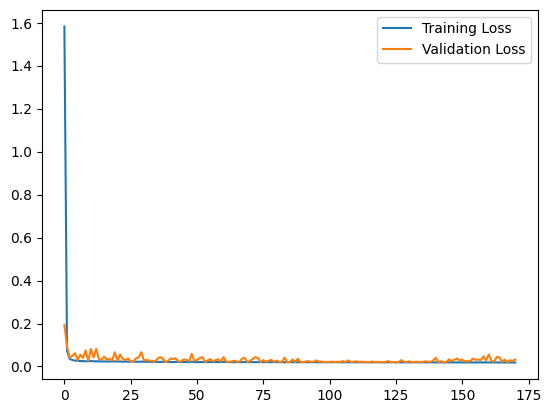

Epoch 1/1000
213/213 [==============================] - 24s 71ms/step - loss: 1.7730 - mean_directional_accuracy: 0.9593 - val_loss: 0.2826 - val_mean_directional_accuracy: 0.6458
Epoch 2/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.1123 - mean_directional_accuracy: 0.9562 - val_loss: 0.1344 - val_mean_directional_accuracy: 0.6458
Epoch 3/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0418 - mean_directional_accuracy: 0.9577 - val_loss: 0.0606 - val_mean_directional_accuracy: 0.6458
Epoch 4/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0314 - mean_directional_accuracy: 0.9546 - val_loss: 0.0855 - val_mean_directional_accuracy: 0.6458
Epoch 5/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0279 - mean_directional_accuracy: 0.9609 - val_loss: 0.0674 - val_mean_directional_accuracy: 0.6458
Epoch 6/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0265 - mean_directio

213/213 [==============================] - 14s 68ms/step - loss: 0.0204 - mean_directional_accuracy: 0.9624 - val_loss: 0.0220 - val_mean_directional_accuracy: 0.5625
Epoch 47/1000
213/213 [==============================] - 14s 67ms/step - loss: 0.0204 - mean_directional_accuracy: 0.9577 - val_loss: 0.0228 - val_mean_directional_accuracy: 0.6042
Epoch 48/1000
213/213 [==============================] - 14s 67ms/step - loss: 0.0203 - mean_directional_accuracy: 0.9750 - val_loss: 0.0196 - val_mean_directional_accuracy: 0.5625
Epoch 49/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0201 - mean_directional_accuracy: 0.9812 - val_loss: 0.0225 - val_mean_directional_accuracy: 0.6042
Epoch 50/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0200 - mean_directional_accuracy: 0.9812 - val_loss: 0.0230 - val_mean_directional_accuracy: 0.5625
Epoch 51/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0202 - mean_directional_accu

213/213 [==============================] - 14s 66ms/step - loss: 0.0197 - mean_directional_accuracy: 0.9765 - val_loss: 0.0205 - val_mean_directional_accuracy: 0.5625
Epoch 92/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0200 - mean_directional_accuracy: 0.9797 - val_loss: 0.0242 - val_mean_directional_accuracy: 0.5625
Epoch 93/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0200 - mean_directional_accuracy: 0.9797 - val_loss: 0.0197 - val_mean_directional_accuracy: 0.5625
Epoch 94/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0197 - mean_directional_accuracy: 0.9781 - val_loss: 0.0196 - val_mean_directional_accuracy: 0.5625
Epoch 95/1000
213/213 [==============================] - 14s 67ms/step - loss: 0.0198 - mean_directional_accuracy: 0.9734 - val_loss: 0.0192 - val_mean_directional_accuracy: 0.5625
Epoch 96/1000
213/213 [==============================] - 14s 68ms/step - loss: 0.0195 - mean_directional_accu

213/213 [==============================] - 12s 58ms/step - loss: 0.0189 - mean_directional_accuracy: 0.9859 - val_loss: 0.0193 - val_mean_directional_accuracy: 0.6042
Epoch 137/1000
213/213 [==============================] - 12s 58ms/step - loss: 0.0194 - mean_directional_accuracy: 0.9750 - val_loss: 0.0439 - val_mean_directional_accuracy: 0.5625
Epoch 138/1000
213/213 [==============================] - 12s 59ms/step - loss: 0.0213 - mean_directional_accuracy: 0.9844 - val_loss: 0.0197 - val_mean_directional_accuracy: 0.5625
Epoch 139/1000
213/213 [==============================] - 13s 59ms/step - loss: 0.0192 - mean_directional_accuracy: 0.9765 - val_loss: 0.0197 - val_mean_directional_accuracy: 0.5625
Epoch 140/1000
213/213 [==============================] - 12s 58ms/step - loss: 0.0191 - mean_directional_accuracy: 0.9797 - val_loss: 0.0227 - val_mean_directional_accuracy: 0.5625
Epoch 141/1000
213/213 [==============================] - 12s 58ms/step - loss: 0.0190 - mean_directional

213/213 [==============================] - 13s 61ms/step - loss: 0.0189 - mean_directional_accuracy: 0.9750 - val_loss: 0.0220 - val_mean_directional_accuracy: 0.6458
Epoch 182/1000
213/213 [==============================] - 13s 59ms/step - loss: 0.0188 - mean_directional_accuracy: 0.9828 - val_loss: 0.0193 - val_mean_directional_accuracy: 0.6458
Epoch 183/1000
213/213 [==============================] - 12s 58ms/step - loss: 0.0186 - mean_directional_accuracy: 0.9859 - val_loss: 0.0187 - val_mean_directional_accuracy: 0.6458
Epoch 184/1000
213/213 [==============================] - 12s 58ms/step - loss: 0.0188 - mean_directional_accuracy: 0.9890 - val_loss: 0.0204 - val_mean_directional_accuracy: 0.6458
Epoch 185/1000
213/213 [==============================] - 13s 59ms/step - loss: 0.0186 - mean_directional_accuracy: 0.9828 - val_loss: 0.0204 - val_mean_directional_accuracy: 0.6458
Epoch 186/1000
213/213 [==============================] - 13s 60ms/step - loss: 0.0187 - mean_directional

213/213 [==============================] - 12s 58ms/step - loss: 0.0184 - mean_directional_accuracy: 0.9797 - val_loss: 0.0183 - val_mean_directional_accuracy: 0.6042
Epoch 227/1000
213/213 [==============================] - 13s 60ms/step - loss: 0.0184 - mean_directional_accuracy: 0.9859 - val_loss: 0.0208 - val_mean_directional_accuracy: 0.6042
Epoch 228/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0184 - mean_directional_accuracy: 0.9875 - val_loss: 0.0200 - val_mean_directional_accuracy: 0.6042
Epoch 229/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0184 - mean_directional_accuracy: 0.9750 - val_loss: 0.0241 - val_mean_directional_accuracy: 0.6042
Epoch 230/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0185 - mean_directional_accuracy: 0.9797 - val_loss: 0.0189 - val_mean_directional_accuracy: 0.6042
Epoch 231/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0186 - mean_directional

213/213 [==============================] - 13s 62ms/step - loss: 0.0316 - mean_directional_accuracy: 0.9155 - val_loss: 0.0529 - val_mean_directional_accuracy: 0.6042
Epoch 272/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0311 - mean_directional_accuracy: 0.9546 - val_loss: 0.0295 - val_mean_directional_accuracy: 0.6042
Epoch 273/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0313 - mean_directional_accuracy: 0.9484 - val_loss: 0.0310 - val_mean_directional_accuracy: 0.6667
Epoch 274/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0311 - mean_directional_accuracy: 0.9515 - val_loss: 0.0288 - val_mean_directional_accuracy: 0.6250
Epoch 275/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0308 - mean_directional_accuracy: 0.9452 - val_loss: 0.0376 - val_mean_directional_accuracy: 0.6042
Epoch 276/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0331 - mean_directional

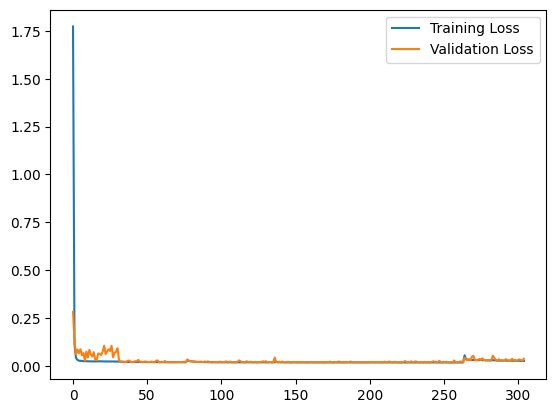

Epoch 1/1000
213/213 [==============================] - 22s 74ms/step - loss: 1.5913 - mean_directional_accuracy: 0.9656 - val_loss: 0.1622 - val_mean_directional_accuracy: 0.6458
Epoch 2/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0736 - mean_directional_accuracy: 0.9703 - val_loss: 0.2431 - val_mean_directional_accuracy: 0.6458
Epoch 3/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0370 - mean_directional_accuracy: 0.9640 - val_loss: 0.0962 - val_mean_directional_accuracy: 0.6458
Epoch 4/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0296 - mean_directional_accuracy: 0.9640 - val_loss: 0.0856 - val_mean_directional_accuracy: 0.6458
Epoch 5/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0275 - mean_directional_accuracy: 0.9703 - val_loss: 0.1044 - val_mean_directional_accuracy: 0.6458
Epoch 6/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0254 - mean_directio

213/213 [==============================] - 13s 62ms/step - loss: 0.0210 - mean_directional_accuracy: 0.9781 - val_loss: 0.0480 - val_mean_directional_accuracy: 0.6250
Epoch 47/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0212 - mean_directional_accuracy: 0.9593 - val_loss: 0.0260 - val_mean_directional_accuracy: 0.6250
Epoch 48/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0206 - mean_directional_accuracy: 0.9687 - val_loss: 0.0304 - val_mean_directional_accuracy: 0.6250
Epoch 49/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0206 - mean_directional_accuracy: 0.9687 - val_loss: 0.0297 - val_mean_directional_accuracy: 0.6667
Epoch 50/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0208 - mean_directional_accuracy: 0.9734 - val_loss: 0.0298 - val_mean_directional_accuracy: 0.6667
Epoch 51/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0211 - mean_directional_accu

213/213 [==============================] - 13s 62ms/step - loss: 0.0201 - mean_directional_accuracy: 0.9687 - val_loss: 0.0269 - val_mean_directional_accuracy: 0.6250
Epoch 92/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0200 - mean_directional_accuracy: 0.9640 - val_loss: 0.0208 - val_mean_directional_accuracy: 0.6250
Epoch 93/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0199 - mean_directional_accuracy: 0.9812 - val_loss: 0.0258 - val_mean_directional_accuracy: 0.5625
Epoch 94/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0201 - mean_directional_accuracy: 0.9797 - val_loss: 0.0279 - val_mean_directional_accuracy: 0.6250
Epoch 95/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0205 - mean_directional_accuracy: 0.9734 - val_loss: 0.0207 - val_mean_directional_accuracy: 0.6250
Epoch 96/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0201 - mean_directional_accu

213/213 [==============================] - 14s 64ms/step - loss: 0.0197 - mean_directional_accuracy: 0.9765 - val_loss: 0.0203 - val_mean_directional_accuracy: 0.6042
Epoch 137/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0197 - mean_directional_accuracy: 0.9828 - val_loss: 0.0244 - val_mean_directional_accuracy: 0.6042
Epoch 138/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0196 - mean_directional_accuracy: 0.9812 - val_loss: 0.0277 - val_mean_directional_accuracy: 0.6042
Epoch 139/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0198 - mean_directional_accuracy: 0.9703 - val_loss: 0.0201 - val_mean_directional_accuracy: 0.6042
Epoch 140/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0195 - mean_directional_accuracy: 0.9750 - val_loss: 0.0218 - val_mean_directional_accuracy: 0.6042
Epoch 141/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0196 - mean_directional

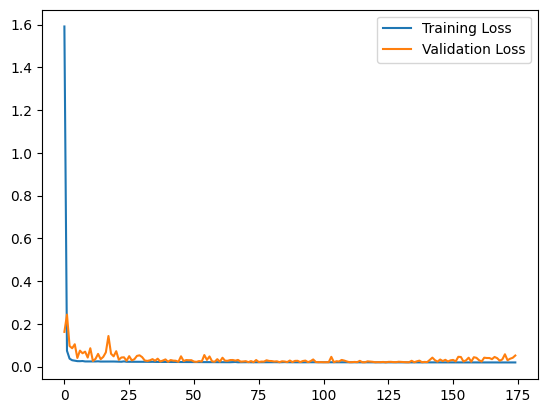

Epoch 1/1000
213/213 [==============================] - 21s 73ms/step - loss: 1.6089 - mean_directional_accuracy: 0.9765 - val_loss: 0.2024 - val_mean_directional_accuracy: 0.6458
Epoch 2/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0771 - mean_directional_accuracy: 0.9624 - val_loss: 0.0779 - val_mean_directional_accuracy: 0.6458
Epoch 3/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0354 - mean_directional_accuracy: 0.9609 - val_loss: 0.0772 - val_mean_directional_accuracy: 0.6458
Epoch 4/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0297 - mean_directional_accuracy: 0.9577 - val_loss: 0.0308 - val_mean_directional_accuracy: 0.6458
Epoch 5/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0278 - mean_directional_accuracy: 0.9718 - val_loss: 0.0976 - val_mean_directional_accuracy: 0.6458
Epoch 6/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0254 - mean_directio

213/213 [==============================] - 13s 62ms/step - loss: 0.0213 - mean_directional_accuracy: 0.9687 - val_loss: 0.0228 - val_mean_directional_accuracy: 0.6667
Epoch 47/1000
213/213 [==============================] - 14s 63ms/step - loss: 0.0214 - mean_directional_accuracy: 0.9797 - val_loss: 0.0277 - val_mean_directional_accuracy: 0.6667
Epoch 48/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0208 - mean_directional_accuracy: 0.9531 - val_loss: 0.0241 - val_mean_directional_accuracy: 0.6667
Epoch 49/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0213 - mean_directional_accuracy: 0.9750 - val_loss: 0.0315 - val_mean_directional_accuracy: 0.6667
Epoch 50/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0212 - mean_directional_accuracy: 0.9687 - val_loss: 0.0220 - val_mean_directional_accuracy: 0.6667
Epoch 51/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0215 - mean_directional_accu

213/213 [==============================] - 13s 62ms/step - loss: 0.0208 - mean_directional_accuracy: 0.9593 - val_loss: 0.0219 - val_mean_directional_accuracy: 0.6250
Epoch 92/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0203 - mean_directional_accuracy: 0.9750 - val_loss: 0.0237 - val_mean_directional_accuracy: 0.6250
Epoch 93/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0202 - mean_directional_accuracy: 0.9632 - val_loss: 0.0357 - val_mean_directional_accuracy: 0.6250
Epoch 94/1000
213/213 [==============================] - 13s 62ms/step - loss: 0.0206 - mean_directional_accuracy: 0.9562 - val_loss: 0.0212 - val_mean_directional_accuracy: 0.6250
Epoch 95/1000
213/213 [==============================] - 13s 60ms/step - loss: 0.0204 - mean_directional_accuracy: 0.9718 - val_loss: 0.0258 - val_mean_directional_accuracy: 0.5625
Epoch 96/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0202 - mean_directional_accu

213/213 [==============================] - 13s 63ms/step - loss: 0.0201 - mean_directional_accuracy: 0.9812 - val_loss: 0.0327 - val_mean_directional_accuracy: 0.5833
Epoch 137/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0258 - mean_directional_accuracy: 0.9781 - val_loss: 0.0353 - val_mean_directional_accuracy: 0.6667
Epoch 138/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0213 - mean_directional_accuracy: 0.9750 - val_loss: 0.0260 - val_mean_directional_accuracy: 0.6667
Epoch 139/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0202 - mean_directional_accuracy: 0.9718 - val_loss: 0.0214 - val_mean_directional_accuracy: 0.6250
Epoch 140/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0202 - mean_directional_accuracy: 0.9671 - val_loss: 0.0217 - val_mean_directional_accuracy: 0.6250
Epoch 141/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0200 - mean_directional

213/213 [==============================] - 13s 59ms/step - loss: 0.0277 - mean_directional_accuracy: 0.9624 - val_loss: 0.0286 - val_mean_directional_accuracy: 0.6667
Epoch 182/1000
213/213 [==============================] - 13s 60ms/step - loss: 0.0261 - mean_directional_accuracy: 0.9656 - val_loss: 0.0277 - val_mean_directional_accuracy: 0.6667
Epoch 183/1000
213/213 [==============================] - 13s 61ms/step - loss: 0.0247 - mean_directional_accuracy: 0.9703 - val_loss: 0.0260 - val_mean_directional_accuracy: 0.5833
Epoch 184/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0250 - mean_directional_accuracy: 0.9624 - val_loss: 0.0278 - val_mean_directional_accuracy: 0.6667
Epoch 185/1000
213/213 [==============================] - 13s 61ms/step - loss: 0.0272 - mean_directional_accuracy: 0.9703 - val_loss: 0.0284 - val_mean_directional_accuracy: 0.6250
Epoch 186/1000
213/213 [==============================] - 13s 61ms/step - loss: 0.0261 - mean_directional

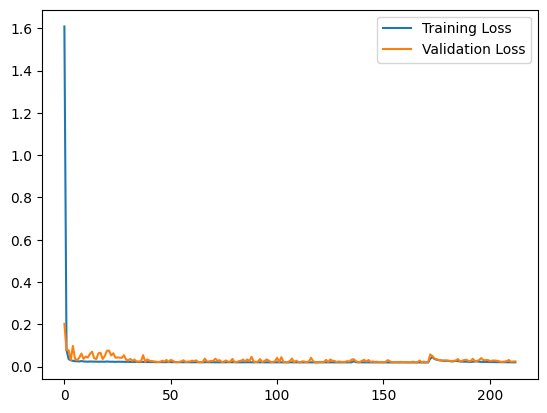

Epoch 1/1000
213/213 [==============================] - 22s 69ms/step - loss: 1.7623 - mean_directional_accuracy: 0.9593 - val_loss: 0.2679 - val_mean_directional_accuracy: 0.5625
Epoch 2/1000
213/213 [==============================] - 13s 61ms/step - loss: 0.1107 - mean_directional_accuracy: 0.9640 - val_loss: 0.0798 - val_mean_directional_accuracy: 0.6042
Epoch 3/1000
213/213 [==============================] - 13s 59ms/step - loss: 0.0392 - mean_directional_accuracy: 0.9531 - val_loss: 0.1092 - val_mean_directional_accuracy: 0.6458
Epoch 4/1000
213/213 [==============================] - 13s 60ms/step - loss: 0.0301 - mean_directional_accuracy: 0.9671 - val_loss: 0.0757 - val_mean_directional_accuracy: 0.6458
Epoch 5/1000
213/213 [==============================] - 13s 59ms/step - loss: 0.0279 - mean_directional_accuracy: 0.9531 - val_loss: 0.0440 - val_mean_directional_accuracy: 0.6458
Epoch 6/1000
213/213 [==============================] - 13s 59ms/step - loss: 0.0273 - mean_directio

213/213 [==============================] - 13s 62ms/step - loss: 0.0208 - mean_directional_accuracy: 0.9765 - val_loss: 0.0272 - val_mean_directional_accuracy: 0.6042
Epoch 47/1000
213/213 [==============================] - 13s 60ms/step - loss: 0.0209 - mean_directional_accuracy: 0.9734 - val_loss: 0.0375 - val_mean_directional_accuracy: 0.6042
Epoch 48/1000
213/213 [==============================] - 13s 60ms/step - loss: 0.0211 - mean_directional_accuracy: 0.9703 - val_loss: 0.0410 - val_mean_directional_accuracy: 0.6667
Epoch 49/1000
213/213 [==============================] - 13s 61ms/step - loss: 0.0210 - mean_directional_accuracy: 0.9734 - val_loss: 0.0288 - val_mean_directional_accuracy: 0.6667
Epoch 50/1000
213/213 [==============================] - 13s 61ms/step - loss: 0.0205 - mean_directional_accuracy: 0.9765 - val_loss: 0.0408 - val_mean_directional_accuracy: 0.6250
Epoch 51/1000
213/213 [==============================] - 13s 61ms/step - loss: 0.0209 - mean_directional_accu

213/213 [==============================] - 13s 60ms/step - loss: 0.0202 - mean_directional_accuracy: 0.9703 - val_loss: 0.0278 - val_mean_directional_accuracy: 0.5625
Epoch 92/1000
213/213 [==============================] - 13s 60ms/step - loss: 0.0202 - mean_directional_accuracy: 0.9703 - val_loss: 0.0197 - val_mean_directional_accuracy: 0.6458
Epoch 93/1000
213/213 [==============================] - 13s 60ms/step - loss: 0.0197 - mean_directional_accuracy: 0.9797 - val_loss: 0.0267 - val_mean_directional_accuracy: 0.6042
Epoch 94/1000
213/213 [==============================] - 13s 59ms/step - loss: 0.0200 - mean_directional_accuracy: 0.9781 - val_loss: 0.0275 - val_mean_directional_accuracy: 0.6458
Epoch 95/1000
213/213 [==============================] - 13s 60ms/step - loss: 0.0198 - mean_directional_accuracy: 0.9609 - val_loss: 0.0247 - val_mean_directional_accuracy: 0.6458
Epoch 96/1000
213/213 [==============================] - 13s 60ms/step - loss: 0.0197 - mean_directional_accu

213/213 [==============================] - 13s 61ms/step - loss: 0.0192 - mean_directional_accuracy: 0.9789 - val_loss: 0.0207 - val_mean_directional_accuracy: 0.6042
Epoch 137/1000
213/213 [==============================] - 13s 60ms/step - loss: 0.0191 - mean_directional_accuracy: 0.9828 - val_loss: 0.0195 - val_mean_directional_accuracy: 0.6042
Epoch 138/1000
213/213 [==============================] - 13s 59ms/step - loss: 0.0192 - mean_directional_accuracy: 0.9875 - val_loss: 0.0198 - val_mean_directional_accuracy: 0.6458


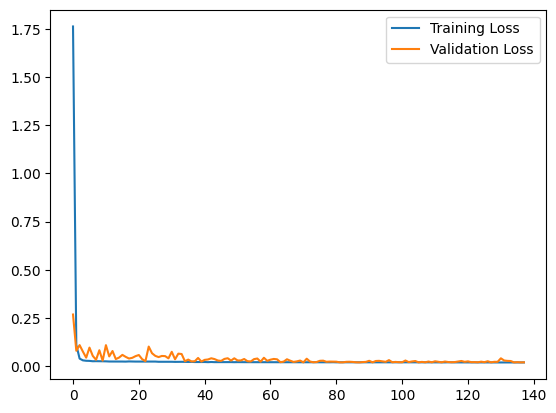

In [30]:
all_predictions = []
final_close_predictions = []
final_models = []
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)



for i, trial in enumerate(top_5_trials):
    best_params = trial.params
    
    # Créer le modèle de réseau neuronal
    final_model = create_model(
            num_layers = best_params_final['num_layers'],
            units_per_layer=[2 ** (best_params_final[f'units_power_{i}']) for i in range(int(best_params_final['num_layers']))],
            layer_type=[best_params_final[f'layer_type_{i}'] for i in range(best_params_final['num_layers'])],
            dropout_per_layer=[best_params_final[f'dropout_{i}'] for i in range(best_params_final['num_layers'])],
            input_shape=((best_params_final['look_back']), (len(reduced_df.columns) + 1)),
            use_conv1d=best_params_final['use_conv1d'],
            conv1d_filters=2 ** best_params_final.get('conv1d_filters', 0),
            conv1d_kernel_size=best_params_final.get('conv1d_kernel_size', None),
            use_residual_connection=best_params_final['use_residual_connection'],
            attention_layer=best_params_final['use_attention_layer'],
            l1_reg=best_params_final['l1_reg'],
            l2_reg=best_params_final['l2_reg']
    )
    
    #Création de séquences

    X_train_final, y_train_final = create_sequences(final_combined_data.iloc[:train_size].values, best_params_final['look_back'])
    X_test_final, y_test_final = create_sequences(final_combined_data.iloc[train_size:].values, best_params_final['look_back'])

    history = final_model.fit(
        X_train_final, y_train_final,
        validation_data=(X_test_final, y_test_final),
        epochs=1000,
        batch_size=32,
        callbacks=[early_stopping]
    )

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()
    
    # Initialiser l'entrée récursive avec les dernières valeurs réelles des caractéristiques filtrées et la valeur du SP500 de la veille
    initial_input_features = final_combined_data[final_features].iloc[-(best_params_final['look_back']):].values
    initial_input_sp500_close = final_combined_data[('GSPC', 'Close')].iloc[-(best_params_final['look_back']):].values.reshape(-1, 1)
    initial_input_sp500_open = final_combined_data[('GSPC', 'Open')].iloc[-(best_params_final['look_back']):].values.reshape(-1, 1)

    # Alternance des valeurs 'Close' et 'Open'
    initial_input_sp500 = np.column_stack((initial_input_sp500_close, initial_input_sp500_open)).ravel().reshape(-1, 1)

    # Concaténer les caractéristiques et la valeur du SP500 pour former l'entrée récursive initiale
    initial_input = np.hstack([np.repeat(initial_input_features, 2, axis=0), initial_input_sp500])


    # Effectuer la prédiction récursive avec le modèle final
    last_n_real_values_sp500 = combined_data[('GSPC', 'Close')].iloc[-10-len(y_test_final):].values.flatten()
    predictions = recursive_prediction_final_model(final_model, initial_input, best_params_final['look_back'], best_model_per_feature, final_scalers, best_params_final['look_back'])
    
    # Ne conserver que les prédictions de clôture (positions impaires)
    close_predictions = predictions[1::2]  # Commence à l'index 1 et prend chaque deuxième élément à partir de là
    final_close_predictions.append(close_predictions)
    
    all_predictions.append(predictions)
    final_models.append(final_model)


#### Utiliser la médiane des prédictions

In [31]:
median_predictions = np.median(np.array(all_predictions), axis=0)

In [32]:
#Appliquer le filtre gaussien aux données réelles
smoothed_real_values = gaussian_filter1d(real_values, sigma=5)

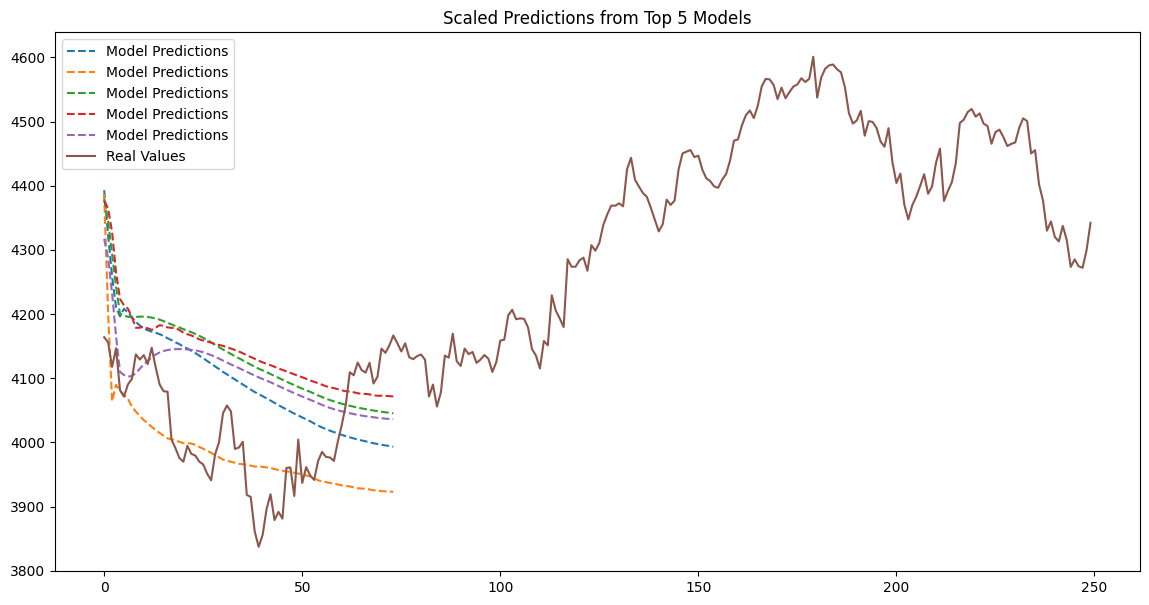

In [33]:
plt.figure(figsize=(14, 7))

for predictions in all_predictions:
    
    predictions_close = predictions[:, 0]
    predictions_close_inverse = sp500_scaler.inverse_transform(predictions_close)
    plt.plot(predictions_close_inverse[:, 0], label='Model Predictions', linestyle='--')

# Inverser la mise à l'échelle des valeurs réelles (y_test_final)
inverse_real_values = sp500_scaler.inverse_transform(y_test_final.reshape(-1, 1))

# Extraire les valeurs de clôture
inverse_real_values_close = inverse_real_values[:, 0]
plt.plot(inverse_real_values_close, label='Real Values')
plt.legend()

plt.title('Scaled Predictions from Top 5 Models')

plt.show()


#### Graphique comparatif avec les valeurs réelles

In [34]:
inverse_final_predictions = sp500_scaler.inverse_transform(median_predictions[:,0])
print(inverse_final_predictions.shape)

(74, 1)


In [35]:
# Afficher les dernières valeurs réelles pour chaque feature (y compris le SP500)
print("Dernières valeurs réelles :")
for feature in final_features:
    real_value = combined_data[feature].iloc[-1-len(y_test)]
    print(f"{feature}: {real_value}")

real_sp500 = combined_data[('GSPC', 'Close')].iloc[-1-len(y_test)]
print(f"GSPC_Close: {real_sp500}")

print("\nPremières valeurs prédites :")
# Afficher les premières valeurs prédites pour chaque feature
for feature in final_features:
    model_type = best_model_per_feature['Best Model'][feature]
    predicted_feature_value = all_recursive_preds[model_type][feature][0]
    # Inversez la mise à l'échelle pour la caractéristique prédite
    print(f"{feature}: {predicted_feature_value}")

# Afficher la première valeur prédite pour le SP500
predicted_sp500_value = median_predictions[0]
inverse_sp500_prediction = sp500_scaler.inverse_transform(np.array(predicted_sp500_value).reshape(-1, 1))
print(f"GSPC_Close : {inverse_sp500_prediction[0][0]}")

Dernières valeurs réelles :
('VIX', 'Close'): 22.290000915527344
('FVX', 'Close'): 4.151000022888184
('NVDA', 'Close'): 207.5399932861328
GSPC_Close: 3991.050048828125

Premières valeurs prédites :
('VIX', 'Close'): 26.649900436401367
('FVX', 'Close'): [3.6618598]
('NVDA', 'Close'): [227.17265]
GSPC_Close (avant correction): 4379.1181640625


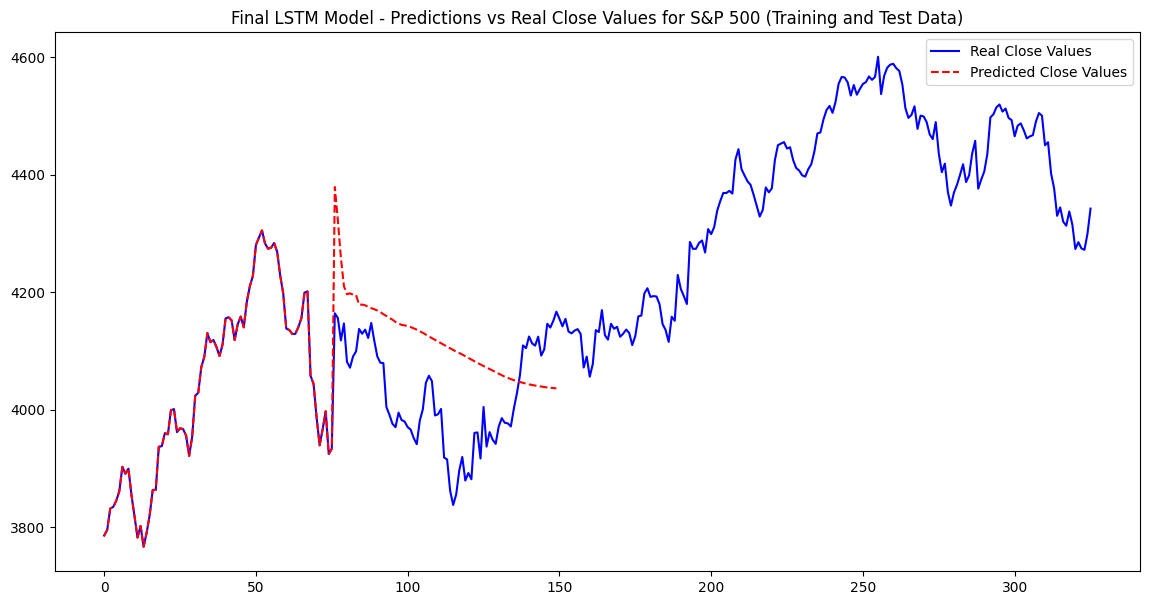

array([3933.2903, 3876.612 , 3812.8635, 3764.5334, 3750.6423, 3752.1848,
       3749.9744, 3749.18  , 3732.7903, 3732.9998, 3731.8298, 3729.0051,
       3726.882 , 3725.198 , 3722.905 , 3720.1804, 3716.5823, 3713.6506,
       3710.1628, 3707.3557, 3703.4265, 3700.4954, 3698.4714, 3697.6667,
       3696.427 , 3694.7517, 3692.5242, 3690.3298, 3687.491 , 3684.8816,
       3681.7156, 3678.7498, 3675.764 , 3672.9802, 3670.1233, 3667.0989,
       3664.2468, 3661.407 , 3658.4524, 3655.6785, 3652.9578, 3650.5564,
       3647.9568, 3645.0789, 3642.1335, 3639.2854, 3636.426 , 3633.6746,
       3630.9973, 3628.3494, 3625.7556, 3623.2864, 3620.672 , 3618.1165,
       3615.2986, 3612.7844, 3610.1594, 3608.0193, 3606.071 , 3604.3533,
       3602.6501, 3601.157 , 3599.7415, 3598.3938, 3597.1013, 3596.1106,
       3595.0354, 3594.136 , 3593.4915, 3592.5413, 3591.9739, 3591.302 ,
       3590.7185, 3590.2864], dtype=float32)

In [36]:
inverse_final_predictions_close = inverse_final_predictions[:, 0]
# Utilisez le scaler pour inverser la mise à l'échelle des dernières valeurs réelles de l'ensemble d'entraînement pour le S&P 500
last_real_values_train_scaled = y_train_final
last_real_values_train = sp500_scaler.inverse_transform(last_real_values_train_scaled.reshape(-1, 1))[:, 0]  # On prend seulement les valeurs de clôture

# Inverser la mise à l'échelle des valeurs réelles (y_test_final)
inverse_real_values = sp500_scaler.inverse_transform(y_test_final.reshape(-1, 1))

# Extraire les valeurs de clôture
inverse_real_values_close = inverse_real_values[:, 0]

# Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les vraies valeurs de l'ensemble de test
real_values = np.concatenate([last_real_values_train, inverse_real_values_close])


#inverse_final_predictions_close = inverse_final_predictions_close -(inverse_final_predictions_close[0] - last_real_values_train[-1])

# Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les valeurs prédites
predicted_values = np.concatenate([last_real_values_train, inverse_final_predictions_close])

inverse_final_predictions_close = inverse_final_predictions_close -(inverse_final_predictions_close[0] - last_real_values_train[-1])
plt.figure(figsize=(14,7))

# Tracer les valeurs réelles
plt.plot(real_values[-150 - (len(real_values) - len(predicted_values)):], label='Real Close Values', color='blue')
# Tracer les valeurs prédites
plt.plot(predicted_values[-150:], label='Predicted Close Values', color='red', linestyle='--')

plt.title("Final LSTM Model - Predictions vs Real Close Values for S&P 500 (Training and Test Data)")
plt.legend()
plt.show()

inverse_final_predictions_close

#### Métriques d'évaluation:

In [37]:
# Métriques d'évaluation
min_length = min(len(inverse_real_values_close), len(inverse_final_predictions_close))
mse = mean_squared_error(inverse_real_values_close[:min_length], inverse_final_predictions_close[:min_length])
rmse = np.sqrt(mse)
mae = mean_absolute_error(inverse_real_values_close[:min_length], inverse_final_predictions_close[:min_length])
r2 = r2_score(inverse_real_values_close[:min_length], inverse_final_predictions_close[:min_length])

print(f"Erreur quadratique moyenne MSE: {mse}")
print(f"Racine de l'erreur quadratique moyenne RMSE: {rmse}")
print(f"Erreur absolue moyenne MAE: {mae}")
print(f"Coefficient de détermination R²: {r2}")

Erreur quadratique moyenne MSE: 134223.01181431516
Racine de l'erreur quadratique moyenne RMSE: 366.3645886467675
Erreur absolue moyenne MAE: 353.66121108674616
Coefficient de détermination R²: -16.292841186845937


In [45]:
from sklearn.metrics import confusion_matrix

# Calculer la direction réelle des changements de prix
real_direction = np.sign(np.diff(inverse_real_values_close[:min_length]))

# Calculer la direction prédite des changements de prix
predicted_direction = np.sign(np.diff(inverse_final_predictions_close[:min_length]))

# Créer une matrice de confusion
conf_matrix = confusion_matrix(real_direction, predicted_direction, labels=[1, -1])

print("Matrice de confusion:")
print(conf_matrix)

Matrice de confusion:
[[ 0 33]
 [ 2 38]]


# Simulation Gain/Perte

In [38]:
def simulate_trading_strategy(predictions, actual_prices, min_yield=0.000117, stop_loss=0.05, 
                              take_profit=0.05, transaction_fee=0.001, anticipation_days=2, delay_days=2):
    capital = 150
    realized_gain = [0]  # Gain that is realized by selling
    stock_quantity = 0  # Number of stocks owned
    capital_over_time = [capital]  # Track capital over time
    realized_gain_over_time = [realized_gain]  # Track realized gain over time

    last_price = actual_prices[0]

    for i in range(1, len(predictions)):

        if i % 5 != 0:
            continue

        start_window = max(0, i - anticipation_days)
        end_window = min(len(predictions) - 1, i + delay_days)
        
        window_predictions = predictions[start_window:end_window + 1]
        window_actuals = actual_prices[start_window:end_window + 1]
        
        mean_prediction = np.mean(window_predictions)
        mean_actual = np.mean(window_actuals)

        pred_today = mean_prediction
        pred_yesterday = predictions[i - 5]
        actual_today = mean_actual
        actual_yesterday = actual_prices[i - 5]
        
        expected_return = (pred_today - pred_yesterday) / pred_yesterday
        actual_return = (actual_today - actual_yesterday) / actual_yesterday

        if expected_return > min_yield and actual_return > min_yield:
            confidence_factor = 1.2
        else:
            confidence_factor = 1.0

        dynamic_stop_loss = stop_loss * confidence_factor
        dynamic_take_profit = take_profit * confidence_factor

        if stock_quantity > 0:
            gain_loss = (actual_today - last_price) / last_price

            if gain_loss >= dynamic_take_profit:
                capital += stock_quantity * actual_today * (1 - transaction_fee)
                realized_gain += stock_quantity * (actual_today - last_price)
                stock_quantity = 0

            elif gain_loss <= -dynamic_stop_loss:
                capital += stock_quantity * actual_today * (1 - transaction_fee)
                realized_gain += stock_quantity * (actual_today - last_price)
                stock_quantity = 0

        if expected_return > min_yield and capital > 0:
            buy_quantity = capital / actual_today
            capital -= buy_quantity * actual_today
            stock_quantity += buy_quantity
            last_price = actual_today

            print(f"Buy executed on day {i}. New stock quantity : {stock_quantity}")
            
        if expected_return < -min_yield and stock_quantity > 0:
            sell_quantity = stock_quantity  # sell all stocks
            capital += sell_quantity * actual_today  # Add to capital
            stock_quantity = 0  # Reset stock quantity
            last_price = actual_today  # Update the last price when a stock is sold
            print(f"Sell executed on day {i}. New stock quantity : 0")

        total_capital = capital + stock_quantity * actual_today
        capital_over_time.append(total_capital)
        realized_gain_over_time.append(realized_gain[0])

    strategy_returns = np.diff(np.array(capital_over_time)) / np.array(capital_over_time)[:-1]
    return strategy_returns, capital_over_time, realized_gain_over_time

strategy_returns, capital_over_time, realized_gain_over_time = simulate_trading_strategy(inverse_final_predictions_close, inverse_real_values)
realized_gain_over_time[0] = 0

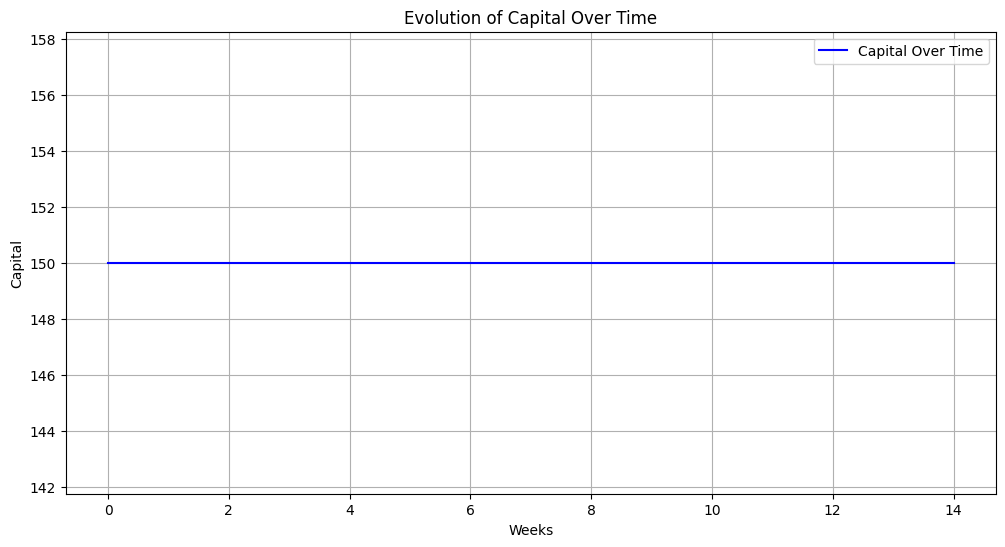

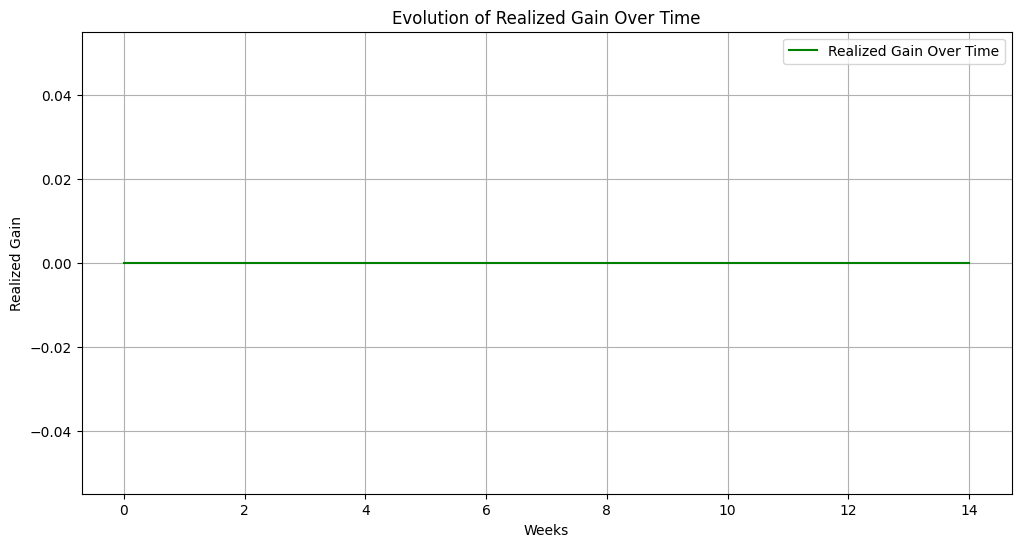

In [39]:
# Generate some sample data for the sake of demonstration
days = list(range(len(capital_over_time)))

# Plotting the evolution of capital over time
plt.figure(figsize=(12, 6))
plt.plot(days, capital_over_time, label="Capital Over Time", color='blue')
plt.xlabel("Weeks")
plt.ylabel("Capital")
plt.title("Evolution of Capital Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the evolution of realized gain over time
plt.figure(figsize=(12, 6))
plt.plot(days, realized_gain_over_time, label="Realized Gain Over Time", color='green')
plt.xlabel("Weeks")
plt.ylabel("Realized Gain")
plt.title("Evolution of Realized Gain Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Calculate the absolute and percentage gain/loss

initial_capital = capital_over_time[0]

final_capital = capital_over_time[-1]



absolute_gain_loss = final_capital - initial_capital

percentage_gain_loss = ((final_capital - initial_capital) / initial_capital) * 100



# Calculate volatility as the standard deviation of the returns

returns = np.diff(np.array(capital_over_time)) / np.array(capital_over_time)[:-1]

volatility = np.std(returns)

print(f"Gain/perte absolu sur {len(capital_over_time)*5 -1} jours : {absolute_gain_loss}")
print(f"Gain/perte en % sur {len(capital_over_time)*5 -1} jours : {percentage_gain_loss}")
print(f"Volatilité de l'indice sur {len(capital_over_time)*5 -1} jours : {volatility}")

annualized_return_percentage = ((1 + percentage_gain_loss/100) ** (252 / len(capital_over_time)/5 -1) - 1) * 100

print(f"Taux gain/perte annualisé : {annualized_return_percentage}")

initial_market_price = inverse_real_values_close[0]
final_market_price = inverse_real_values_close[len(capital_over_time)*5 -1]
market_return = (final_market_price - initial_market_price) / initial_market_price * 100

# Calculate if we beat the market
beat_the_market = percentage_gain_loss > market_return

print(f"Rendement du marché en % sur {len(capital_over_time)*5 - 1} jours : {market_return}")
print(f"Est-ce que nous avons battu le marché ? {'Oui' if beat_the_market else 'Non'} : {market_return:.2f} % {'<' if beat_the_market else '>'} {percentage_gain_loss:.2f} %")

Gain/perte absolu sur 74 jours : 0.0
Gain/perte en % sur 74 jours : 0.0
Volatilité de l'indice sur 74 jours : 0.0
Taux gain/perte annualisé : 0.0
Rendement du marché en % sur 74 jours : -0.21925751230787702
Est-ce que nous avons battu le marché ? Oui : -0.22 % < 0.00 %


In [41]:
# Calcul du ratio de Sharpe
mean_return = np.mean(np.diff(inverse_real_values_close) / inverse_real_values_close[:-1])
sharpe_ratio = mean_return / np.std(np.diff(inverse_real_values_close) / inverse_real_values_close[:-1])

print(f"Ratio de Sharpe: {sharpe_ratio}")

Ratio de Sharpe: 0.029064992465945603


## Conclusion

In [42]:
def calculate_directional_accuracy(real_values, predicted_values):
    correct_directions = 0
    total_directions = 0
    
    #fenêtre glissante sur 10 jours (2 semaines, du lundi au vendredi)
    for i in range(0, len(predicted_values), 5): #first cycle of 5 never used
        real_diff = real_values[i] - real_values[i-5]
        predicted_diff = predicted_values[i] - predicted_values[i-5]

        if (real_diff > 0 and predicted_diff > 0) or (real_diff < 0 and predicted_diff < 0):
            correct_directions += 1
        else: 
            print(f"Variation entre n°{i} et n°{i+5} fausse")

        total_directions += 1

    directional_accuracy = (correct_directions / total_directions) * 100
    return directional_accuracy

directional_accuracy = calculate_directional_accuracy(inverse_real_values_close, inverse_final_predictions_close)
print(f"Précision directionnelle sur 1 semaine: {directional_accuracy:.2f}%")

Variation entre n°0 et n°5 fausse
Variation entre n°10 et n°15 fausse
Variation entre n°30 et n°35 fausse
Variation entre n°45 et n°50 fausse
Variation entre n°50 et n°55 fausse
Variation entre n°55 et n°60 fausse
Variation entre n°60 et n°65 fausse
Variation entre n°65 et n°70 fausse
Variation entre n°70 et n°75 fausse
Précision directionnelle sur 1 semaine: 40.00%


Les résultats sont très encourageants, un investissement naïf au jour 0 aurait conduit à une perte de capital à j + 74

Les prédictions semblent satisfaisantes dans la mesure où nous battons le marché sur cette période et ce, même si le taux de gain est faible (dû à un actif très peu volatile sur la période)

Ici, le programme considère que l'indice va constament baisser sur cette période, et mise à part un peu de volatilité cela est globalement vrai, un investissement aurait pu être tenter à j + 45, ce qui se serait certainement passé si ce notebook avait été rééexcuté avec les nouvelles valeurs réelles entre temps.

Quelques points et améliorations cependant à soulever :

- Les prédictions des features autres que la valeur de l'indice lui-même ne sont disponibles que pour la valeur de clôture (et pas d'ouverture, pour l'ouverture on utilise donc la dernière valeur connue), la précision pour les modèles des features ainsi que le modèle final peut donc être encore augmenté.


- Toute la partie sur la simulation de gain/perte suppose que ce notebook n'est jamais réexécuté pendant 74 jours, or, dans les faits, prédire à nouveau la valeur de l'indice avec les nouvelles valeurs réelles augmentera les chances de corriger les prédictions directionnelles fausses à plus long terme.


- Les performances passées ne préjugent pas des performances futures, c'est valable pour un fonds investi en actions tout comme les performances de ce notebook, prenez du recul sur les résultats produits par ce dernier s'il a une quelconque influence sur vos investissements.
